<h1 style="line-height: 1.3">W4111: Introduction to Databases $-$ NoSQL and Examples</h1>

## Neo4J

- Graphs have Nodes and Relationships.


- The py2neo [_object-graph mapping_](https://py2neo.org/v3/ogm.html#py2neo.ogm.py2neo.ogm.GraphObject) packages simplifies mapping between Neo4j and Python objects. There is a good starter tutorial at [Medium](https://medium.com/neo4j/py2neo-v4-2bedc8afef2).


- The sample Movie DB has Person and Movie, and some relationships.


- You can represent this in Python with


In [27]:
from py2neo import Graph
from py2neo.ogm import GraphObject, Property, RelatedFrom, RelatedTo


graph = Graph("bolt://localhost:7687", auth=("neo4j", "neo4j"))


class Movie(GraphObject):
    __primarykey__ = "title"
    title = Property()
    tagline = Property()
    released = Property()
    actors = RelatedFrom("Person", "ACTED_IN")
    directors = RelatedFrom("Person", "DIRECTED")
    producers = RelatedFrom("Person", "PRODUCED")

class Person(GraphObject):
    __primarykey__ = "name"
    name = Property()
    born = Property()
    acted_in = RelatedTo(Movie)
    directed = RelatedTo(Movie)
    produced = RelatedTo(Movie)


- And some simple tests

In [28]:
def t1():
    x = graph.nodes.match("Person", name="Keanu Reeves").first()
    print(type(x))
    print('Born = ', x['born'])
    y = Person.wrap(x)
    print(y.born)
    print(y)

def t2():
    st = Person.match(graph).where("_.born = 1960")
    print("People born in 1960 and the movies they acted in:")
    for s in st:
        print(s.name, s.born)

        for m in s.acted_in:
            print("\t", m.title, m.released)

In [29]:
t1()

<class 'py2neo.data.Node'>
Born =  1964
1964
<Person name='Keanu Reeves'>


In [30]:
t2()

People born in 1960 and the movies they acted in:
Hugo Weaving 1960
	 The Matrix 1999
	 The Matrix Reloaded 2003
	 The Matrix Revolutions 2003
	 Cloud Atlas 2012
	 V for Vendetta 2006
Annabella Sciorra 1960
	 What Dreams May Come 1998
John Goodman 1960
	 Speed Racer 2008
Oliver Platt 1960
	 Frost/Nixon 2008
	 Bicentennial Man 1999


## Homework 4

### Setup

- Install Neo4j Community Edition. Do not install the desktop. Just install the server.


- Add py2neo to your environments, if necessary.


- Using PyCharm to develop and test your code is the best practice. You can copy the code into the notebook when done developing and testing.


### Concept

- Load information from lahman2017.people, lahman2017.teams, lahman2017.appearances. The code for loading the database is below.


- Add a Node type for _Fan._ __NOTE:__ You do not need to add a class unlike the pattern above.


- Allow a Fan to follow other Fans, Comment on a Team and/or Player and response to Comments.


### Data Model

- The loading function do not all of the data. The loaded is scoped by year range, which you will see in code below. (Loading the full database would create performance problems for you and require getting a licensed version).


- Node Labels:
    - Team: Core information loaded from Lahman 2017
    - Player: Core information loaded from Lahman 2017
    - Fan: New entity representing a baseball fan.
    - Comment: A Fan made a comment on a team or player.
    
    
- Relationships:
    - Appeared: Represents the fact that a player "appeared" for a team in a year. Loaded from a small subset of Lahman 2017.
    - Supports: A Fan supports a Team
    - Follows: A Fan follows (the comments of) another Fan.
    - CommentOn: Represents the relationship between a Comment and a Team/Player.
    - CommentBy: Relationship between a Fan and Comment.
    - ResponseTo: Indicates that a Comment is a ResponseTo a Comment.

### HW4 Part 1: Implementation and Template


- There are two parts to HW4:
    1. Simple social model and topics in Neo4j
    2. API result cache for database query results using Redis. A section later in the notebook explains part 2.
    

- HW4:
    - Starts with a Python implementation template for a class _FanGraph._
        - Contains many example methods.
        - Placeholder for the methods that you need to implement.
    - Some sample client code for creating and finding nodes and relationships.
    - A few test cases to get you started and verify correctness. You need to implement a more complete set of tests.
    
    
- HW4 tasks:
    - Load the Neo4j database using the load functions below.
    - Implement and test the incomplete methods (ones with "pass") in the template.
    
### Template
    

In [98]:
"""
This is the template. Do not execute.
"""

raise NotImplementedError("This is template fool! Do not run.")

from py2neo import data, Graph, NodeMatcher, Node, Relationship, RelationshipMatcher

"""
See https://py2neo.org/v4/
"""

"""
NOTE:
    1. I did some basic testing, debugging, etc. but there may be errors.
    2. You can complain about the errors if you want but my response will be, "No Template for You!"
"""

import json
import uuid


class FanGraph(object):
    """
    This object provides a set of helper methods for creating and retrieving nodes and relationships from
    a Neo4j database holding information about players, teams, fans, comments and their relationships.
    """

    # Note:
    # I tend to avoid object mapping frameworks. Object mapping frameworks are fun in the beginning
    # but tend to be annoying after a while. So, I did not create types Player, Team, etc.
    #


    # Connects to the DB and sets a Graph instance variable.
    # Also creates a NodeMatcher and RelationshipMatcher, which are a py2neo framework classes.
    def __init__(self, auth=('neo4j', 'neo4j'), host='localhost', port=7687, secure=False, ):
        self._graph = Graph(secure=secure,
                            bolt=True,
                            auth=auth,
                            host=host,
                            port=port)
        self._node_matcher = NodeMatcher(self._graph)
        self._relationship_matcher = RelationshipMatcher(self._graph)

    def run_q(self, qs, args):
        """

        :param qs: Query string that may have {} slots for parameters.
        :param args: Dictionary of parameters to insert into query string.
        :return:  Result of the query, which executes as a single, standalone transaction.
        """
        try:
            tx = self._graph.begin(autocommit=False)
            result = self._graph.run(qs, args)
            return result
        except Exception as e:
            print("Run exaception = ", e)

    def run_match(self, labels=None, properties=None):
        """
        Uses a NodeMatcher to find a node matching a "template."
        :param labels: A list of labels that the node must have.
        :param properties: A dictionary of {property_name: property_value} defining the template that the
            node must match.
        :return: An array of Node objects matching the pattern.
        """
        # ut.debug_message("Labels = ", labels)
        # ut.debug_message("Properties = ", json.dumps(properties))

        if labels is not None and properties is not None:
            result = self._node_matcher.match(labels, **properties)
        elif labels is not None and properties is None:
            result = self._node_matcher.match(labels)
        elif labels is None and properties is not None:
            result = self._node_matcher.match(**properties)
        else:
            raise ValueError("Invalid request. Labels and properties cannot both be None.")

        # Convert NodeMatch data into a simple list of Nodes.
        full_result = []
        for r in result:
            full_result.append(r)

        return full_result

    def find_nodes_by_template(self, tmp):
        """

        :param tmp: A template defining the label and properties for Nodes to return. An
         example is { "label": "Fan", "template" { "last_name": "Ferguson", "first_name": "Donald" }}
        :return: A list of Nodes matching the template.
        """
        labels = tmp.get('label', None)
        props = tmp.get("template", None)
        result = self.run_match(labels=labels, properties=props)
        return result

    # Create and save a new node for  a 'Fan.'
    def create_fan(self, uni, last_name, first_name):
        """

        :param uni: uni
        :param last_name: Obvious
        :param first_name: Obvious
        :return: Node created.

        NOTE: This does not check uni uniqueness. We could do using transactions or setting a constraint
        on the database.
        """
        n = Node("Fan", uni=uni, last_name=last_name, first_name=first_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    # Given a UNI, return the node for the Fan.
    def get_fan(self, uni):
        n = self.find_nodes_by_template({"label": "Fan", "template": {"uni": uni}})
        if n is not None and len(n) > 0:
            # I should throw an exception here if there is more than 1.
            n = n[0]
        else:
            n = None

        return n

    def create_player(self, player_id, last_name, first_name):
        n = Node("Player", player_id=player_id, last_name=last_name, first_name=first_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    def get_player(self, player_id):
        n = self.find_nodes_by_template({"label": "Player", "template": {"player_id": player_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_team(self, team_id, team_name):
        n = Node("Team", team_id=team_id, team_name=team_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    def get_team(self, team_id):
        n = self.find_nodes_by_template({"label": "Team", "template": {"team_id": team_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_supports(self, uni, team_id):
        """
        Create a SUPPORTS relationship from a Fan to a Team.
        :param uni: The UNI for a fan.
        :param team_id: An ID for a team.
        :return: The created SUPPORTS relationship from the Fan to the Team
        """
        f = self.get_fan(uni)
        t = self.get_team(team_id)
        r = Relationship(f, "SUPPORTS", t)
        tx = self._graph.begin(autocommit=True)
        tx.create(r)
        return r

    def get_appearance(self, player_id, team_id, year_id):
        """
        Get the information about appearances for a player and team.
        :param player_id: player_id
        :param team_id: team_id
        :param year_id: The year for getting appearances.
        :return:
        """
        try:
            # Get the Nodes at the ends of the relationship representing appearances.
            p = self.get_player(player_id)
            t = self.get_team(team_id)

            # Run a match looking for relationships of a specific type linking the nodes.
            rm = self._graph.match(nodes=[p, t], r_type="APPEARED")
            result = []

            # If there is a list of relationships.
            if rm is not None:
                for r in rm:

                    # The type will be a class APPEARED() because of the OO mapping.
                    node_type = type(r).__name__
                    year = r['year']

                    # If the type and year are correct, add to result
                    if node_type == "APPEARED" and (year == year_id or year_id is None):
                        result.append(r)

                return result
            else:
                return None
        except Exception as e:
            print("get_appearance: Exception e = ", e)
            raise e

    # Create an APPEARED relationship from a player to a Team
    def create_appearance_all(self, player_id, team_id, year, games):
        """

        :param player_id: O
        :param team_id:
        :param year:
        :param games:
        :return:
        """
        try:
            tx = self._graph.begin(autocommit=False)
            q = "match (n:Player {player_id: '" + player_id + "'}), " + \
                "(t:Team {team_id: '" + team_id + "'}) " + \
                "create (n)-[r:APPEARED { games: " + str(games) + ", year : " + str(year) + \
                "}]->(t)"
            result = self._graph.run(q)
            tx.commit()
        except Exception as e:
            print("create_appearances: exception = ", e)

    # Create a FOLLOWS relationship from a Fan to another Fan.
    def create_follows(self, follower, followed):
        f = self.get_fan(follower)
        t = self.get_fan(followed)
        r = Relationship(f, "FOLLOWS", t)
        tx = self._graph.begin(autocommit=True)
        tx.create(r)

    def get_comment(self, comment_id):
        """

        :param comment_id: Comment ID
        :return: Comment
        """
        pass

    def create_comment(self, uni, comment, team_id=None, player_id=None):
        """
        Creates a comment
        :param uni: The UNI for the Fan making the comment.
        :param comment: A simple string.
        :param team_id: A valid team ID or None. team_id and player_id cannot BOTH be None.
        :param player_id: A valid player ID or None
        :return: The Node representing the comment.
        """
        

    def create_sub_comment(self, uni, origin_comment_id, comment):
        """
        Create a sub-comment (response to a comment or response) and links with parent in thread.
        :param uni: ID of the Fan making the comment.
        :param origin_comment_id: Id of the comment to which this is a response.
        :param comment: Comment string
        :return: Created comment.
        """
        pass

    def get_sub_comments(self, comment_id):
        """

        :param comment_id: The unique ID of the comment.
        :return: The sub-comments.
        """
        pass

    def get_player_comments(self, player_id):
        """
        Gets all of the comments associated with a player, Also returns the Nodes for people making the comments.
        :param player_id: ID of the player.
        :return: Graph containing comment, comment streams and commenters.
        """
        pass

    def get_team_comments(self, team_id):
        """
        Gets all of the comments associated with a team.  Also returns the Nodes for people making the comments.
        :param player_id: ID of the team.
        :return: Graph containing comment, comment streams and commenters.
        """
        pass

    def get_players_by_team(self, team_id, yearid):
        """
        
        :param team_id: The ID of a team.
        :param yearid: A year.
        :return: Returns the players who played for the team in the year.
        """
        pass


NotImplementedError: This is 

### Tests and Examples

#### Setup The Environment

- These tests come from my solution to the homework. I have to direct the notebook's Python kernel to my implementation, which completes the template above.

In [1]:
# I run my tests off of the "real" implementation that I have
# hidden somewhere.
import sys
sys.path.append(
    '/Users/donaldferguson/Dropbox/ColumbiaCourse/Courses/W4111New/w4111-Databases/HW_Solutions/HW4')

In [2]:
import social_graph.fan_comment as fc
import json
import pandas as pd

pd.set_option('display.width', 132)

In [3]:
fg = fc.FanGraph(
                  host="localhost",
                  port=7687,
                  secure=False)


In [4]:
print("fg = ", fg)

fg =  <social_graph.fan_comment.FanGraph object at 0x1053c7a90>


#### Simple Tests and Examples

##### Query Example

In [5]:
def t1(name):
    """
    Find all the movies that a person with name 'name' is related to.
    Return information as a Pandas data frame.
    """
    
    # The match is (Person)-[any relationship]->(Movie)
    # Person name must be the passed {name}.
    # Return a list of dictionaries of the attributes/values.
    #
    qs = "match (t:Person)-[r]->(t2:Movie) " + \
    " where t.name={name} " + \
    " return t.name, t2.title, t2.released, r.roles"
    
    # Set the name parameter for the query
    ag = {"name": name}
    
    # Use the handy, dandy run_q method on FanGraph
    r = fg.run_q(qs, ag)
    
    # Convert the result into a DataFrame
    x = pd.DataFrame(r.data())
    
    # Make sure the columns are in the "right" order. 
    # Python dicts are unordered, which means the data frame's columns
    # might be in a weird order.
    x = x[['t.name', 't2.title', 't2.released', 'r.roles']]
    return x

In [6]:
# Find Tom Hanks
x = t1('Tom Hanks')
print(x)

       t.name                t2.title  t2.released                                            r.roles
0   Tom Hanks          The Green Mile         1999                                    [Paul Edgecomb]
1   Tom Hanks               Cast Away         2000                                     [Chuck Noland]
2   Tom Hanks               Apollo 13         1995                                       [Jim Lovell]
3   Tom Hanks    Charlie Wilson's War         2007                              [Rep. Charlie Wilson]
4   Tom Hanks   A League of Their Own         1992                                      [Jimmy Dugan]
5   Tom Hanks       The Polar Express         2004  [Hero Boy, Father, Conductor, Hobo, Scrooge, S...
6   Tom Hanks    Sleepless in Seattle         1993                                      [Sam Baldwin]
7   Tom Hanks         You've Got Mail         1998                                          [Joe Fox]
8   Tom Hanks  Joe Versus the Volcano         1990                                

##### Create a Fan

In [9]:
def test_create_fan():
    r = fg.create_fan(uni="dff99999", last_name="Vader", first_name="Donald")
    return r

In [10]:
f = test_create_fan()
print("Create returned ...", f)
print("The type is ... ", type(f))

Create returned ... (_71732:Fan {first_name: 'Donald', last_name: 'Vader', uni: 'dff99999'})
The type is ...  <class 'py2neo.data.Node'>


- Notice that this returns a py2neo Python class Node that holds the data.


- Let's probe this a little.


In [11]:
# Get the labels.
f.labels

:Fan

In [14]:
f.keys()

dict_keys(['uni', 'last_name', 'first_name'])

In [17]:
f.items()

dict_items([('uni', 'dff99999'), ('last_name', 'Vader'), ('first_name', 'Donald')])

In [18]:
for k,v in f.items():
    print(k, ": ", v)

uni :  dff999
last_name :  Vader
first_name :  Donald


- The Node is 'sort of' a dictionary.


- What are all the attributes? What did we actually get? Look in the documentation.


- Or use the Python function.

In [18]:
# Load the introspection/reflection functions.
import inspect

# Get the class object for the Fan (https://docs.python.org/3/tutorial/classes.html#class-objects)
cf = f.__class__

# Get the "method resolution order," i.e. the inheritance hierarchy.
inspect.getmro(cf)

(py2neo.data.Node,
 py2neo.data.Entity,
 py2neo.data.PropertyDict,
 dict,
 py2neo.data.Walkable,
 py2neo.data.Subgraph,
 object)

In [19]:
# Get all of the attributes and methods. The __xxx__ are internal. The others are attributes and functions you can
# and which are documented.
dir(f)

['_Node__ensure_labels',
 '_Subgraph__nodes',
 '_Subgraph__relationships',
 '_Walkable__sequence',
 '__add__',
 '__and__',
 '__bool__',
 '__class__',
 '__contains__',
 '__db_create__',
 '__db_delete__',
 '__db_exists__',
 '__db_merge__',
 '__db_pull__',
 '__db_push__',
 '__db_separate__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__uuid__',
 '__walk__',
 '__weakref__',
 '__xor__',
 '_labels',
 '_remote_labels',
 '_stale',
 'add_label',
 'cast',
 'clear',
 'clear_labels',
 'copy',
 'end_node',
 'fromkeys',
 'get',
 'graph',
 'has_label',
 'identity',
 'items',
 'keys',


In [29]:
q = "match (p {name: 'Tom Hanks'})-[r:ACTED_IN]->(m) return p,r,m"
r = fg.run_q(q, None)
print(r)

In [30]:
# Cursor is similar to cursor in other databases.
for t in r:
    print(t)
    

<Record p=(_17481:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Paul Edgecomb']}]->(_17540) m=(_17540:Movie {released: 1999, tagline: "Walk a mile you'll never forget.", title: 'The Green Mile'})>
<Record p=(_17481:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Chuck Noland']}]->(_17560) m=(_17560:Movie {released: 2000, tagline: 'At the edge of the world, his journey begins.', title: 'Cast Away'})>
<Record p=(_17481:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Jim Lovell']}]->(_17554) m=(_17554:Movie {released: 1995, tagline: 'Houston, we have a problem.', title: 'Apollo 13'})>
<Record p=(_17481:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Rep. Charlie Wilson']}]->(_17569) m=(_17569:Movie {released: 2007, tagline: "A stiff drink. A little mascara. A lot of nerve. Who said they couldn't bring down the Soviet empire.", title: "Charlie Wilson's War"})>
<Record p=(_17481:Per

In [38]:
print(r[0])
print(type(r[0]))
print("\n", r[1])
print(type(r[1]))
print("\n", r[2])
print(type(r[2]))
print("\n", r[3])
print(type(r[3]))

(_17481:Person {born: 1956, name: 'Tom Hanks'})
<class 'py2neo.data.Node'>

 (Tom Hanks)-[:ACTED_IN {roles: ['Dr. Robert Langdon']}]->(_17521)
<class 'py2neo.data.ACTED_IN'>

 (_17521:Movie {released: 2006, tagline: 'Break The Codes', title: 'The Da Vinci Code'})
<class 'py2neo.data.Node'>


IndexError: 3

In [40]:
r.forward()

0

In [42]:
print(r[0])
print(type(r[0]))
print("\n", r[1])
print(type(r[1]))
print("\n", r[2])
print(type(r[2]))

(_17481:Person {born: 1956, name: 'Tom Hanks'})
<class 'py2neo.data.Node'>

 (Tom Hanks)-[:ACTED_IN {roles: ['Dr. Robert Langdon']}]->(_17521)
<class 'py2neo.data.ACTED_IN'>

 (_17521:Movie {released: 2006, tagline: 'Break The Codes', title: 'The Da Vinci Code'})
<class 'py2neo.data.Node'>


##### Generic Node find_by_template()

- It should not surprise you that our graph object has this function.
    - We had it for CSVDataTable.
    - We had it for RDBDataTable.
    - We have it here.
    
    
- We will "sort of" have for Redis

In [45]:
def t_find_by_template():
    
    # Test the find_by_template() function.
    # Template includes the Label, which is a slightly different for than the find_by_template() format.
    # we previously used.
    # The Label replaces the "table name." There are no tables in Neo4j
    tmp = {"label": "Person", "template": {"name": "Tom Hanks"}}
    r = fg.find_nodes_by_template(tmp)
    return r

In [54]:
n = t_find_by_template()
print(n)
print(type(n))

[(_17481:Person {born: 1956, name: 'Tom Hanks'})]
<class 'list'>


In [67]:
from py2neo import NodeMatcher

# Should not do this, but what the heck.
nm = fg._node_matcher
n2 = nm.match(name="Tom Hanks")
n2

NameError: name 'Node' is not defined

In [69]:
y = n2.first()
print(y)
print(type(y))

(_17481:Person {born: 1956, name: 'Tom Hanks'})
<class 'py2neo.data.Node'>


In [73]:
from py2neo import NodeMatcher

# Should not do this, but what the heck.
rm = fg._relationship_matcher
r2 = rm.match([y])
r2

In [74]:
for rr in r2:
    print(rr)

(Tom Hanks)-[:ACTED_IN {roles: ['Paul Edgecomb']}]->(_17540)
(Tom Hanks)-[:ACTED_IN {roles: ['Chuck Noland']}]->(_17560)
(Tom Hanks)-[:ACTED_IN {roles: ['Jim Lovell']}]->(_17554)
(Tom Hanks)-[:ACTED_IN {roles: ['Rep. Charlie Wilson']}]->(_17569)
(Tom Hanks)-[:ACTED_IN {roles: ['Jimmy Dugan']}]->(_17572)
(Tom Hanks)-[:ACTED_IN {roles: ['Hero Boy', 'Father', 'Conductor', 'Hobo', 'Scrooge', 'Santa Claus']}]->(_17571)
(Tom Hanks)-[:ACTED_IN {roles: ['Sam Baldwin']}]->(_17483)
(Tom Hanks)-[:ACTED_IN {roles: ['Joe Fox']}]->(_17477)
(Tom Hanks)-[:ACTED_IN {roles: ['Joe Banks']}]->(_17488)
(Tom Hanks)-[:DIRECTED {}]->(_17495)
(Tom Hanks)-[:ACTED_IN {roles: ['Mr. White']}]->(_17495)
(Tom Hanks)-[:ACTED_IN {roles: ['Zachry', 'Dr. Henry Goose', 'Isaac Sachs', 'Dermot Hoggins']}]->(_17515)
(Tom Hanks)-[:ACTED_IN {roles: ['Dr. Robert Langdon']}]->(_17521)


#### Load Data

- __NOTE:__ I previously ran this code. It is just here for teaching purposes and to allow you to use it.


- There are tests below using FanGraph functions to explore the loaded data.

In [96]:
raise NotImplementedError("Do not run this code fool!")

cnx = pymysql.connect(host='localhost',
                             user='dbuser',
                             password='dbuserdbuser',
                             db='lahman2017',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

fg = FanGraph(auth=('neo4j', 'XXXXX'),
                  host="localhost",
                  port=7687,
                  secure=False)

In [47]:
raise NotImplementedError("Do not run this code fool!")

def load_players():
    """
    Load a subset of the player data. We only load a subset of the columns and the rows.
    """

    q = "SELECT playerID, nameLast, nameFirst FROM People where  " + \
        "exists (select * from appearances where appearances.playerID = " +
        " people.playerID and yearID >= 2010)"

    curs = cnx.cursor()
    curs.execute(q)

    # This is an example of using a cursor. We could have used fetchall() but
    # I wanted to give you an example of iterating using a cursor.
    r = curs.fetchone()
    cnt = 0
    
    # Loop until we are out of rows.
    while r is not None:
        print(r)
        cnt += 1
        if r is not None:
            p = fg.create_player(player_id=r['playerID'], last_name=r['nameLast'], first_name=r['nameFirst'])
            print("Created player = ", p)

        r = curs.fetchone()

    print("Loaded ", cnt, "records.")

In [48]:
raise NotImplementedError("Do not run this code fool!")

load_players()

{'playerID': 'aardsda01', 'nameLast': 'Aardsma', 'nameFirst': 'David'}
Created player =  (_22569:Player {first_name: 'David', last_name: 'Aardsma', player_id: 'aardsda01'})
{'playerID': 'abadfe01', 'nameLast': 'Abad', 'nameFirst': 'Fernando'}
Created player =  (_22574:Player {first_name: 'Fernando', last_name: 'Abad', player_id: 'abadfe01'})
{'playerID': 'abreubo01', 'nameLast': 'Abreu', 'nameFirst': 'Bobby'}
Created player =  (_22573:Player {first_name: 'Bobby', last_name: 'Abreu', player_id: 'abreubo01'})
{'playerID': 'abreujo02', 'nameLast': 'Abreu', 'nameFirst': 'Jose'}
Created player =  (_22572:Player {first_name: 'Jose', last_name: 'Abreu', player_id: 'abreujo02'})
{'playerID': 'abreuju01', 'nameLast': 'Abreu', 'nameFirst': 'Juan'}
Created player =  (_22571:Player {first_name: 'Juan', last_name: 'Abreu', player_id: 'abreuju01'})
{'playerID': 'abreuto01', 'nameLast': 'Abreu', 'nameFirst': 'Tony'}
Created player =  (_22570:Player {first_name: 'Tony', last_name: 'Abreu', player_id: 

Created player =  (_22631:Player {first_name: 'Henderson', last_name: 'Alvarez', player_id: 'alvarhe01'})
{'playerID': 'alvarjo02', 'nameLast': 'Alvarez', 'nameFirst': 'Jose'}
Created player =  (_22632:Player {first_name: 'Jose', last_name: 'Alvarez', player_id: 'alvarjo02'})
{'playerID': 'alvarjo03', 'nameLast': 'Alvarado', 'nameFirst': 'Jose'}
Created player =  (_22633:Player {first_name: 'Jose', last_name: 'Alvarado', player_id: 'alvarjo03'})
{'playerID': 'alvarpe01', 'nameLast': 'Alvarez', 'nameFirst': 'Pedro'}
Created player =  (_22634:Player {first_name: 'Pedro', last_name: 'Alvarez', player_id: 'alvarpe01'})
{'playerID': 'alvarrj01', 'nameLast': 'Alvarez', 'nameFirst': 'R. J.'}
Created player =  (_22635:Player {first_name: 'R. J.', last_name: 'Alvarez', player_id: 'alvarrj01'})
{'playerID': 'amarial01', 'nameLast': 'Amarista', 'nameFirst': 'Alexi'}
Created player =  (_22636:Player {first_name: 'Alexi', last_name: 'Amarista', player_id: 'amarial01'})
{'playerID': 'ambrihe01', 'na

Created player =  (_22710:Player {first_name: 'Grant', last_name: 'Balfour', player_id: 'balfogr01'})
{'playerID': 'bandaan01', 'nameLast': 'Banda', 'nameFirst': 'Anthony'}
Created player =  (_22711:Player {first_name: 'Anthony', last_name: 'Banda', player_id: 'bandaan01'})
{'playerID': 'bandyje01', 'nameLast': 'Bandy', 'nameFirst': 'Jett'}
Created player =  (_22712:Player {first_name: 'Jett', last_name: 'Bandy', player_id: 'bandyje01'})
{'playerID': 'banksjo01', 'nameLast': 'Banks', 'nameFirst': 'Josh'}
Created player =  (_22713:Player {first_name: 'Josh', last_name: 'Banks', player_id: 'banksjo01'})
{'playerID': 'bannibr01', 'nameLast': 'Bannister', 'nameFirst': 'Brian'}
Created player =  (_22714:Player {first_name: 'Brian', last_name: 'Bannister', player_id: 'bannibr01'})
{'playerID': 'bantzbr01', 'nameLast': 'Bantz', 'nameFirst': 'Brandon'}
Created player =  (_22715:Player {first_name: 'Brandon', last_name: 'Bantz', player_id: 'bantzbr01'})
{'playerID': 'banuema01', 'nameLast': 'Ba

Created player =  (_22815:Player {first_name: 'Nick', last_name: 'Blackburn', player_id: 'blackni01'})
{'playerID': 'blackpa01', 'nameLast': 'Blackburn', 'nameFirst': 'Paul'}
Created player =  (_22816:Player {first_name: 'Paul', last_name: 'Blackburn', player_id: 'blackpa01'})
{'playerID': 'blacktr01', 'nameLast': 'Blackley', 'nameFirst': 'Travis'}
Created player =  (_22817:Player {first_name: 'Travis', last_name: 'Blackley', player_id: 'blacktr01'})
{'playerID': 'blackvi01', 'nameLast': 'Black', 'nameFirst': 'Vic'}
Created player =  (_22818:Player {first_name: 'Vic', last_name: 'Black', player_id: 'blackvi01'})
{'playerID': 'blairaa01', 'nameLast': 'Blair', 'nameFirst': 'Aaron'}
Created player =  (_22819:Player {first_name: 'Aaron', last_name: 'Blair', player_id: 'blairaa01'})
{'playerID': 'blairca01', 'nameLast': 'Blair', 'nameFirst': 'Carson'}
Created player =  (_22820:Player {first_name: 'Carson', last_name: 'Blair', player_id: 'blairca01'})
{'playerID': 'blakeca01', 'nameLast': 'B

Created player =  (_22923:Player {first_name: 'Ryan', last_name: 'Buchter', player_id: 'buchtry01'})
{'playerID': 'buckjo01', 'nameLast': 'Buck', 'nameFirst': 'John'}
Created player =  (_22924:Player {first_name: 'John', last_name: 'Buck', player_id: 'buckjo01'})
{'playerID': 'bucknbi02', 'nameLast': 'Buckner', 'nameFirst': 'Billy'}
Created player =  (_22925:Player {first_name: 'Billy', last_name: 'Buckner', player_id: 'bucknbi02'})
{'playerID': 'bucktr01', 'nameLast': 'Buck', 'nameFirst': 'Travis'}
Created player =  (_22926:Player {first_name: 'Travis', last_name: 'Buck', player_id: 'bucktr01'})
{'playerID': 'buddery01', 'nameLast': 'Budde', 'nameFirst': 'Ryan'}
Created player =  (_22927:Player {first_name: 'Ryan', last_name: 'Budde', player_id: 'buddery01'})
{'playerID': 'buehlwa01', 'nameLast': 'Buehler', 'nameFirst': 'Walker'}
Created player =  (_22928:Player {first_name: 'Walker', last_name: 'Buehler', player_id: 'buehlwa01'})
{'playerID': 'buehrma01', 'nameLast': 'Buehrle', 'name

Created player =  (_23011:Player {first_name: 'Shane', last_name: 'Carle', player_id: 'carlesh01'})
{'playerID': 'carlilu01', 'nameLast': 'Carlin', 'nameFirst': 'Luke'}
Created player =  (_23012:Player {first_name: 'Luke', last_name: 'Carlin', player_id: 'carlilu01'})
{'playerID': 'carlsje01', 'nameLast': 'Carlson', 'nameFirst': 'Jesse'}
Created player =  (_23013:Player {first_name: 'Jesse', last_name: 'Carlson', player_id: 'carlsje01'})
{'playerID': 'carlybu01', 'nameLast': 'Carlyle', 'nameFirst': 'Buddy'}
Created player =  (_23014:Player {first_name: 'Buddy', last_name: 'Carlyle', player_id: 'carlybu01'})
{'playerID': 'carmofa01', 'nameLast': 'Hernandez', 'nameFirst': 'Roberto'}
Created player =  (_23015:Player {first_name: 'Roberto', last_name: 'Hernandez', player_id: 'carmofa01'})
{'playerID': 'carpean01', 'nameLast': 'Carpenter', 'nameFirst': 'Drew'}
Created player =  (_23016:Player {first_name: 'Drew', last_name: 'Carpenter', player_id: 'carpean01'})
{'playerID': 'carpech01', 'na

Created player =  (_23122:Player {first_name: 'Gerrit', last_name: 'Cole', player_id: 'colege01'})
{'playerID': 'colemca01', 'nameLast': 'Coleman', 'nameFirst': 'Casey'}
Created player =  (_23123:Player {first_name: 'Casey', last_name: 'Coleman', player_id: 'colemca01'})
{'playerID': 'colemdu01', 'nameLast': 'Coleman', 'nameFirst': 'Dusty'}
Created player =  (_23124:Player {first_name: 'Dusty', last_name: 'Coleman', player_id: 'colemdu01'})
{'playerID': 'colemlo01', 'nameLast': 'Coleman', 'nameFirst': 'Louis'}
Created player =  (_23125:Player {first_name: 'Louis', last_name: 'Coleman', player_id: 'colemlo01'})
{'playerID': 'coleta01', 'nameLast': 'Cole', 'nameFirst': 'Taylor'}
Created player =  (_23126:Player {first_name: 'Taylor', last_name: 'Cole', player_id: 'coleta01'})
{'playerID': 'colliti01', 'nameLast': 'Collins', 'nameFirst': 'Tim'}
Created player =  (_23127:Player {first_name: 'Tim', last_name: 'Collins', player_id: 'colliti01'})
{'playerID': 'collity01', 'nameLast': 'Collins

Created player =  (_23248:Player {first_name: 'Sam', last_name: 'Deduno', player_id: 'dedunsa01'})
{'playerID': 'defraju01', 'nameLast': 'De Fratus', 'nameFirst': 'Justin'}
Created player =  (_23249:Player {first_name: 'Justin', last_name: 'De Fratus', player_id: 'defraju01'})
{'playerID': 'degroja01', 'nameLast': 'deGrom', 'nameFirst': 'Jacob'}
Created player =  (_23250:Player {first_name: 'Jacob', last_name: 'deGrom', player_id: 'degroja01'})
{'playerID': 'dejesda01', 'nameLast': 'DeJesus', 'nameFirst': 'David'}
Created player =  (_23251:Player {first_name: 'David', last_name: 'DeJesus', player_id: 'dejesda01'})
{'playerID': 'dejesiv02', 'nameLast': 'De Jesus', 'nameFirst': 'Ivan'}
Created player =  (_23252:Player {first_name: 'Ivan', last_name: 'De Jesus', player_id: 'dejesiv02'})
{'playerID': 'dejonch01', 'nameLast': 'De Jong', 'nameFirst': 'Chase'}
Created player =  (_23253:Player {first_name: 'Chase', last_name: 'De Jong', player_id: 'dejonch01'})
{'playerID': 'dejonpa01', 'nameL

Created player =  (_23374:Player {first_name: 'Brett', last_name: 'Eibner', player_id: 'eibnebr01'})
{'playerID': 'eickhje01', 'nameLast': 'Eickhoff', 'nameFirst': 'Jerad'}
Created player =  (_23375:Player {first_name: 'Jerad', last_name: 'Eickhoff', player_id: 'eickhje01'})
{'playerID': 'ekstrmi01', 'nameLast': 'Ekstrom', 'nameFirst': 'Mike'}
Created player =  (_23376:Player {first_name: 'Mike', last_name: 'Ekstrom', player_id: 'ekstrmi01'})
{'playerID': 'elbersc01', 'nameLast': 'Elbert', 'nameFirst': 'Scott'}
Created player =  (_23377:Player {first_name: 'Scott', last_name: 'Elbert', player_id: 'elbersc01'})
{'playerID': 'eldrebr01', 'nameLast': 'Eldred', 'nameFirst': 'Brad'}
Created player =  (_23378:Player {first_name: 'Brad', last_name: 'Eldred', player_id: 'eldrebr01'})
{'playerID': 'eliasro01', 'nameLast': 'Elias', 'nameFirst': 'Roenis'}
Created player =  (_23379:Player {first_name: 'Roenis', last_name: 'Elias', player_id: 'eliasro01'})
{'playerID': 'ellinbr02', 'nameLast': 'Ell

Created player =  (_23493:Player {first_name: 'Adam', last_name: 'Frazier', player_id: 'fraziad01'})
{'playerID': 'frazicl01', 'nameLast': 'Frazier', 'nameFirst': 'Clint'}
Created player =  (_23494:Player {first_name: 'Clint', last_name: 'Frazier', player_id: 'frazicl01'})
{'playerID': 'frazije01', 'nameLast': 'Frazier', 'nameFirst': 'Jeff'}
Created player =  (_23495:Player {first_name: 'Jeff', last_name: 'Frazier', player_id: 'frazije01'})
{'playerID': 'frazito01', 'nameLast': 'Frazier', 'nameFirst': 'Todd'}
Created player =  (_23496:Player {first_name: 'Todd', last_name: 'Frazier', player_id: 'frazito01'})
{'playerID': 'freelky01', 'nameLast': 'Freeland', 'nameFirst': 'Kyle'}
Created player =  (_23497:Player {first_name: 'Kyle', last_name: 'Freeland', player_id: 'freelky01'})
{'playerID': 'freemfr01', 'nameLast': 'Freeman', 'nameFirst': 'Freddie'}
Created player =  (_23498:Player {first_name: 'Freddie', last_name: 'Freeman', player_id: 'freemfr01'})
{'playerID': 'freemju02', 'nameLas

Created player =  (_23643:Player {first_name: 'Tom', last_name: 'Gorzelanny', player_id: 'gorzeto01'})
{'playerID': 'gosean01', 'nameLast': 'Gose', 'nameFirst': 'Anthony'}
Created player =  (_23644:Player {first_name: 'Anthony', last_name: 'Gose', player_id: 'gosean01'})
{'playerID': 'gosewtu01', 'nameLast': 'Gosewisch', 'nameFirst': 'Tuffy'}
Created player =  (_23645:Player {first_name: 'Tuffy', last_name: 'Gosewisch', player_id: 'gosewtu01'})
{'playerID': 'gosseda01', 'nameLast': 'Gossett', 'nameFirst': 'Daniel'}
Created player =  (_23646:Player {first_name: 'Daniel', last_name: 'Gossett', player_id: 'gosseda01'})
{'playerID': 'gosseph01', 'nameLast': 'Gosselin', 'nameFirst': 'Philip'}
Created player =  (_23647:Player {first_name: 'Philip', last_name: 'Gosselin', player_id: 'gosseph01'})
{'playerID': 'gotttr01', 'nameLast': 'Gott', 'nameFirst': 'Trevor'}
Created player =  (_23648:Player {first_name: 'Trevor', last_name: 'Gott', player_id: 'gotttr01'})
{'playerID': 'gourryu01', 'nameL

Created player =  (_23801:Player {first_name: 'Cesar', last_name: 'Hernandez', player_id: 'hernace02'})
{'playerID': 'hernada01', 'nameLast': 'Hernandez', 'nameFirst': 'David'}
Created player =  (_23802:Player {first_name: 'David', last_name: 'Hernandez', player_id: 'hernada01'})
{'playerID': 'hernadi01', 'nameLast': 'Hernandez', 'nameFirst': 'Diory'}
Created player =  (_23803:Player {first_name: 'Diory', last_name: 'Hernandez', player_id: 'hernadi01'})
{'playerID': 'hernaen02', 'nameLast': 'Hernandez', 'nameFirst': 'Enrique'}
Created player =  (_23804:Player {first_name: 'Enrique', last_name: 'Hernandez', player_id: 'hernaen02'})
{'playerID': 'hernafe02', 'nameLast': 'Hernandez', 'nameFirst': 'Felix'}
Created player =  (_23805:Player {first_name: 'Felix', last_name: 'Hernandez', player_id: 'hernafe02'})
{'playerID': 'hernago01', 'nameLast': 'Hernandez', 'nameFirst': 'Gorkys'}
Created player =  (_23806:Player {first_name: 'Gorkys', last_name: 'Hernandez', player_id: 'hernago01'})
{'pla

Created player =  (_23908:Player {first_name: 'Greg', last_name: 'Infante', player_id: 'infangr01'})
{'playerID': 'infanom01', 'nameLast': 'Infante', 'nameFirst': 'Omar'}
Created player =  (_23909:Player {first_name: 'Omar', last_name: 'Infante', player_id: 'infanom01'})
{'playerID': 'ingebr01', 'nameLast': 'Inge', 'nameFirst': 'Brandon'}
Created player =  (_23910:Player {first_name: 'Brandon', last_name: 'Inge', player_id: 'ingebr01'})
{'playerID': 'inglejo01', 'nameLast': 'Inglett', 'nameFirst': 'Joe'}
Created player =  (_23911:Player {first_name: 'Joe', last_name: 'Inglett', player_id: 'inglejo01'})
{'playerID': 'iribahe01', 'nameLast': 'Iribarren', 'nameFirst': 'Hernan'}
Created player =  (_23912:Player {first_name: 'Hernan', last_name: 'Iribarren', player_id: 'iribahe01'})
{'playerID': 'irwinph01', 'nameLast': 'Irwin', 'nameFirst': 'Phil'}
Created player =  (_23913:Player {first_name: 'Phil', last_name: 'Irwin', player_id: 'irwinph01'})
{'playerID': 'ishiktr01', 'nameLast': 'Ishik

Created player =  (_24020:Player {first_name: 'Adam', last_name: 'Kennedy', player_id: 'kennead01'})
{'playerID': 'kenneia01', 'nameLast': 'Kennedy', 'nameFirst': 'Ian'}
Created player =  (_24021:Player {first_name: 'Ian', last_name: 'Kennedy', player_id: 'kenneia01'})
{'playerID': 'kensilo01', 'nameLast': 'Kensing', 'nameFirst': 'Logan'}
Created player =  (_24022:Player {first_name: 'Logan', last_name: 'Kensing', player_id: 'kensilo01'})
{'playerID': 'keplema01', 'nameLast': 'Kepler', 'nameFirst': 'Max'}
Created player =  (_24023:Player {first_name: 'Max', last_name: 'Kepler', player_id: 'keplema01'})
{'playerID': 'keppije01', 'nameLast': 'Keppinger', 'nameFirst': 'Jeff'}
Created player =  (_24024:Player {first_name: 'Jeff', last_name: 'Keppinger', player_id: 'keppije01'})
{'playerID': 'kershcl01', 'nameLast': 'Kershaw', 'nameFirst': 'Clayton'}
Created player =  (_24025:Player {first_name: 'Clayton', last_name: 'Kershaw', player_id: 'kershcl01'})
{'playerID': 'keuchda01', 'nameLast': 

Created player =  (_24141:Player {first_name: 'Tim', last_name: 'Lincecum', player_id: 'linceti01'})
{'playerID': 'linch01', 'nameLast': 'Lin', 'nameFirst': 'Che-Hsuan'}
Created player =  (_24142:Player {first_name: 'Che-Hsuan', last_name: 'Lin', player_id: 'linch01'})
{'playerID': 'lincobr01', 'nameLast': 'Lincoln', 'nameFirst': 'Brad'}
Created player =  (_24143:Player {first_name: 'Brad', last_name: 'Lincoln', player_id: 'lincobr01'})
{'playerID': 'lincomi01', 'nameLast': 'Lincoln', 'nameFirst': 'Mike'}
Created player =  (_24144:Player {first_name: 'Mike', last_name: 'Lincoln', player_id: 'lincomi01'})
{'playerID': 'lindad01', 'nameLast': 'Lind', 'nameFirst': 'Adam'}
Created player =  (_24145:Player {first_name: 'Adam', last_name: 'Lind', player_id: 'lindad01'})
{'playerID': 'lindbjo01', 'nameLast': 'Lindblom', 'nameFirst': 'Josh'}
Created player =  (_24146:Player {first_name: 'Josh', last_name: 'Lindblom', player_id: 'lindbjo01'})
{'playerID': 'lindgja01', 'nameLast': 'Lindgren', 'n

Created player =  (_24282:Player {first_name: 'J. D.', last_name: 'Martinez', player_id: 'martijd02'})
{'playerID': 'martijo07', 'nameLast': 'Martinez', 'nameFirst': 'Joe'}
Created player =  (_24283:Player {first_name: 'Joe', last_name: 'Martinez', player_id: 'martijo07'})
{'playerID': 'martijo08', 'nameLast': 'Martinez', 'nameFirst': 'Jose'}
Created player =  (_24284:Player {first_name: 'Jose', last_name: 'Martinez', player_id: 'martijo08'})
{'playerID': 'martiky01', 'nameLast': 'Martin', 'nameFirst': 'Kyle'}
Created player =  (_24285:Player {first_name: 'Kyle', last_name: 'Martin', player_id: 'martiky01'})
{'playerID': 'martile01', 'nameLast': 'Martin', 'nameFirst': 'Leonys'}
Created player =  (_24286:Player {first_name: 'Leonys', last_name: 'Martin', player_id: 'martile01'})
{'playerID': 'martilu02', 'nameLast': 'Martinez', 'nameFirst': 'Luis'}
Created player =  (_24287:Player {first_name: 'Luis', last_name: 'Martinez', player_id: 'martilu02'})
{'playerID': 'martimi02', 'nameLast': 

Created player =  (_24438:Player {first_name: 'Raul', last_name: 'Mondesi', player_id: 'mondera02'})
{'playerID': 'moneljo01', 'nameLast': 'Monell', 'nameFirst': 'Johnny'}
Created player =  (_24439:Player {first_name: 'Johnny', last_name: 'Monell', player_id: 'moneljo01'})
{'playerID': 'montafr01', 'nameLast': 'Montas', 'nameFirst': 'Frankie'}
Created player =  (_24440:Player {first_name: 'Frankie', last_name: 'Montas', player_id: 'montafr01'})
{'playerID': 'montalu01', 'nameLast': 'Montanez', 'nameFirst': 'Luis'}
Created player =  (_24441:Player {first_name: 'Luis', last_name: 'Montanez', player_id: 'montalu01'})
{'playerID': 'monteje01', 'nameLast': 'Montero', 'nameFirst': 'Jesus'}
Created player =  (_24442:Player {first_name: 'Jesus', last_name: 'Montero', player_id: 'monteje01'})
{'playerID': 'montemi01', 'nameLast': 'Montero', 'nameFirst': 'Miguel'}
Created player =  (_24443:Player {first_name: 'Miguel', last_name: 'Montero', player_id: 'montemi01'})
{'playerID': 'montera01', 'nam

Created player =  (_24550:Player {first_name: 'Sean', last_name: 'Nolin', player_id: 'nolinse01'})
{'playerID': 'noonani01', 'nameLast': 'Noonan', 'nameFirst': 'Nick'}
Created player =  (_24551:Player {first_name: 'Nick', last_name: 'Noonan', player_id: 'noonani01'})
{'playerID': 'norbejo01', 'nameLast': 'Norberto', 'nameFirst': 'Jordan'}
Created player =  (_24552:Player {first_name: 'Jordan', last_name: 'Norberto', player_id: 'norbejo01'})
{'playerID': 'norribu01', 'nameLast': 'Norris', 'nameFirst': 'Bud'}
Created player =  (_24553:Player {first_name: 'Bud', last_name: 'Norris', player_id: 'norribu01'})
{'playerID': 'norrida01', 'nameLast': 'Norris', 'nameFirst': 'Daniel'}
Created player =  (_24554:Player {first_name: 'Daniel', last_name: 'Norris', player_id: 'norrida01'})
{'playerID': 'norride01', 'nameLast': 'Norris', 'nameFirst': 'Derek'}
Created player =  (_24555:Player {first_name: 'Derek', last_name: 'Norris', player_id: 'norride01'})
{'playerID': 'novaiv01', 'nameLast': 'Nova',

Created player =  (_24691:Player {first_name: 'Jose', last_name: 'Peraza', player_id: 'perazjo01'})
{'playerID': 'perdolu01', 'nameLast': 'Perdomo', 'nameFirst': 'Luis'}
Created player =  (_24692:Player {first_name: 'Luis', last_name: 'Perdomo', player_id: 'perdolu01'})
{'playerID': 'perdolu02', 'nameLast': 'Perdomo', 'nameFirst': 'Luis'}
Created player =  (_24693:Player {first_name: 'Luis', last_name: 'Perdomo', player_id: 'perdolu02'})
{'playerID': 'perezau01', 'nameLast': 'Perez', 'nameFirst': 'Audry'}
Created player =  (_24694:Player {first_name: 'Audry', last_name: 'Perez', player_id: 'perezau01'})
{'playerID': 'perezca02', 'nameLast': 'Perez', 'nameFirst': 'Carlos'}
Created player =  (_24695:Player {first_name: 'Carlos', last_name: 'Perez', player_id: 'perezca02'})
{'playerID': 'perezch01', 'nameLast': 'Perez', 'nameFirst': 'Chris'}
Created player =  (_24696:Player {first_name: 'Chris', last_name: 'Perez', player_id: 'perezch01'})
{'playerID': 'perezeu01', 'nameLast': 'Perez', 'n

Created player =  (_24824:Player {first_name: 'Wilson', last_name: 'Ramos', player_id: 'ramoswi01'})
{'playerID': 'ranauan01', 'nameLast': 'Ranaudo', 'nameFirst': 'Anthony'}
Created player =  (_24825:Player {first_name: 'Anthony', last_name: 'Ranaudo', player_id: 'ranauan01'})
{'playerID': 'ransoco01', 'nameLast': 'Ransom', 'nameFirst': 'Cody'}
Created player =  (_24826:Player {first_name: 'Cody', last_name: 'Ransom', player_id: 'ransoco01'})
{'playerID': 'rapadcl01', 'nameLast': 'Rapada', 'nameFirst': 'Clay'}
Created player =  (_24827:Player {first_name: 'Clay', last_name: 'Rapada', player_id: 'rapadcl01'})
{'playerID': 'rasmuco01', 'nameLast': 'Rasmus', 'nameFirst': 'Colby'}
Created player =  (_24828:Player {first_name: 'Colby', last_name: 'Rasmus', player_id: 'rasmuco01'})
{'playerID': 'rasmuco02', 'nameLast': 'Rasmus', 'nameFirst': 'Cory'}
Created player =  (_24829:Player {first_name: 'Cory', last_name: 'Rasmus', player_id: 'rasmuco02'})
{'playerID': 'rasmuro01', 'nameLast': 'Rasmu

Created player =  (_24981:Player {first_name: 'Seth', last_name: 'Rosin', player_id: 'rosinse01'})
{'playerID': 'rossco01', 'nameLast': 'Ross', 'nameFirst': 'Cody'}
Created player =  (_24982:Player {first_name: 'Cody', last_name: 'Ross', player_id: 'rossco01'})
{'playerID': 'rosscza01', 'nameLast': 'Rosscup', 'nameFirst': 'Zac'}
Created player =  (_24983:Player {first_name: 'Zac', last_name: 'Rosscup', player_id: 'rosscza01'})
{'playerID': 'rossda01', 'nameLast': 'Ross', 'nameFirst': 'David'}
Created player =  (_24984:Player {first_name: 'David', last_name: 'Ross', player_id: 'rossda01'})
{'playerID': 'rossjo01', 'nameLast': 'Ross', 'nameFirst': 'Joe'}
Created player =  (_24985:Player {first_name: 'Joe', last_name: 'Ross', player_id: 'rossjo01'})
{'playerID': 'rossro01', 'nameLast': 'Ross', 'nameFirst': 'Robbie'}
Created player =  (_24986:Player {first_name: 'Robbie', last_name: 'Ross', player_id: 'rossro01'})
{'playerID': 'rossty01', 'nameLast': 'Ross', 'nameFirst': 'Tyson'}
Created p

Created player =  (_25124:Player {first_name: 'Jimmie', last_name: 'Sherfy', player_id: 'sherfji01'})
{'playerID': 'sherrge01', 'nameLast': 'Sherrill', 'nameFirst': 'George'}
Created player =  (_25125:Player {first_name: 'George', last_name: 'Sherrill', player_id: 'sherrge01'})
{'playerID': 'sherrry01', 'nameLast': 'Sherriff', 'nameFirst': 'Ryan'}
Created player =  (_25126:Player {first_name: 'Ryan', last_name: 'Sherriff', player_id: 'sherrry01'})
{'playerID': 'shielja02', 'nameLast': 'Shields', 'nameFirst': 'James'}
Created player =  (_25127:Player {first_name: 'James', last_name: 'Shields', player_id: 'shielja02'})
{'playerID': 'shielsc01', 'nameLast': 'Shields', 'nameFirst': 'Scot'}
Created player =  (_25128:Player {first_name: 'Scot', last_name: 'Shields', player_id: 'shielsc01'})
{'playerID': 'shiplbr01', 'nameLast': 'Shipley', 'nameFirst': 'Braden'}
Created player =  (_25129:Player {first_name: 'Braden', last_name: 'Shipley', player_id: 'shiplbr01'})
{'playerID': 'shoemma01', 'na

Created player =  (_25222:Player {first_name: 'Brock', last_name: 'Stassi', player_id: 'stassbr01'})
{'playerID': 'stassma01', 'nameLast': 'Stassi', 'nameFirst': 'Max'}
Created player =  (_25223:Player {first_name: 'Max', last_name: 'Stassi', player_id: 'stassma01'})
{'playerID': 'staufti01', 'nameLast': 'Stauffer', 'nameFirst': 'Tim'}
Created player =  (_25224:Player {first_name: 'Tim', last_name: 'Stauffer', player_id: 'staufti01'})
{'playerID': 'stavini01', 'nameLast': 'Stavinoha', 'nameFirst': 'Nick'}
Created player =  (_25225:Player {first_name: 'Nick', last_name: 'Stavinoha', player_id: 'stavini01'})
{'playerID': 'steckdr01', 'nameLast': 'Steckenrider', 'nameFirst': 'Drew'}
Created player =  (_25226:Player {first_name: 'Drew', last_name: 'Steckenrider', player_id: 'steckdr01'})
{'playerID': 'stephja01', 'nameLast': 'Stephens', 'nameFirst': 'Jackson'}
Created player =  (_25227:Player {first_name: 'Jackson', last_name: 'Stephens', player_id: 'stephja01'})
{'playerID': 'stephro01', 

Created player =  (_25331:Player {first_name: 'Ian', last_name: 'Thomas', player_id: 'thomaia01'})
{'playerID': 'thomaju01', 'nameLast': 'Thomas', 'nameFirst': 'Justin'}
Created player =  (_25332:Player {first_name: 'Justin', last_name: 'Thomas', player_id: 'thomaju01'})
{'playerID': 'thomeji01', 'nameLast': 'Thome', 'nameFirst': 'Jim'}
Created player =  (_25333:Player {first_name: 'Jim', last_name: 'Thome', player_id: 'thomeji01'})
{'playerID': 'thompaa01', 'nameLast': 'Thompson', 'nameFirst': 'Aaron'}
Created player =  (_25334:Player {first_name: 'Aaron', last_name: 'Thompson', player_id: 'thompaa01'})
{'playerID': 'thompbr01', 'nameLast': 'Thompson', 'nameFirst': 'Brad'}
Created player =  (_25335:Player {first_name: 'Brad', last_name: 'Thompson', player_id: 'thompbr01'})
{'playerID': 'thompda02', 'nameLast': 'Thompson', 'nameFirst': 'Daryl'}
Created player =  (_25336:Player {first_name: 'Daryl', last_name: 'Thompson', player_id: 'thompda02'})
{'playerID': 'thompja03', 'nameLast': 'T

Created player =  (_25454:Player {first_name: 'Carlos', last_name: 'Villanueva', player_id: 'villaca01'})
{'playerID': 'villach01', 'nameLast': 'Villanueva', 'nameFirst': 'Christian'}
Created player =  (_25455:Player {first_name: 'Christian', last_name: 'Villanueva', player_id: 'villach01'})
{'playerID': 'villael01', 'nameLast': 'Villanueva', 'nameFirst': 'Elih'}
Created player =  (_25456:Player {first_name: 'Elih', last_name: 'Villanueva', player_id: 'villael01'})
{'playerID': 'villahe02', 'nameLast': 'Villar', 'nameFirst': 'Henry'}
Created player =  (_25457:Player {first_name: 'Henry', last_name: 'Villar', player_id: 'villahe02'})
{'playerID': 'villajo01', 'nameLast': 'Villar', 'nameFirst': 'Jonathan'}
Created player =  (_25458:Player {first_name: 'Jonathan', last_name: 'Villar', player_id: 'villajo01'})
{'playerID': 'villape01', 'nameLast': 'Villarreal', 'nameFirst': 'Pedro'}
Created player =  (_25459:Player {first_name: 'Pedro', last_name: 'Villarreal', player_id: 'villape01'})
{'p

Created player =  (_25617:Player {first_name: 'Mark', last_name: 'Zagunis', player_id: 'zagunma01'})
{'playerID': 'zagurmi01', 'nameLast': 'Zagurski', 'nameFirst': 'Mike'}
Created player =  (_25618:Player {first_name: 'Mike', last_name: 'Zagurski', player_id: 'zagurmi01'})
{'playerID': 'zambrca01', 'nameLast': 'Zambrano', 'nameFirst': 'Carlos'}
Created player =  (_25619:Player {first_name: 'Carlos', last_name: 'Zambrano', player_id: 'zambrca01'})
{'playerID': 'zastrro01', 'nameLast': 'Zastryzny', 'nameFirst': 'Rob'}
Created player =  (_25620:Player {first_name: 'Rob', last_name: 'Zastryzny', player_id: 'zastrro01'})
{'playerID': 'zaungr01', 'nameLast': 'Zaun', 'nameFirst': 'Gregg'}
Created player =  (_25621:Player {first_name: 'Gregg', last_name: 'Zaun', player_id: 'zaungr01'})
{'playerID': 'zawadla01', 'nameLast': 'Zawadzki', 'nameFirst': 'Lance'}
Created player =  (_25622:Player {first_name: 'Lance', last_name: 'Zawadzki', player_id: 'zawadla01'})
{'playerID': 'zeidjo01', 'nameLast':

- Test that we loaded a player.

In [32]:
raise NotImplementedError("Do not run this code fool!")

p = fg.get_player('ortizda01')
if p is not None:
    print(p)
else:
    print("Not found.")
    
p = fg.get_player('willite01')
if p is not None:
    print(p)
else:
    print("Not found.")

(_24601:Player {first_name: 'David', last_name: 'Ortiz', player_id: 'ortizda01'})
Not found.


- The following is the same basic logic for teams.

In [56]:
raise NotImplementedError("Do not run this code fool!")

def load_teams():

    q = "SELECT distinct teamid, name from teams where yearid >= 2000"

    curs = cnx.cursor()
    curs.execute(q)

    
    cnt = 0
    r = curs.fetchone()
    while r is not None:

        print(r)
        cnt += 1

        if r is not None:
            p = fg.create_team(team_id=r['teamid'], team_name=r['name'])
            print("Created team = ", p)
            
        r = curs.fetchone()

    print("Loaded ", cnt, "records.")



In [57]:
raise NotImplementedError("Do not run this code fool!")

load_teams()

{'teamid': 'ANA', 'name': 'Anaheim Angels'}
Created team =  (_71697:Team {team_id: 'ANA', team_name: 'Anaheim Angels'})
{'teamid': 'ARI', 'name': 'Arizona Diamondbacks'}
Created team =  (_71698:Team {team_id: 'ARI', team_name: 'Arizona Diamondbacks'})
{'teamid': 'ATL', 'name': 'Atlanta Braves'}
Created team =  (_71699:Team {team_id: 'ATL', team_name: 'Atlanta Braves'})
{'teamid': 'BAL', 'name': 'Baltimore Orioles'}
Created team =  (_71700:Team {team_id: 'BAL', team_name: 'Baltimore Orioles'})
{'teamid': 'BOS', 'name': 'Boston Red Sox'}
Created team =  (_71701:Team {team_id: 'BOS', team_name: 'Boston Red Sox'})
{'teamid': 'CHA', 'name': 'Chicago White Sox'}
Created team =  (_71702:Team {team_id: 'CHA', team_name: 'Chicago White Sox'})
{'teamid': 'CHN', 'name': 'Chicago Cubs'}
Created team =  (_71703:Team {team_id: 'CHN', team_name: 'Chicago Cubs'})
{'teamid': 'CIN', 'name': 'Cincinnati Reds'}
Created team =  (_71704:Team {team_id: 'CIN', team_name: 'Cincinnati Reds'})
{'teamid': 'CLE', 

- Same basic logic here, except the call to the FanGraph.create_appearance_all() creates a relationship 'APPEARED' with some properties, not a node.

In [58]:
raise NotImplementedError("Do not run this code fool!")

def load_appearances():

    q = \
    "SELECT distinct playerid, teamid, yearid, g_all as games " + \
    " from appearances where yearid >= 2010"

    curs = cnx.cursor()
    curs.execute(q)

    r = curs.fetchone()
    cnt = 0
    while r is not None:
        print(r)
        cnt += 1

        if r is not None:
            try:
                p = fg.create_appearance_all(team_id=r['teamid'], player_id=r['playerid'], \
                                        games=r['games'], year=r['yearid'])
                print("Created appearances = ", json.dumps(p))
            except Exception as e:
                print("Could not create.")
        r = curs.fetchone()

    print("Loaded ", cnt, "records.")

In [59]:
raise NotImplementedError("Do not run this code fool!")

load_appearances()

{'playerid': 'aardsda01', 'teamid': 'ATL', 'yearid': '2015', 'games': '33'}
Created appearances =  null
{'playerid': 'aardsda01', 'teamid': 'NYA', 'yearid': '2012', 'games': '1'}
Created appearances =  null
{'playerid': 'aardsda01', 'teamid': 'NYN', 'yearid': '2013', 'games': '43'}
Created appearances =  null
{'playerid': 'aardsda01', 'teamid': 'SEA', 'yearid': '2010', 'games': '53'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'BOS', 'yearid': '2016', 'games': '18'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'BOS', 'yearid': '2017', 'games': '48'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'HOU', 'yearid': '2010', 'games': '22'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'HOU', 'yearid': '2011', 'games': '29'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'HOU', 'yearid': '2012', 'games': '37'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'MIN', 'yearid': '2016', 'games': '

Created appearances =  null
{'playerid': 'aguilje01', 'teamid': 'CLE', 'yearid': '2014', 'games': '19'}
Created appearances =  null
{'playerid': 'aguilje01', 'teamid': 'CLE', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'aguilje01', 'teamid': 'CLE', 'yearid': '2016', 'games': '9'}
Created appearances =  null
{'playerid': 'aguilje01', 'teamid': 'MIL', 'yearid': '2017', 'games': '133'}
Created appearances =  null
{'playerid': 'ahmedni01', 'teamid': 'ARI', 'yearid': '2014', 'games': '25'}
Created appearances =  null
{'playerid': 'ahmedni01', 'teamid': 'ARI', 'yearid': '2015', 'games': '134'}
Created appearances =  null
{'playerid': 'ahmedni01', 'teamid': 'ARI', 'yearid': '2016', 'games': '90'}
Created appearances =  null
{'playerid': 'ahmedni01', 'teamid': 'ARI', 'yearid': '2017', 'games': '53'}
Created appearances =  null
{'playerid': 'albaljo01', 'teamid': 'ARI', 'yearid': '2012', 'games': '3'}
Created appearances =  null
{'playerid': 'albaljo01', 'teamid': '

Created appearances =  null
{'playerid': 'altheaa01', 'teamid': 'PHI', 'yearid': '2014', 'games': '2'}
Created appearances =  null
{'playerid': 'altheaa01', 'teamid': 'PHI', 'yearid': '2015', 'games': '39'}
Created appearances =  null
{'playerid': 'altheaa01', 'teamid': 'PHI', 'yearid': '2016', 'games': '57'}
Created appearances =  null
{'playerid': 'altheaa01', 'teamid': 'PHI', 'yearid': '2017', 'games': '107'}
Created appearances =  null
{'playerid': 'altuvjo01', 'teamid': 'HOU', 'yearid': '2011', 'games': '57'}
Created appearances =  null
{'playerid': 'altuvjo01', 'teamid': 'HOU', 'yearid': '2012', 'games': '147'}
Created appearances =  null
{'playerid': 'altuvjo01', 'teamid': 'HOU', 'yearid': '2013', 'games': '152'}
Created appearances =  null
{'playerid': 'altuvjo01', 'teamid': 'HOU', 'yearid': '2014', 'games': '158'}
Created appearances =  null
{'playerid': 'altuvjo01', 'teamid': 'HOU', 'yearid': '2015', 'games': '154'}
Created appearances =  null
{'playerid': 'altuvjo01', 'teami

Created appearances =  null
{'playerid': 'anderty01', 'teamid': 'COL', 'yearid': '2017', 'games': '17'}
Created appearances =  null
{'playerid': 'andinro01', 'teamid': 'BAL', 'yearid': '2010', 'games': '16'}
Created appearances =  null
{'playerid': 'andinro01', 'teamid': 'BAL', 'yearid': '2011', 'games': '139'}
Created appearances =  null
{'playerid': 'andinro01', 'teamid': 'BAL', 'yearid': '2012', 'games': '127'}
Created appearances =  null
{'playerid': 'andinro01', 'teamid': 'MIA', 'yearid': '2016', 'games': '13'}
Created appearances =  null
{'playerid': 'andinro01', 'teamid': 'SEA', 'yearid': '2013', 'games': '29'}
Created appearances =  null
{'playerid': 'andrima01', 'teamid': 'TBA', 'yearid': '2015', 'games': '25'}
Created appearances =  null
{'playerid': 'andrima01', 'teamid': 'TBA', 'yearid': '2016', 'games': '29'}
Created appearances =  null
{'playerid': 'andrima01', 'teamid': 'TBA', 'yearid': '2017', 'games': '18'}
Created appearances =  null
{'playerid': 'andruel01', 'teamid'

Created appearances =  null
{'playerid': 'asheral01', 'teamid': 'PHI', 'yearid': '2016', 'games': '5'}
Created appearances =  null
{'playerid': 'ashlene01', 'teamid': 'MIL', 'yearid': '2015', 'games': '12'}
Created appearances =  null
{'playerid': 'astinba01', 'teamid': 'CIN', 'yearid': '2017', 'games': '6'}
Created appearances =  null
{'playerid': 'asuajca01', 'teamid': 'SDN', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'asuajca01', 'teamid': 'SDN', 'yearid': '2017', 'games': '89'}
Created appearances =  null
{'playerid': 'atchisc01', 'teamid': 'BOS', 'yearid': '2010', 'games': '43'}
Created appearances =  null
{'playerid': 'atchisc01', 'teamid': 'BOS', 'yearid': '2011', 'games': '18'}
Created appearances =  null
{'playerid': 'atchisc01', 'teamid': 'BOS', 'yearid': '2012', 'games': '42'}
Created appearances =  null
{'playerid': 'atchisc01', 'teamid': 'CLE', 'yearid': '2014', 'games': '70'}
Created appearances =  null
{'playerid': 'atchisc01', 'teamid': 'CL

Created appearances =  null
{'playerid': 'badenbu01', 'teamid': 'TBA', 'yearid': '2012', 'games': '66'}
Created appearances =  null
{'playerid': 'baderha01', 'teamid': 'SLN', 'yearid': '2017', 'games': '32'}
Created appearances =  null
{'playerid': 'baezda01', 'teamid': 'PHI', 'yearid': '2010', 'games': '51'}
Created appearances =  null
{'playerid': 'baezda01', 'teamid': 'PHI', 'yearid': '2011', 'games': '29'}
Created appearances =  null
{'playerid': 'baezja01', 'teamid': 'CHN', 'yearid': '2014', 'games': '52'}
Created appearances =  null
{'playerid': 'baezja01', 'teamid': 'CHN', 'yearid': '2015', 'games': '28'}
Created appearances =  null
{'playerid': 'baezja01', 'teamid': 'CHN', 'yearid': '2016', 'games': '142'}
Created appearances =  null
{'playerid': 'baezja01', 'teamid': 'CHN', 'yearid': '2017', 'games': '145'}
Created appearances =  null
{'playerid': 'baezpe01', 'teamid': 'LAN', 'yearid': '2014', 'games': '20'}
Created appearances =  null
{'playerid': 'baezpe01', 'teamid': 'LAN',

Created appearances =  null
{'playerid': 'barmecl01', 'teamid': 'SDN', 'yearid': '2015', 'games': '98'}
Created appearances =  null
{'playerid': 'barneau01', 'teamid': 'LAN', 'yearid': '2015', 'games': '20'}
Created appearances =  null
{'playerid': 'barneau01', 'teamid': 'LAN', 'yearid': '2016', 'games': '21'}
Created appearances =  null
{'playerid': 'barneau01', 'teamid': 'LAN', 'yearid': '2017', 'games': '102'}
Created appearances =  null
{'playerid': 'barnebr02', 'teamid': 'COL', 'yearid': '2014', 'games': '132'}
Created appearances =  null
{'playerid': 'barnebr02', 'teamid': 'COL', 'yearid': '2015', 'games': '106'}
Created appearances =  null
{'playerid': 'barnebr02', 'teamid': 'COL', 'yearid': '2016', 'games': '48'}
Created appearances =  null
{'playerid': 'barnebr02', 'teamid': 'HOU', 'yearid': '2012', 'games': '43'}
Created appearances =  null
{'playerid': 'barnebr02', 'teamid': 'HOU', 'yearid': '2013', 'games': '136'}
Created appearances =  null
{'playerid': 'barneda01', 'teami

Created appearances =  null
{'playerid': 'bayja01', 'teamid': 'NYN', 'yearid': '2010', 'games': '95'}
Created appearances =  null
{'playerid': 'bayja01', 'teamid': 'NYN', 'yearid': '2011', 'games': '123'}
Created appearances =  null
{'playerid': 'bayja01', 'teamid': 'NYN', 'yearid': '2012', 'games': '70'}
Created appearances =  null
{'playerid': 'bayja01', 'teamid': 'SEA', 'yearid': '2013', 'games': '68'}
Created appearances =  null
{'playerid': 'beachbr01', 'teamid': 'ATL', 'yearid': '2010', 'games': '3'}
Created appearances =  null
{'playerid': 'beachbr01', 'teamid': 'ATL', 'yearid': '2011', 'games': '25'}
Created appearances =  null
{'playerid': 'beachbr01', 'teamid': 'ATL', 'yearid': '2012', 'games': '14'}
Created appearances =  null
{'playerid': 'beachbr01', 'teamid': 'ATL', 'yearid': '2013', 'games': '5'}
Created appearances =  null
{'playerid': 'beachbr01', 'teamid': 'LAN', 'yearid': '2015', 'games': '2'}
Created appearances =  null
{'playerid': 'beatope01', 'teamid': 'ATL', 'ye

Created appearances =  null
{'playerid': 'beltbr01', 'teamid': 'SFN', 'yearid': '2011', 'games': '63'}
Created appearances =  null
{'playerid': 'beltbr01', 'teamid': 'SFN', 'yearid': '2012', 'games': '145'}
Created appearances =  null
{'playerid': 'beltbr01', 'teamid': 'SFN', 'yearid': '2013', 'games': '150'}
Created appearances =  null
{'playerid': 'beltbr01', 'teamid': 'SFN', 'yearid': '2014', 'games': '61'}
Created appearances =  null
{'playerid': 'beltbr01', 'teamid': 'SFN', 'yearid': '2015', 'games': '137'}
Created appearances =  null
{'playerid': 'beltbr01', 'teamid': 'SFN', 'yearid': '2016', 'games': '156'}
Created appearances =  null
{'playerid': 'beltbr01', 'teamid': 'SFN', 'yearid': '2017', 'games': '104'}
Created appearances =  null
{'playerid': 'beltrad01', 'teamid': 'BOS', 'yearid': '2010', 'games': '154'}
Created appearances =  null
{'playerid': 'beltrad01', 'teamid': 'TEX', 'yearid': '2011', 'games': '124'}
Created appearances =  null
{'playerid': 'beltrad01', 'teamid': 

Created appearances =  null
{'playerid': 'betanyu01', 'teamid': 'MIL', 'yearid': '2011', 'games': '152'}
Created appearances =  null
{'playerid': 'betanyu01', 'teamid': 'MIL', 'yearid': '2013', 'games': '137'}
Created appearances =  null
{'playerid': 'betemwi01', 'teamid': 'BAL', 'yearid': '2012', 'games': '102'}
Created appearances =  null
{'playerid': 'betemwi01', 'teamid': 'BAL', 'yearid': '2013', 'games': '6'}
Created appearances =  null
{'playerid': 'betemwi01', 'teamid': 'DET', 'yearid': '2011', 'games': '40'}
Created appearances =  null
{'playerid': 'betemwi01', 'teamid': 'KCA', 'yearid': '2010', 'games': '84'}
Created appearances =  null
{'playerid': 'betemwi01', 'teamid': 'KCA', 'yearid': '2011', 'games': '57'}
Created appearances =  null
{'playerid': 'bethach01', 'teamid': 'ATL', 'yearid': '2013', 'games': '1'}
Created appearances =  null
{'playerid': 'bethach01', 'teamid': 'ATL', 'yearid': '2014', 'games': '31'}
Created appearances =  null
{'playerid': 'bethach01', 'teamid':

Created appearances =  null
{'playerid': 'blantjo01', 'teamid': 'PIT', 'yearid': '2015', 'games': '21'}
Created appearances =  null
{'playerid': 'blantjo01', 'teamid': 'WAS', 'yearid': '2017', 'games': '51'}
Created appearances =  null
{'playerid': 'blashja01', 'teamid': 'SDN', 'yearid': '2016', 'games': '38'}
Created appearances =  null
{'playerid': 'blashja01', 'teamid': 'SDN', 'yearid': '2017', 'games': '61'}
Created appearances =  null
{'playerid': 'blazemi01', 'teamid': 'MIL', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'blazemi01', 'teamid': 'MIL', 'yearid': '2015', 'games': '45'}
Created appearances =  null
{'playerid': 'blazemi01', 'teamid': 'MIL', 'yearid': '2016', 'games': '42'}
Created appearances =  null
{'playerid': 'blazemi01', 'teamid': 'MIL', 'yearid': '2017', 'games': '5'}
Created appearances =  null
{'playerid': 'blazemi01', 'teamid': 'SLN', 'yearid': '2013', 'games': '11'}
Created appearances =  null
{'playerid': 'bleieri01', 'teamid': 'B

Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'CIN', 'yearid': '2014', 'games': '18'}
Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'CIN', 'yearid': '2015', 'games': '68'}
Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'HOU', 'yearid': '2010', 'games': '69'}
Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'HOU', 'yearid': '2011', 'games': '93'}
Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'KCA', 'yearid': '2012', 'games': '30'}
Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'TBA', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'LAA', 'yearid': '2010', 'games': '51'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'LAA', 'yearid': '2011', 'games': '147'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'LAA', 'yearid': '2012', 'games': '101'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid':

Created appearances =  null
{'playerid': 'brantmi02', 'teamid': 'CLE', 'yearid': '2014', 'games': '156'}
Created appearances =  null
{'playerid': 'brantmi02', 'teamid': 'CLE', 'yearid': '2015', 'games': '137'}
Created appearances =  null
{'playerid': 'brantmi02', 'teamid': 'CLE', 'yearid': '2016', 'games': '11'}
Created appearances =  null
{'playerid': 'brantmi02', 'teamid': 'CLE', 'yearid': '2017', 'games': '90'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'CHA', 'yearid': '2015', 'games': '14'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'CHA', 'yearid': '2017', 'games': '14'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'MIA', 'yearid': '2012', 'games': '31'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'MIA', 'yearid': '2013', 'games': '67'}
Created appearances =  null
{'playerid': 'branyru01', 'teamid': 'ARI', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'branyru01', 'teamid'

Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2013', 'games': '139'}
Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2014', 'games': '144'}
Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2015', 'games': '63'}
Created appearances =  null
{'playerid': 'browndu01', 'teamid': 'BOS', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'browndu01', 'teamid': 'PIT', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'brownga02', 'teamid': 'SFN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'brownjo05', 'teamid': 'CLE', 'yearid': '2010', 'games': '26'}
Created appearances =  null
{'playerid': 'brownjo05', 'teamid': 'MIA', 'yearid': '2013', 'games': '14'}
Created appearances =  null
{'playerid': 'browntr01', 'teamid': 'SFN', 'yearid': '2015', 'games': '13'}
Created appearances =  null
{'playerid': 'browntr01', 'teamid': 

Created appearances =  null
{'playerid': 'buehrma01', 'teamid': 'CHA', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'buehrma01', 'teamid': 'MIA', 'yearid': '2012', 'games': '31'}
Created appearances =  null
{'playerid': 'buehrma01', 'teamid': 'TOR', 'yearid': '2013', 'games': '33'}
Created appearances =  null
{'playerid': 'buehrma01', 'teamid': 'TOR', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'buehrma01', 'teamid': 'TOR', 'yearid': '2015', 'games': '32'}
Created appearances =  null
{'playerid': 'buenofr01', 'teamid': 'KCA', 'yearid': '2012', 'games': '18'}
Created appearances =  null
{'playerid': 'buenofr01', 'teamid': 'KCA', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'buenofr01', 'teamid': 'KCA', 'yearid': '2014', 'games': '30'}
Created appearances =  null
{'playerid': 'buentja01', 'teamid': 'FLO', 'yearid': '2010', 'games': '8'}
Created appearances =  null
{'playerid': 'buentja01', 'teamid': 'F

Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'KCA', 'yearid': '2013', 'games': '162'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'KCA', 'yearid': '2014', 'games': '151'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'NYA', 'yearid': '2016', 'games': '12'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'OAK', 'yearid': '2015', 'games': '151'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'OAK', 'yearid': '2016', 'games': '85'}
Created appearances =  null
{'playerid': 'butleda01', 'teamid': 'BOS', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'butleed01', 'teamid': 'CHN', 'yearid': '2017', 'games': '13'}
Created appearances =  null
{'playerid': 'butleed01', 'teamid': 'COL', 'yearid': '2014', 'games': '3'}
Created appearances =  null
{'playerid': 'butleed01', 'teamid': 'COL', 'yearid': '2015', 'games': '16'}
Created appearances =  null
{'playerid': 'butleed01', 'teamid':

Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'ARI', 'yearid': '2013', 'games': '26'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'ARI', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'ATL', 'yearid': '2015', 'games': '15'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'CHN', 'yearid': '2015', 'games': '11'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'CHN', 'yearid': '2016', 'games': '51'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'KCA', 'yearid': '2017', 'games': '10'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'OAK', 'yearid': '2010', 'games': '30'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'OAK', 'yearid': '2011', 'games': '34'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'SDN', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': '

Created appearances =  null
{'playerid': 'canhama01', 'teamid': 'OAK', 'yearid': '2017', 'games': '57'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'NYA', 'yearid': '2010', 'games': '160'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'NYA', 'yearid': '2011', 'games': '159'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'NYA', 'yearid': '2012', 'games': '161'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'NYA', 'yearid': '2013', 'games': '160'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2014', 'games': '157'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2015', 'games': '156'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2016', 'games': '161'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2017', 'games': '150'}
Created appearances =  null
{'playerid': 'cantujo01', 'teamid': 

Created appearances =  null
{'playerid': 'carreez01', 'teamid': 'CLE', 'yearid': '2012', 'games': '48'}
Created appearances =  null
{'playerid': 'carreez01', 'teamid': 'CLE', 'yearid': '2013', 'games': '2'}
Created appearances =  null
{'playerid': 'carreez01', 'teamid': 'DET', 'yearid': '2014', 'games': '45'}
Created appearances =  null
{'playerid': 'carreez01', 'teamid': 'PHI', 'yearid': '2013', 'games': '13'}
Created appearances =  null
{'playerid': 'carreez01', 'teamid': 'TOR', 'yearid': '2015', 'games': '91'}
Created appearances =  null
{'playerid': 'carreez01', 'teamid': 'TOR', 'yearid': '2016', 'games': '110'}
Created appearances =  null
{'playerid': 'carreez01', 'teamid': 'TOR', 'yearid': '2017', 'games': '131'}
Created appearances =  null
{'playerid': 'carrejo01', 'teamid': 'TOR', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'carrejo01', 'teamid': 'TOR', 'yearid': '2012', 'games': '11'}
Created appearances =  null
{'playerid': 'carrobr01', 'teamid':

Created appearances =  null
{'playerid': 'castrju01', 'teamid': 'LAN', 'yearid': '2011', 'games': '7'}
Created appearances =  null
{'playerid': 'castrju01', 'teamid': 'PHI', 'yearid': '2010', 'games': '54'}
Created appearances =  null
{'playerid': 'castrmi01', 'teamid': 'BAL', 'yearid': '2017', 'games': '39'}
Created appearances =  null
{'playerid': 'castrmi01', 'teamid': 'COL', 'yearid': '2015', 'games': '5'}
Created appearances =  null
{'playerid': 'castrmi01', 'teamid': 'COL', 'yearid': '2016', 'games': '19'}
Created appearances =  null
{'playerid': 'castrmi01', 'teamid': 'TOR', 'yearid': '2015', 'games': '13'}
Created appearances =  null
{'playerid': 'castrra01', 'teamid': 'CHA', 'yearid': '2010', 'games': '37'}
Created appearances =  null
{'playerid': 'castrra01', 'teamid': 'CHA', 'yearid': '2011', 'games': '23'}
Created appearances =  null
{'playerid': 'castrsi01', 'teamid': 'CHA', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'castrsi01', 'teamid': 'CO

Created appearances =  null
{'playerid': 'chambjo03', 'teamid': 'KCA', 'yearid': '2015', 'games': '6'}
Created appearances =  null
{'playerid': 'chambjo03', 'teamid': 'NYA', 'yearid': '2010', 'games': '73'}
Created appearances =  null
{'playerid': 'chambjo03', 'teamid': 'NYA', 'yearid': '2011', 'games': '27'}
Created appearances =  null
{'playerid': 'chambjo03', 'teamid': 'NYA', 'yearid': '2012', 'games': '22'}
Created appearances =  null
{'playerid': 'chambjo03', 'teamid': 'NYA', 'yearid': '2013', 'games': '45'}
Created appearances =  null
{'playerid': 'chapmar01', 'teamid': 'CHN', 'yearid': '2016', 'games': '28'}
Created appearances =  null
{'playerid': 'chapmar01', 'teamid': 'CIN', 'yearid': '2010', 'games': '15'}
Created appearances =  null
{'playerid': 'chapmar01', 'teamid': 'CIN', 'yearid': '2011', 'games': '54'}
Created appearances =  null
{'playerid': 'chapmar01', 'teamid': 'CIN', 'yearid': '2012', 'games': '68'}
Created appearances =  null
{'playerid': 'chapmar01', 'teamid': '

Created appearances =  null
{'playerid': 'choosh01', 'teamid': 'TEX', 'yearid': '2015', 'games': '149'}
Created appearances =  null
{'playerid': 'choosh01', 'teamid': 'TEX', 'yearid': '2016', 'games': '48'}
Created appearances =  null
{'playerid': 'choosh01', 'teamid': 'TEX', 'yearid': '2017', 'games': '149'}
Created appearances =  null
{'playerid': 'chrisju01', 'teamid': 'SFN', 'yearid': '2011', 'games': '18'}
Created appearances =  null
{'playerid': 'chrisju01', 'teamid': 'SFN', 'yearid': '2012', 'games': '34'}
Created appearances =  null
{'playerid': 'chrisni01', 'teamid': 'CIN', 'yearid': '2013', 'games': '3'}
Created appearances =  null
{'playerid': 'chrisni01', 'teamid': 'CIN', 'yearid': '2014', 'games': '10'}
Created appearances =  null
{'playerid': 'chulkvi01', 'teamid': 'MIL', 'yearid': '2012', 'games': '7'}
Created appearances =  null
{'playerid': 'churcry01', 'teamid': 'ARI', 'yearid': '2010', 'games': '37'}
Created appearances =  null
{'playerid': 'churcry01', 'teamid': 'PI

Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'CHN', 'yearid': '2015', 'games': '16'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'DET', 'yearid': '2010', 'games': '74'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'DET', 'yearid': '2011', 'games': '48'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'DET', 'yearid': '2012', 'games': '66'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'DET', 'yearid': '2013', 'games': '49'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'DET', 'yearid': '2014', 'games': '62'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'NYA', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'PIT', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'cokeph01', 'teamid': 'TOR', 'yearid': '2015', 'games': '2'}
Created appearances =  null
{'playerid': 'colabch01', 'teamid': 'MIN', 'year

Created appearances =  null
{'playerid': 'conlead01', 'teamid': 'MIA', 'yearid': '2016', 'games': '25'}
Created appearances =  null
{'playerid': 'conlead01', 'teamid': 'MIA', 'yearid': '2017', 'games': '22'}
Created appearances =  null
{'playerid': 'conrabr01', 'teamid': 'ATL', 'yearid': '2010', 'games': '103'}
Created appearances =  null
{'playerid': 'conrabr01', 'teamid': 'ATL', 'yearid': '2011', 'games': '92'}
Created appearances =  null
{'playerid': 'conrabr01', 'teamid': 'MIL', 'yearid': '2012', 'games': '25'}
Created appearances =  null
{'playerid': 'conrabr01', 'teamid': 'SDN', 'yearid': '2014', 'games': '13'}
Created appearances =  null
{'playerid': 'conrabr01', 'teamid': 'TBA', 'yearid': '2012', 'games': '24'}
Created appearances =  null
{'playerid': 'constjo01', 'teamid': 'ATL', 'yearid': '2011', 'games': '42'}
Created appearances =  null
{'playerid': 'constjo01', 'teamid': 'ATL', 'yearid': '2012', 'games': '37'}
Created appearances =  null
{'playerid': 'constjo01', 'teamid':

Created appearances =  null
{'playerid': 'couloda01', 'teamid': 'LAN', 'yearid': '2015', 'games': '5'}
Created appearances =  null
{'playerid': 'couloda01', 'teamid': 'OAK', 'yearid': '2015', 'games': '9'}
Created appearances =  null
{'playerid': 'couloda01', 'teamid': 'OAK', 'yearid': '2016', 'games': '35'}
Created appearances =  null
{'playerid': 'couloda01', 'teamid': 'OAK', 'yearid': '2017', 'games': '72'}
Created appearances =  null
{'playerid': 'counscr01', 'teamid': 'MIL', 'yearid': '2010', 'games': '102'}
Created appearances =  null
{'playerid': 'counscr01', 'teamid': 'MIL', 'yearid': '2011', 'games': '107'}
Created appearances =  null
{'playerid': 'cousisc01', 'teamid': 'FLO', 'yearid': '2010', 'games': '27'}
Created appearances =  null
{'playerid': 'cousisc01', 'teamid': 'FLO', 'yearid': '2011', 'games': '48'}
Created appearances =  null
{'playerid': 'cousisc01', 'teamid': 'LAA', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'cousisc01', 'teamid': '

Created appearances =  null
{'playerid': 'crosbca01', 'teamid': 'DET', 'yearid': '2012', 'games': '3'}
Created appearances =  null
{'playerid': 'crottmi01', 'teamid': 'PIT', 'yearid': '2011', 'games': '15'}
Created appearances =  null
{'playerid': 'crowaa01', 'teamid': 'KCA', 'yearid': '2011', 'games': '57'}
Created appearances =  null
{'playerid': 'crowaa01', 'teamid': 'KCA', 'yearid': '2012', 'games': '73'}
Created appearances =  null
{'playerid': 'crowaa01', 'teamid': 'KCA', 'yearid': '2013', 'games': '57'}
Created appearances =  null
{'playerid': 'crowaa01', 'teamid': 'KCA', 'yearid': '2014', 'games': '67'}
Created appearances =  null
{'playerid': 'crowetr01', 'teamid': 'CLE', 'yearid': '2010', 'games': '122'}
Created appearances =  null
{'playerid': 'crowetr01', 'teamid': 'CLE', 'yearid': '2011', 'games': '15'}
Created appearances =  null
{'playerid': 'crowetr01', 'teamid': 'HOU', 'yearid': '2013', 'games': '60'}
Created appearances =  null
{'playerid': 'cruzju02', 'teamid': 'KCA'

Created appearances =  null
{'playerid': 'danksjo02', 'teamid': 'CHA', 'yearid': '2014', 'games': '51'}
Created appearances =  null
{'playerid': 'danksjo02', 'teamid': 'PHI', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'ATL', 'yearid': '2016', 'games': '84'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'ATL', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'BOS', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'PHI', 'yearid': '2015', 'games': '11'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'PIT', 'yearid': '2011', 'games': '48'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'PIT', 'yearid': '2012', 'games': '8'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'PIT', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'darnach01', 'teamid': 'SDN

Created appearances =  null
{'playerid': 'daytogr01', 'teamid': 'LAN', 'yearid': '2016', 'games': '25'}
Created appearances =  null
{'playerid': 'daytogr01', 'teamid': 'LAN', 'yearid': '2017', 'games': '29'}
Created appearances =  null
{'playerid': 'deanpa02', 'teamid': 'MIN', 'yearid': '2016', 'games': '19'}
Created appearances =  null
{'playerid': 'deazaal01', 'teamid': 'BAL', 'yearid': '2014', 'games': '20'}
Created appearances =  null
{'playerid': 'deazaal01', 'teamid': 'BAL', 'yearid': '2015', 'games': '30'}
Created appearances =  null
{'playerid': 'deazaal01', 'teamid': 'BOS', 'yearid': '2015', 'games': '60'}
Created appearances =  null
{'playerid': 'deazaal01', 'teamid': 'CHA', 'yearid': '2010', 'games': '19'}
Created appearances =  null
{'playerid': 'deazaal01', 'teamid': 'CHA', 'yearid': '2011', 'games': '54'}
Created appearances =  null
{'playerid': 'deazaal01', 'teamid': 'CHA', 'yearid': '2012', 'games': '131'}
Created appearances =  null
{'playerid': 'deazaal01', 'teamid': 

Created appearances =  null
{'playerid': 'delarru01', 'teamid': 'LAN', 'yearid': '2012', 'games': '1'}
Created appearances =  null
{'playerid': 'delatjo01', 'teamid': 'BOS', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'delcama01', 'teamid': 'BOS', 'yearid': '2010', 'games': '48'}
Created appearances =  null
{'playerid': 'delcama01', 'teamid': 'COL', 'yearid': '2010', 'games': '9'}
Created appearances =  null
{'playerid': 'deleojo02', 'teamid': 'HOU', 'yearid': '2013', 'games': '11'}
Created appearances =  null
{'playerid': 'deleojo02', 'teamid': 'HOU', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'deleojo03', 'teamid': 'LAN', 'yearid': '2016', 'games': '4'}
Created appearances =  null
{'playerid': 'deleojo03', 'teamid': 'TBA', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'delgara01', 'teamid': 'ARI', 'yearid': '2013', 'games': '21'}
Created appearances =  null
{'playerid': 'delgara01', 'teamid': 'ARI',

Created appearances =  null
{'playerid': 'devench02', 'teamid': 'HOU', 'yearid': '2016', 'games': '48'}
Created appearances =  null
{'playerid': 'devench02', 'teamid': 'HOU', 'yearid': '2017', 'games': '62'}
Created appearances =  null
{'playerid': 'deverra01', 'teamid': 'BOS', 'yearid': '2017', 'games': '58'}
Created appearances =  null
{'playerid': 'devinjo01', 'teamid': 'OAK', 'yearid': '2011', 'games': '26'}
Created appearances =  null
{'playerid': 'devrico01', 'teamid': 'MIN', 'yearid': '2012', 'games': '17'}
Created appearances =  null
{'playerid': 'devrico01', 'teamid': 'MIN', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'dewitbl01', 'teamid': 'ATL', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'dewitbl01', 'teamid': 'CHN', 'yearid': '2010', 'games': '53'}
Created appearances =  null
{'playerid': 'dewitbl01', 'teamid': 'CHN', 'yearid': '2011', 'games': '121'}
Created appearances =  null
{'playerid': 'dewitbl01', 'teamid': '

Created appearances =  null
{'playerid': 'dominch01', 'teamid': 'SFN', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'dominjo01', 'teamid': 'LAN', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'dominjo01', 'teamid': 'LAN', 'yearid': '2014', 'games': '5'}
Created appearances =  null
{'playerid': 'dominjo01', 'teamid': 'SDN', 'yearid': '2016', 'games': '34'}
Created appearances =  null
{'playerid': 'dominjo01', 'teamid': 'TBA', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'dominma01', 'teamid': 'FLO', 'yearid': '2011', 'games': '17'}
Created appearances =  null
{'playerid': 'dominma01', 'teamid': 'HOU', 'yearid': '2012', 'games': '31'}
Created appearances =  null
{'playerid': 'dominma01', 'teamid': 'HOU', 'yearid': '2013', 'games': '152'}
Created appearances =  null
{'playerid': 'dominma01', 'teamid': 'HOU', 'yearid': '2014', 'games': '157'}
Created appearances =  null
{'playerid': 'dominma01', 'teamid': 'T

Created appearances =  null
{'playerid': 'drewst01', 'teamid': 'NYA', 'yearid': '2014', 'games': '46'}
Created appearances =  null
{'playerid': 'drewst01', 'teamid': 'NYA', 'yearid': '2015', 'games': '131'}
Created appearances =  null
{'playerid': 'drewst01', 'teamid': 'OAK', 'yearid': '2012', 'games': '39'}
Created appearances =  null
{'playerid': 'drewst01', 'teamid': 'WAS', 'yearid': '2016', 'games': '70'}
Created appearances =  null
{'playerid': 'drewst01', 'teamid': 'WAS', 'yearid': '2017', 'games': '46'}
Created appearances =  null
{'playerid': 'drurybr01', 'teamid': 'ARI', 'yearid': '2015', 'games': '20'}
Created appearances =  null
{'playerid': 'drurybr01', 'teamid': 'ARI', 'yearid': '2016', 'games': '134'}
Created appearances =  null
{'playerid': 'drurybr01', 'teamid': 'ARI', 'yearid': '2017', 'games': '135'}
Created appearances =  null
{'playerid': 'duchsju01', 'teamid': 'OAK', 'yearid': '2010', 'games': '5'}
Created appearances =  null
{'playerid': 'dudalu01', 'teamid': 'NYN

Created appearances =  null
{'playerid': 'dysonsa01', 'teamid': 'TEX', 'yearid': '2016', 'games': '73'}
Created appearances =  null
{'playerid': 'dysonsa01', 'teamid': 'TEX', 'yearid': '2017', 'games': '17'}
Created appearances =  null
{'playerid': 'dysonsa01', 'teamid': 'TOR', 'yearid': '2012', 'games': '2'}
Created appearances =  null
{'playerid': 'easleed01', 'teamid': 'SLN', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'eatonad02', 'teamid': 'ARI', 'yearid': '2012', 'games': '22'}
Created appearances =  null
{'playerid': 'eatonad02', 'teamid': 'ARI', 'yearid': '2013', 'games': '66'}
Created appearances =  null
{'playerid': 'eatonad02', 'teamid': 'CHA', 'yearid': '2014', 'games': '123'}
Created appearances =  null
{'playerid': 'eatonad02', 'teamid': 'CHA', 'yearid': '2015', 'games': '153'}
Created appearances =  null
{'playerid': 'eatonad02', 'teamid': 'CHA', 'yearid': '2016', 'games': '157'}
Created appearances =  null
{'playerid': 'eatonad02', 'teamid':

Created appearances =  null
{'playerid': 'elmorja01', 'teamid': 'MIL', 'yearid': '2016', 'games': '59'}
Created appearances =  null
{'playerid': 'elmorja01', 'teamid': 'TBA', 'yearid': '2015', 'games': '51'}
Created appearances =  null
{'playerid': 'elyjo01', 'teamid': 'LAN', 'yearid': '2010', 'games': '18'}
Created appearances =  null
{'playerid': 'elyjo01', 'teamid': 'LAN', 'yearid': '2011', 'games': '5'}
Created appearances =  null
{'playerid': 'elyjo01', 'teamid': 'LAN', 'yearid': '2012', 'games': '2'}
Created appearances =  null
{'playerid': 'emausbr01', 'teamid': 'NYN', 'yearid': '2011', 'games': '14'}
Created appearances =  null
{'playerid': 'encared01', 'teamid': 'CLE', 'yearid': '2017', 'games': '157'}
Created appearances =  null
{'playerid': 'encared01', 'teamid': 'TOR', 'yearid': '2010', 'games': '96'}
Created appearances =  null
{'playerid': 'encared01', 'teamid': 'TOR', 'yearid': '2011', 'games': '134'}
Created appearances =  null
{'playerid': 'encared01', 'teamid': 'TOR',

Created appearances =  null
{'playerid': 'esposbr01', 'teamid': 'HOU', 'yearid': '2010', 'games': '2'}
Created appearances =  null
{'playerid': 'estevca01', 'teamid': 'COL', 'yearid': '2016', 'games': '63'}
Created appearances =  null
{'playerid': 'estevca01', 'teamid': 'COL', 'yearid': '2017', 'games': '35'}
Created appearances =  null
{'playerid': 'estrama01', 'teamid': 'MIL', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'estrama01', 'teamid': 'MIL', 'yearid': '2011', 'games': '43'}
Created appearances =  null
{'playerid': 'estrama01', 'teamid': 'MIL', 'yearid': '2012', 'games': '29'}
Created appearances =  null
{'playerid': 'estrama01', 'teamid': 'MIL', 'yearid': '2013', 'games': '21'}
Created appearances =  null
{'playerid': 'estrama01', 'teamid': 'MIL', 'yearid': '2014', 'games': '39'}
Created appearances =  null
{'playerid': 'estrama01', 'teamid': 'TOR', 'yearid': '2015', 'games': '34'}
Created appearances =  null
{'playerid': 'estrama01', 'teamid': 'T

Created appearances =  null
{'playerid': 'felizpe01', 'teamid': 'HOU', 'yearid': '2010', 'games': '97'}
Created appearances =  null
{'playerid': 'felizpe01', 'teamid': 'SLN', 'yearid': '2010', 'games': '40'}
Created appearances =  null
{'playerid': 'fernajo02', 'teamid': 'MIA', 'yearid': '2013', 'games': '28'}
Created appearances =  null
{'playerid': 'fernajo02', 'teamid': 'MIA', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'fernajo02', 'teamid': 'MIA', 'yearid': '2015', 'games': '11'}
Created appearances =  null
{'playerid': 'fernajo02', 'teamid': 'MIA', 'yearid': '2016', 'games': '30'}
Created appearances =  null
{'playerid': 'ferreje01', 'teamid': 'DET', 'yearid': '2015', 'games': '9'}
Created appearances =  null
{'playerid': 'ferreje01', 'teamid': 'DET', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'fickch01', 'teamid': 'HOU', 'yearid': '2012', 'games': '18'}
Created appearances =  null
{'playerid': 'fickch01', 'teamid': 'SLN

Created appearances =  null
{'playerid': 'florewi01', 'teamid': 'NYN', 'yearid': '2015', 'games': '137'}
Created appearances =  null
{'playerid': 'florewi01', 'teamid': 'NYN', 'yearid': '2016', 'games': '103'}
Created appearances =  null
{'playerid': 'florewi01', 'teamid': 'NYN', 'yearid': '2017', 'games': '110'}
Created appearances =  null
{'playerid': 'floripe01', 'teamid': 'BAL', 'yearid': '2011', 'games': '4'}
Created appearances =  null
{'playerid': 'floripe01', 'teamid': 'MIN', 'yearid': '2012', 'games': '43'}
Created appearances =  null
{'playerid': 'floripe01', 'teamid': 'MIN', 'yearid': '2013', 'games': '134'}
Created appearances =  null
{'playerid': 'floripe01', 'teamid': 'MIN', 'yearid': '2014', 'games': '33'}
Created appearances =  null
{'playerid': 'floripe01', 'teamid': 'PHI', 'yearid': '2017', 'games': '15'}
Created appearances =  null
{'playerid': 'floripe01', 'teamid': 'PIT', 'yearid': '2015', 'games': '24'}
Created appearances =  null
{'playerid': 'floripe01', 'teamid

Created appearances =  null
{'playerid': 'francje02', 'teamid': 'TEX', 'yearid': '2010', 'games': '15'}
Created appearances =  null
{'playerid': 'francju02', 'teamid': 'ATL', 'yearid': '2012', 'games': '93'}
Created appearances =  null
{'playerid': 'francju02', 'teamid': 'ATL', 'yearid': '2013', 'games': '35'}
Created appearances =  null
{'playerid': 'francju02', 'teamid': 'CIN', 'yearid': '2010', 'games': '36'}
Created appearances =  null
{'playerid': 'francju02', 'teamid': 'CIN', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'francju02', 'teamid': 'MIL', 'yearid': '2013', 'games': '89'}
Created appearances =  null
{'playerid': 'francju02', 'teamid': 'TOR', 'yearid': '2014', 'games': '106'}
Created appearances =  null
{'playerid': 'francma02', 'teamid': 'PHI', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'francma02', 'teamid': 'PHI', 'yearid': '2015', 'games': '80'}
Created appearances =  null
{'playerid': 'francma02', 'teamid':

Created appearances =  null
{'playerid': 'fryerer01', 'teamid': 'SLN', 'yearid': '2017', 'games': '34'}
Created appearances =  null
{'playerid': 'fryja01', 'teamid': 'CHA', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'fuentbr01', 'teamid': 'LAA', 'yearid': '2010', 'games': '39'}
Created appearances =  null
{'playerid': 'fuentbr01', 'teamid': 'MIN', 'yearid': '2010', 'games': '9'}
Created appearances =  null
{'playerid': 'fuentbr01', 'teamid': 'OAK', 'yearid': '2011', 'games': '67'}
Created appearances =  null
{'playerid': 'fuentbr01', 'teamid': 'OAK', 'yearid': '2012', 'games': '26'}
Created appearances =  null
{'playerid': 'fuentbr01', 'teamid': 'SLN', 'yearid': '2012', 'games': '6'}
Created appearances =  null
{'playerid': 'fuentre01', 'teamid': 'ARI', 'yearid': '2017', 'games': '64'}
Created appearances =  null
{'playerid': 'fuentre01', 'teamid': 'KCA', 'yearid': '2016', 'games': '13'}
Created appearances =  null
{'playerid': 'fuentre01', 'teamid': 'SDN

Created appearances =  null
{'playerid': 'garcija01', 'teamid': 'SFN', 'yearid': '2010', 'games': '52'}
Created appearances =  null
{'playerid': 'garcija01', 'teamid': 'SFN', 'yearid': '2011', 'games': '49'}
Created appearances =  null
{'playerid': 'garcija01', 'teamid': 'SFN', 'yearid': '2012', 'games': '73'}
Created appearances =  null
{'playerid': 'garcija01', 'teamid': 'SFN', 'yearid': '2013', 'games': '57'}
Created appearances =  null
{'playerid': 'garcija01', 'teamid': 'SFN', 'yearid': '2014', 'games': '54'}
Created appearances =  null
{'playerid': 'garcija01', 'teamid': 'SFN', 'yearid': '2015', 'games': '67'}
Created appearances =  null
{'playerid': 'garcija01', 'teamid': 'SFN', 'yearid': '2016', 'games': '62'}
Created appearances =  null
{'playerid': 'garcija02', 'teamid': 'ATL', 'yearid': '2017', 'games': '18'}
Created appearances =  null
{'playerid': 'garcija02', 'teamid': 'MIN', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'garcija02', 'teamid': '

Created appearances =  null
{'playerid': 'gausmke01', 'teamid': 'BAL', 'yearid': '2015', 'games': '25'}
Created appearances =  null
{'playerid': 'gausmke01', 'teamid': 'BAL', 'yearid': '2016', 'games': '30'}
Created appearances =  null
{'playerid': 'gausmke01', 'teamid': 'BAL', 'yearid': '2017', 'games': '34'}
Created appearances =  null
{'playerid': 'gavigsa01', 'teamid': 'KCA', 'yearid': '2017', 'games': '4'}
Created appearances =  null
{'playerid': 'gavigsa01', 'teamid': 'SEA', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'gearrco01', 'teamid': 'ATL', 'yearid': '2011', 'games': '18'}
Created appearances =  null
{'playerid': 'gearrco01', 'teamid': 'ATL', 'yearid': '2012', 'games': '22'}
Created appearances =  null
{'playerid': 'gearrco01', 'teamid': 'ATL', 'yearid': '2013', 'games': '37'}
Created appearances =  null
{'playerid': 'gearrco01', 'teamid': 'SFN', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'gearrco01', 'teamid': 'S

Created appearances =  null
{'playerid': 'gilleco01', 'teamid': 'MIA', 'yearid': '2016', 'games': '41'}
Created appearances =  null
{'playerid': 'gilleco01', 'teamid': 'SEA', 'yearid': '2014', 'games': '34'}
Created appearances =  null
{'playerid': 'gilleco01', 'teamid': 'SFN', 'yearid': '2013', 'games': '3'}
Created appearances =  null
{'playerid': 'gilleco01', 'teamid': 'TOR', 'yearid': '2014', 'games': '1'}
Created appearances =  null
{'playerid': 'gilmase01', 'teamid': 'NYN', 'yearid': '2015', 'games': '50'}
Created appearances =  null
{'playerid': 'gilmase01', 'teamid': 'NYN', 'yearid': '2016', 'games': '14'}
Created appearances =  null
{'playerid': 'gilmase01', 'teamid': 'NYN', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'gimench01', 'teamid': 'CLE', 'yearid': '2010', 'games': '28'}
Created appearances =  null
{'playerid': 'gimench01', 'teamid': 'CLE', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'gimench01', 'teamid': 'CLE

Created appearances =  null
{'playerid': 'gomezmi01', 'teamid': 'SFN', 'yearid': '2017', 'games': '22'}
Created appearances =  null
{'playerid': 'gomezro01', 'teamid': 'SFN', 'yearid': '2017', 'games': '4'}
Created appearances =  null
{'playerid': 'gonzaad01', 'teamid': 'BOS', 'yearid': '2011', 'games': '159'}
Created appearances =  null
{'playerid': 'gonzaad01', 'teamid': 'BOS', 'yearid': '2012', 'games': '123'}
Created appearances =  null
{'playerid': 'gonzaad01', 'teamid': 'LAN', 'yearid': '2012', 'games': '36'}
Created appearances =  null
{'playerid': 'gonzaad01', 'teamid': 'LAN', 'yearid': '2013', 'games': '157'}
Created appearances =  null
{'playerid': 'gonzaad01', 'teamid': 'LAN', 'yearid': '2014', 'games': '159'}
Created appearances =  null
{'playerid': 'gonzaad01', 'teamid': 'LAN', 'yearid': '2015', 'games': '156'}
Created appearances =  null
{'playerid': 'gonzaad01', 'teamid': 'LAN', 'yearid': '2016', 'games': '156'}
Created appearances =  null
{'playerid': 'gonzaad01', 'team

Created appearances =  null
{'playerid': 'gorete01', 'teamid': 'KCA', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'gorzeto01', 'teamid': 'CHN', 'yearid': '2010', 'games': '29'}
Created appearances =  null
{'playerid': 'gorzeto01', 'teamid': 'CLE', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'gorzeto01', 'teamid': 'DET', 'yearid': '2015', 'games': '48'}
Created appearances =  null
{'playerid': 'gorzeto01', 'teamid': 'MIL', 'yearid': '2013', 'games': '43'}
Created appearances =  null
{'playerid': 'gorzeto01', 'teamid': 'MIL', 'yearid': '2014', 'games': '23'}
Created appearances =  null
{'playerid': 'gorzeto01', 'teamid': 'WAS', 'yearid': '2011', 'games': '30'}
Created appearances =  null
{'playerid': 'gorzeto01', 'teamid': 'WAS', 'yearid': '2012', 'games': '45'}
Created appearances =  null
{'playerid': 'gosean01', 'teamid': 'DET', 'yearid': '2015', 'games': '140'}
Created appearances =  null
{'playerid': 'gosean01', 'teamid': 'DE

Created appearances =  null
{'playerid': 'gregelu01', 'teamid': 'OAK', 'yearid': '2014', 'games': '72'}
Created appearances =  null
{'playerid': 'gregelu01', 'teamid': 'SDN', 'yearid': '2010', 'games': '80'}
Created appearances =  null
{'playerid': 'gregelu01', 'teamid': 'SDN', 'yearid': '2011', 'games': '61'}
Created appearances =  null
{'playerid': 'gregelu01', 'teamid': 'SDN', 'yearid': '2012', 'games': '77'}
Created appearances =  null
{'playerid': 'gregelu01', 'teamid': 'SDN', 'yearid': '2013', 'games': '73'}
Created appearances =  null
{'playerid': 'greggke01', 'teamid': 'BAL', 'yearid': '2011', 'games': '63'}
Created appearances =  null
{'playerid': 'greggke01', 'teamid': 'BAL', 'yearid': '2012', 'games': '40'}
Created appearances =  null
{'playerid': 'greggke01', 'teamid': 'CHN', 'yearid': '2013', 'games': '62'}
Created appearances =  null
{'playerid': 'greggke01', 'teamid': 'CIN', 'yearid': '2015', 'games': '11'}
Created appearances =  null
{'playerid': 'greggke01', 'teamid': 

Created appearances =  null
{'playerid': 'guillca01', 'teamid': 'DET', 'yearid': '2010', 'games': '68'}
Created appearances =  null
{'playerid': 'guillca01', 'teamid': 'DET', 'yearid': '2011', 'games': '28'}
Created appearances =  null
{'playerid': 'guilljo01', 'teamid': 'KCA', 'yearid': '2010', 'games': '106'}
Created appearances =  null
{'playerid': 'guilljo01', 'teamid': 'SFN', 'yearid': '2010', 'games': '42'}
Created appearances =  null
{'playerid': 'guilmpr01', 'teamid': 'BAL', 'yearid': '2014', 'games': '10'}
Created appearances =  null
{'playerid': 'guilmpr01', 'teamid': 'CLE', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'guilmpr01', 'teamid': 'MIL', 'yearid': '2015', 'games': '2'}
Created appearances =  null
{'playerid': 'guilmpr01', 'teamid': 'TBA', 'yearid': '2015', 'games': '3'}
Created appearances =  null
{'playerid': 'gurkaja01', 'teamid': 'COL', 'yearid': '2015', 'games': '10'}
Created appearances =  null
{'playerid': 'gurkaja01', 'teamid': 'C

Created appearances =  null
{'playerid': 'hallbi03', 'teamid': 'BAL', 'yearid': '2012', 'games': '7'}
Created appearances =  null
{'playerid': 'hallbi03', 'teamid': 'BOS', 'yearid': '2010', 'games': '120'}
Created appearances =  null
{'playerid': 'hallbi03', 'teamid': 'HOU', 'yearid': '2011', 'games': '46'}
Created appearances =  null
{'playerid': 'hallbi03', 'teamid': 'SFN', 'yearid': '2011', 'games': '16'}
Created appearances =  null
{'playerid': 'hallco01', 'teamid': 'MIA', 'yearid': '2016', 'games': '2'}
Created appearances =  null
{'playerid': 'hallco01', 'teamid': 'SFN', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'halmagr01', 'teamid': 'SEA', 'yearid': '2010', 'games': '9'}
Created appearances =  null
{'playerid': 'halmagr01', 'teamid': 'SEA', 'yearid': '2011', 'games': '35'}
Created appearances =  null
{'playerid': 'haltose01', 'teamid': 'MIL', 'yearid': '2013', 'games': '42'}
Created appearances =  null
{'playerid': 'hambuma01', 'teamid': 'TEX', 'y

Created appearances =  null
{'playerid': 'harderi01', 'teamid': 'OAK', 'yearid': '2011', 'games': '15'}
Created appearances =  null
{'playerid': 'harderi01', 'teamid': 'TEX', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2014', 'games': '38'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2015', 'games': '70'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2016', 'games': '21'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2017', 'games': '35'}
Created appearances =  null
{'playerid': 'hardyjj01', 'teamid': 'BAL', 'yearid': '2011', 'games': '129'}
Created appearances =  null
{'playerid': 'hardyjj01', 'teamid': 'BAL', 'yearid': '2012', 'games': '158'}
Created appearances =  null
{'playerid': 'hardyjj01', 'teamid': 'BAL', 'yearid': '2013', 'games': '159'}
Created appearances =  null
{'playerid': 'hardyjj01', 'teamid

Created appearances =  null
{'playerid': 'hazelje01', 'teamid': 'ARI', 'yearid': '2017', 'games': '41'}
Created appearances =  null
{'playerid': 'hazelje01', 'teamid': 'SLN', 'yearid': '2016', 'games': '114'}
Created appearances =  null
{'playerid': 'headje01', 'teamid': 'CLE', 'yearid': '2011', 'games': '10'}
Created appearances =  null
{'playerid': 'headlch01', 'teamid': 'NYA', 'yearid': '2014', 'games': '58'}
Created appearances =  null
{'playerid': 'headlch01', 'teamid': 'NYA', 'yearid': '2015', 'games': '156'}
Created appearances =  null
{'playerid': 'headlch01', 'teamid': 'NYA', 'yearid': '2016', 'games': '140'}
Created appearances =  null
{'playerid': 'headlch01', 'teamid': 'NYA', 'yearid': '2017', 'games': '147'}
Created appearances =  null
{'playerid': 'headlch01', 'teamid': 'SDN', 'yearid': '2010', 'games': '161'}
Created appearances =  null
{'playerid': 'headlch01', 'teamid': 'SDN', 'yearid': '2011', 'games': '113'}
Created appearances =  null
{'playerid': 'headlch01', 'team

Created appearances =  null
{'playerid': 'hermije01', 'teamid': 'CIN', 'yearid': '2011', 'games': '10'}
Created appearances =  null
{'playerid': 'hermije01', 'teamid': 'OAK', 'yearid': '2010', 'games': '21'}
Created appearances =  null
{'playerid': 'hermije01', 'teamid': 'SDN', 'yearid': '2011', 'games': '20'}
Created appearances =  null
{'playerid': 'hermije01', 'teamid': 'SDN', 'yearid': '2012', 'games': '13'}
Created appearances =  null
{'playerid': 'hernaan01', 'teamid': 'CLE', 'yearid': '2010', 'games': '22'}
Created appearances =  null
{'playerid': 'hernaan01', 'teamid': 'HOU', 'yearid': '2010', 'games': '32'}
Created appearances =  null
{'playerid': 'hernaar01', 'teamid': 'CIN', 'yearid': '2017', 'games': '19'}
Created appearances =  null
{'playerid': 'hernace02', 'teamid': 'PHI', 'yearid': '2013', 'games': '34'}
Created appearances =  null
{'playerid': 'hernace02', 'teamid': 'PHI', 'yearid': '2014', 'games': '66'}
Created appearances =  null
{'playerid': 'hernace02', 'teamid': 

Created appearances =  null
{'playerid': 'herreke01', 'teamid': 'KCA', 'yearid': '2015', 'games': '72'}
Created appearances =  null
{'playerid': 'herreke01', 'teamid': 'KCA', 'yearid': '2016', 'games': '72'}
Created appearances =  null
{'playerid': 'herreke01', 'teamid': 'KCA', 'yearid': '2017', 'games': '64'}
Created appearances =  null
{'playerid': 'herreod01', 'teamid': 'PHI', 'yearid': '2015', 'games': '147'}
Created appearances =  null
{'playerid': 'herreod01', 'teamid': 'PHI', 'yearid': '2016', 'games': '159'}
Created appearances =  null
{'playerid': 'herreod01', 'teamid': 'PHI', 'yearid': '2017', 'games': '138'}
Created appearances =  null
{'playerid': 'herrero01', 'teamid': 'NYA', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'herreyo01', 'teamid': 'LAA', 'yearid': '2014', 'games': '20'}
Created appearances =  null
{'playerid': 'herrmch01', 'teamid': 'ARI', 'yearid': '2016', 'games': '56'}
Created appearances =  null
{'playerid': 'herrmch01', 'teamid'

Created appearances =  null
{'playerid': 'hochelu01', 'teamid': 'KCA', 'yearid': '2015', 'games': '50'}
Created appearances =  null
{'playerid': 'hochelu01', 'teamid': 'KCA', 'yearid': '2016', 'games': '40'}
Created appearances =  null
{'playerid': 'hoeslj01', 'teamid': 'BAL', 'yearid': '2012', 'games': '2'}
Created appearances =  null
{'playerid': 'hoeslj01', 'teamid': 'BAL', 'yearid': '2013', 'games': '1'}
Created appearances =  null
{'playerid': 'hoeslj01', 'teamid': 'HOU', 'yearid': '2013', 'games': '46'}
Created appearances =  null
{'playerid': 'hoeslj01', 'teamid': 'HOU', 'yearid': '2014', 'games': '55'}
Created appearances =  null
{'playerid': 'hoeslj01', 'teamid': 'HOU', 'yearid': '2015', 'games': '8'}
Created appearances =  null
{'playerid': 'hoeyja02', 'teamid': 'MIN', 'yearid': '2011', 'games': '26'}
Created appearances =  null
{'playerid': 'hoffmja01', 'teamid': 'LAN', 'yearid': '2011', 'games': '2'}
Created appearances =  null
{'playerid': 'hoffmje02', 'teamid': 'COL', 'ye

Created appearances =  null
{'playerid': 'huch01', 'teamid': 'NYN', 'yearid': '2011', 'games': '22'}
Created appearances =  null
{'playerid': 'huch02', 'teamid': 'TBA', 'yearid': '2017', 'games': '6'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'ARI', 'yearid': '2010', 'games': '11'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'ARI', 'yearid': '2011', 'games': '33'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'ARI', 'yearid': '2012', 'games': '9'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'ARI', 'yearid': '2014', 'games': '3'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'ARI', 'yearid': '2015', 'games': '64'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'ARI', 'yearid': '2016', 'games': '70'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'CHA', 'yearid': '2010', 'games': '3'}
Created appearances =  null
{'playerid': 'hudsoda01', 'teamid': 'PIT', 'ye

Created appearances =  null
{'playerid': 'hwangja01', 'teamid': 'SFN', 'yearid': '2017', 'games': '18'}
Created appearances =  null
{'playerid': 'hynesco01', 'teamid': 'SDN', 'yearid': '2013', 'games': '22'}
Created appearances =  null
{'playerid': 'hynesco01', 'teamid': 'TOR', 'yearid': '2015', 'games': '5'}
Created appearances =  null
{'playerid': 'iannech01', 'teamid': 'ARI', 'yearid': '2017', 'games': '89'}
Created appearances =  null
{'playerid': 'iannech01', 'teamid': 'COL', 'yearid': '2010', 'games': '61'}
Created appearances =  null
{'playerid': 'iannech01', 'teamid': 'COL', 'yearid': '2011', 'games': '112'}
Created appearances =  null
{'playerid': 'iannech01', 'teamid': 'LAA', 'yearid': '2012', 'games': '79'}
Created appearances =  null
{'playerid': 'iannech01', 'teamid': 'LAA', 'yearid': '2013', 'games': '115'}
Created appearances =  null
{'playerid': 'iannech01', 'teamid': 'LAA', 'yearid': '2014', 'games': '108'}
Created appearances =  null
{'playerid': 'iannech01', 'teamid'

Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'CHA', 'yearid': '2016', 'games': '54'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'CHN', 'yearid': '2015', 'games': '29'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'CLE', 'yearid': '2017', 'games': '85'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'DET', 'yearid': '2010', 'games': '151'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'DET', 'yearid': '2011', 'games': '153'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'DET', 'yearid': '2012', 'games': '137'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'DET', 'yearid': '2013', 'games': '129'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'DET', 'yearid': '2014', 'games': '100'}
Created appearances =  null
{'playerid': 'jacksau01', 'teamid': 'SEA', 'yearid': '2014', 'games': '54'}
Created appearances =  null
{'playerid': 'jacksau01', 'team

Created appearances =  null
{'playerid': 'jennida01', 'teamid': 'CHA', 'yearid': '2016', 'games': '64'}
Created appearances =  null
{'playerid': 'jennida01', 'teamid': 'CHA', 'yearid': '2017', 'games': '48'}
Created appearances =  null
{'playerid': 'jennida01', 'teamid': 'MIA', 'yearid': '2012', 'games': '22'}
Created appearances =  null
{'playerid': 'jennida01', 'teamid': 'MIA', 'yearid': '2013', 'games': '47'}
Created appearances =  null
{'playerid': 'jennida01', 'teamid': 'MIA', 'yearid': '2014', 'games': '47'}
Created appearances =  null
{'playerid': 'jennida01', 'teamid': 'TBA', 'yearid': '2017', 'games': '29'}
Created appearances =  null
{'playerid': 'jennide01', 'teamid': 'TBA', 'yearid': '2010', 'games': '17'}
Created appearances =  null
{'playerid': 'jennide01', 'teamid': 'TBA', 'yearid': '2011', 'games': '63'}
Created appearances =  null
{'playerid': 'jennide01', 'teamid': 'TBA', 'yearid': '2012', 'games': '132'}
Created appearances =  null
{'playerid': 'jennide01', 'teamid':

Created appearances =  null
{'playerid': 'johnsjo09', 'teamid': 'TOR', 'yearid': '2013', 'games': '16'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'ARI', 'yearid': '2010', 'games': '154'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'ARI', 'yearid': '2011', 'games': '114'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'ATL', 'yearid': '2015', 'games': '62'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'ATL', 'yearid': '2016', 'games': '49'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'BAL', 'yearid': '2014', 'games': '19'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'BOS', 'yearid': '2014', 'games': '10'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'NYA', 'yearid': '2014', 'games': '77'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'NYN', 'yearid': '2015', 'games': '49'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid'

Created appearances =  null
{'playerid': 'joycema01', 'teamid': 'PIT', 'yearid': '2016', 'games': '140'}
Created appearances =  null
{'playerid': 'joycema01', 'teamid': 'TBA', 'yearid': '2010', 'games': '77'}
Created appearances =  null
{'playerid': 'joycema01', 'teamid': 'TBA', 'yearid': '2011', 'games': '141'}
Created appearances =  null
{'playerid': 'joycema01', 'teamid': 'TBA', 'yearid': '2012', 'games': '124'}
Created appearances =  null
{'playerid': 'joycema01', 'teamid': 'TBA', 'yearid': '2013', 'games': '140'}
Created appearances =  null
{'playerid': 'joycema01', 'teamid': 'TBA', 'yearid': '2014', 'games': '140'}
Created appearances =  null
{'playerid': 'judgeaa01', 'teamid': 'NYA', 'yearid': '2016', 'games': '27'}
Created appearances =  null
{'playerid': 'judgeaa01', 'teamid': 'NYA', 'yearid': '2017', 'games': '155'}
Created appearances =  null
{'playerid': 'judyjo01', 'teamid': 'CLE', 'yearid': '2011', 'games': '12'}
Created appearances =  null
{'playerid': 'jungmta01', 'team

Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'LAN', 'yearid': '2011', 'games': '161'}
Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'LAN', 'yearid': '2012', 'games': '106'}
Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'LAN', 'yearid': '2013', 'games': '73'}
Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'LAN', 'yearid': '2014', 'games': '150'}
Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'SDN', 'yearid': '2015', 'games': '154'}
Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'SDN', 'yearid': '2016', 'games': '100'}
Created appearances =  null
{'playerid': 'kempto01', 'teamid': 'HOU', 'yearid': '2016', 'games': '59'}
Created appearances =  null
{'playerid': 'kempto01', 'teamid': 'HOU', 'yearid': '2017', 'games': '17'}
Created appearances =  null
{'playerid': 'kendaja01', 'teamid': 'KCA', 'yearid': '2010', 'games': '118'}
Created appearances =  null
{'playerid': 'kendrho01', 'teamid': 'L

Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIL', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIL', 'yearid': '2011', 'games': '9'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIL', 'yearid': '2012', 'games': '14'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIL', 'yearid': '2013', 'games': '71'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIL', 'yearid': '2014', 'games': '64'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIL', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIN', 'yearid': '2016', 'games': '54'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'MIN', 'yearid': '2017', 'games': '45'}
Created appearances =  null
{'playerid': 'kintzbr01', 'teamid': 'WAS', 'yearid': '2017', 'games': '27'}
Created appearances =  null
{'playerid': 'kipnija01', 'teamid': 'CL

Created appearances =  null
{'playerid': 'kottage01', 'teamid': 'OAK', 'yearid': '2012', 'games': '27'}
Created appearances =  null
{'playerid': 'kottage01', 'teamid': 'SLN', 'yearid': '2014', 'games': '4'}
Created appearances =  null
{'playerid': 'kottage01', 'teamid': 'TOR', 'yearid': '2014', 'games': '4'}
Created appearances =  null
{'playerid': 'kouzmke01', 'teamid': 'COL', 'yearid': '2011', 'games': '27'}
Created appearances =  null
{'playerid': 'kouzmke01', 'teamid': 'OAK', 'yearid': '2010', 'games': '143'}
Created appearances =  null
{'playerid': 'kouzmke01', 'teamid': 'OAK', 'yearid': '2011', 'games': '46'}
Created appearances =  null
{'playerid': 'kouzmke01', 'teamid': 'TEX', 'yearid': '2014', 'games': '13'}
Created appearances =  null
{'playerid': 'kozmape01', 'teamid': 'NYA', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'kozmape01', 'teamid': 'SLN', 'yearid': '2011', 'games': '16'}
Created appearances =  null
{'playerid': 'kozmape01', 'teamid': '

Created appearances =  null
{'playerid': 'lamarry01', 'teamid': 'BOS', 'yearid': '2016', 'games': '6'}
Created appearances =  null
{'playerid': 'lamarry01', 'teamid': 'CIN', 'yearid': '2015', 'games': '21'}
Created appearances =  null
{'playerid': 'lamarry01', 'teamid': 'OAK', 'yearid': '2017', 'games': '3'}
Created appearances =  null
{'playerid': 'lambja01', 'teamid': 'ARI', 'yearid': '2014', 'games': '37'}
Created appearances =  null
{'playerid': 'lambja01', 'teamid': 'ARI', 'yearid': '2015', 'games': '107'}
Created appearances =  null
{'playerid': 'lambja01', 'teamid': 'ARI', 'yearid': '2016', 'games': '151'}
Created appearances =  null
{'playerid': 'lambja01', 'teamid': 'ARI', 'yearid': '2017', 'games': '149'}
Created appearances =  null
{'playerid': 'lambjo02', 'teamid': 'CIN', 'yearid': '2015', 'games': '10'}
Created appearances =  null
{'playerid': 'lambjo02', 'teamid': 'CIN', 'yearid': '2016', 'games': '14'}
Created appearances =  null
{'playerid': 'lambmi01', 'teamid': 'FLO',

Created appearances =  null
{'playerid': 'leblawa01', 'teamid': 'SDN', 'yearid': '2010', 'games': '27'}
Created appearances =  null
{'playerid': 'leblawa01', 'teamid': 'SDN', 'yearid': '2011', 'games': '14'}
Created appearances =  null
{'playerid': 'leblawa01', 'teamid': 'SEA', 'yearid': '2016', 'games': '11'}
Created appearances =  null
{'playerid': 'leclejo01', 'teamid': 'TEX', 'yearid': '2016', 'games': '12'}
Created appearances =  null
{'playerid': 'leclejo01', 'teamid': 'TEX', 'yearid': '2017', 'games': '47'}
Created appearances =  null
{'playerid': 'lecursa01', 'teamid': 'CIN', 'yearid': '2010', 'games': '15'}
Created appearances =  null
{'playerid': 'lecursa01', 'teamid': 'CIN', 'yearid': '2011', 'games': '43'}
Created appearances =  null
{'playerid': 'lecursa01', 'teamid': 'CIN', 'yearid': '2012', 'games': '48'}
Created appearances =  null
{'playerid': 'lecursa01', 'teamid': 'CIN', 'yearid': '2013', 'games': '63'}
Created appearances =  null
{'playerid': 'lecursa01', 'teamid': 

Created appearances =  null
{'playerid': 'lillibr01', 'teamid': 'BOS', 'yearid': '2012', 'games': '10'}
Created appearances =  null
{'playerid': 'lillibr01', 'teamid': 'CHA', 'yearid': '2010', 'games': '64'}
Created appearances =  null
{'playerid': 'lillibr01', 'teamid': 'CHA', 'yearid': '2011', 'games': '97'}
Created appearances =  null
{'playerid': 'lillibr01', 'teamid': 'CHA', 'yearid': '2012', 'games': '49'}
Created appearances =  null
{'playerid': 'lillibr01', 'teamid': 'CHN', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'lillibr01', 'teamid': 'CLE', 'yearid': '2012', 'games': '43'}
Created appearances =  null
{'playerid': 'lillibr01', 'teamid': 'NYA', 'yearid': '2013', 'games': '11'}
Created appearances =  null
{'playerid': 'lillyte01', 'teamid': 'CHN', 'yearid': '2010', 'games': '18'}
Created appearances =  null
{'playerid': 'lillyte01', 'teamid': 'LAN', 'yearid': '2010', 'games': '12'}
Created appearances =  null
{'playerid': 'lillyte01', 'teamid': '

Created appearances =  null
{'playerid': 'lockeje01', 'teamid': 'PIT', 'yearid': '2015', 'games': '30'}
Created appearances =  null
{'playerid': 'lockeje01', 'teamid': 'PIT', 'yearid': '2016', 'games': '31'}
Created appearances =  null
{'playerid': 'loeka01', 'teamid': 'ATL', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'loeka01', 'teamid': 'CHN', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'loeka01', 'teamid': 'MIL', 'yearid': '2010', 'games': '53'}
Created appearances =  null
{'playerid': 'loeka01', 'teamid': 'MIL', 'yearid': '2011', 'games': '72'}
Created appearances =  null
{'playerid': 'loeka01', 'teamid': 'MIL', 'yearid': '2012', 'games': '70'}
Created appearances =  null
{'playerid': 'loeka01', 'teamid': 'SEA', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'loewead01', 'teamid': 'ARI', 'yearid': '2016', 'games': '8'}
Created appearances =  null
{'playerid': 'loewead01', 'teamid': 'PHI', 'yearid':

Created appearances =  null
{'playerid': 'loupaa01', 'teamid': 'TOR', 'yearid': '2012', 'games': '33'}
Created appearances =  null
{'playerid': 'loupaa01', 'teamid': 'TOR', 'yearid': '2013', 'games': '64'}
Created appearances =  null
{'playerid': 'loupaa01', 'teamid': 'TOR', 'yearid': '2014', 'games': '71'}
Created appearances =  null
{'playerid': 'loupaa01', 'teamid': 'TOR', 'yearid': '2015', 'games': '60'}
Created appearances =  null
{'playerid': 'loupaa01', 'teamid': 'TOR', 'yearid': '2016', 'games': '21'}
Created appearances =  null
{'playerid': 'loupaa01', 'teamid': 'TOR', 'yearid': '2017', 'games': '70'}
Created appearances =  null
{'playerid': 'louxsh01', 'teamid': 'SFN', 'yearid': '2012', 'games': '19'}
Created appearances =  null
{'playerid': 'lowede01', 'teamid': 'ATL', 'yearid': '2010', 'games': '34'}
Created appearances =  null
{'playerid': 'lowede01', 'teamid': 'ATL', 'yearid': '2011', 'games': '34'}
Created appearances =  null
{'playerid': 'lowede01', 'teamid': 'CLE', 'ye

Created appearances =  null
{'playerid': 'lyonsty01', 'teamid': 'SLN', 'yearid': '2016', 'games': '30'}
Created appearances =  null
{'playerid': 'lyonsty01', 'teamid': 'SLN', 'yearid': '2017', 'games': '50'}
Created appearances =  null
{'playerid': 'macdomi01', 'teamid': 'LAN', 'yearid': '2011', 'games': '69'}
Created appearances =  null
{'playerid': 'macdomi01', 'teamid': 'LAN', 'yearid': '2012', 'games': '7'}
Created appearances =  null
{'playerid': 'macdomi01', 'teamid': 'SLN', 'yearid': '2010', 'games': '17'}
Created appearances =  null
{'playerid': 'machaan02', 'teamid': 'KCA', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'machadi01', 'teamid': 'DET', 'yearid': '2015', 'games': '24'}
Created appearances =  null
{'playerid': 'machadi01', 'teamid': 'DET', 'yearid': '2016', 'games': '8'}
Created appearances =  null
{'playerid': 'machadi01', 'teamid': 'DET', 'yearid': '2017', 'games': '73'}
Created appearances =  null
{'playerid': 'machama01', 'teamid': 'BA

Created appearances =  null
{'playerid': 'mapledi01', 'teamid': 'CHN', 'yearid': '2017', 'games': '6'}
Created appearances =  null
{'playerid': 'marcush01', 'teamid': 'CLE', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'marcush01', 'teamid': 'MIL', 'yearid': '2011', 'games': '33'}
Created appearances =  null
{'playerid': 'marcush01', 'teamid': 'MIL', 'yearid': '2012', 'games': '22'}
Created appearances =  null
{'playerid': 'marcush01', 'teamid': 'NYN', 'yearid': '2013', 'games': '15'}
Created appearances =  null
{'playerid': 'marcush01', 'teamid': 'TOR', 'yearid': '2010', 'games': '31'}
Created appearances =  null
{'playerid': 'margoma01', 'teamid': 'SDN', 'yearid': '2016', 'games': '10'}
Created appearances =  null
{'playerid': 'margoma01', 'teamid': 'SDN', 'yearid': '2017', 'games': '126'}
Created appearances =  null
{'playerid': 'marimsu01', 'teamid': 'ATL', 'yearid': '2015', 'games': '16'}
Created appearances =  null
{'playerid': 'marinjh01', 'teamid': '

Created appearances =  null
{'playerid': 'martelu01', 'teamid': 'DET', 'yearid': '2011', 'games': '4'}
Created appearances =  null
{'playerid': 'martelu01', 'teamid': 'DET', 'yearid': '2012', 'games': '13'}
Created appearances =  null
{'playerid': 'martest01', 'teamid': 'PIT', 'yearid': '2012', 'games': '47'}
Created appearances =  null
{'playerid': 'martest01', 'teamid': 'PIT', 'yearid': '2013', 'games': '135'}
Created appearances =  null
{'playerid': 'martest01', 'teamid': 'PIT', 'yearid': '2014', 'games': '135'}
Created appearances =  null
{'playerid': 'martest01', 'teamid': 'PIT', 'yearid': '2015', 'games': '153'}
Created appearances =  null
{'playerid': 'martest01', 'teamid': 'PIT', 'yearid': '2016', 'games': '129'}
Created appearances =  null
{'playerid': 'martest01', 'teamid': 'PIT', 'yearid': '2017', 'games': '77'}
Created appearances =  null
{'playerid': 'martevi01', 'teamid': 'KCA', 'yearid': '2010', 'games': '22'}
Created appearances =  null
{'playerid': 'martevi01', 'teamid

Created appearances =  null
{'playerid': 'masseni01', 'teamid': 'COL', 'yearid': '2014', 'games': '51'}
Created appearances =  null
{'playerid': 'masseni01', 'teamid': 'MIA', 'yearid': '2015', 'games': '8'}
Created appearances =  null
{'playerid': 'masteju01', 'teamid': 'BOS', 'yearid': '2015', 'games': '18'}
Created appearances =  null
{'playerid': 'masteju01', 'teamid': 'CLE', 'yearid': '2010', 'games': '34'}
Created appearances =  null
{'playerid': 'masteju01', 'teamid': 'CLE', 'yearid': '2011', 'games': '34'}
Created appearances =  null
{'playerid': 'masteju01', 'teamid': 'CLE', 'yearid': '2012', 'games': '34'}
Created appearances =  null
{'playerid': 'masteju01', 'teamid': 'CLE', 'yearid': '2013', 'games': '32'}
Created appearances =  null
{'playerid': 'masteju01', 'teamid': 'CLE', 'yearid': '2014', 'games': '19'}
Created appearances =  null
{'playerid': 'masteju01', 'teamid': 'SLN', 'yearid': '2014', 'games': '9'}
Created appearances =  null
{'playerid': 'mastrda01', 'teamid': 'M

Created appearances =  null
{'playerid': 'maybejo02', 'teamid': 'PHI', 'yearid': '2013', 'games': '134'}
Created appearances =  null
{'playerid': 'maybejo02', 'teamid': 'PHI', 'yearid': '2014', 'games': '63'}
Created appearances =  null
{'playerid': 'maybejo02', 'teamid': 'TOR', 'yearid': '2014', 'games': '15'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'ATL', 'yearid': '2015', 'games': '141'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'DET', 'yearid': '2016', 'games': '94'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'FLO', 'yearid': '2010', 'games': '82'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'HOU', 'yearid': '2017', 'games': '21'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'LAA', 'yearid': '2017', 'games': '93'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'SDN', 'yearid': '2011', 'games': '137'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid

Created appearances =  null
{'playerid': 'mcdonda02', 'teamid': 'CHN', 'yearid': '2013', 'games': '25'}
Created appearances =  null
{'playerid': 'mcdonda02', 'teamid': 'NYA', 'yearid': '2012', 'games': '4'}
Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'LAN', 'yearid': '2010', 'games': '4'}
Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'PIT', 'yearid': '2010', 'games': '11'}
Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'PIT', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'PIT', 'yearid': '2012', 'games': '33'}
Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'PIT', 'yearid': '2013', 'games': '8'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'ARI', 'yearid': '2011', 'games': '19'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'ARI', 'yearid': '2012', 'games': '70'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'BO

Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2012', 'games': '5'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2013', 'games': '6'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2014', 'games': '63'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'melanma01', 'teamid': 'BOS', 'yearid': '2012', 'games': '41'}
Created appearances =  null
{'playerid': 'melanma01', 'teamid': 'HOU', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'melanma01', 'teamid': 'HOU', 'yearid': '2011', 'games': '71'}
Created appearances =  null
{'playerid': 'melanma01', 'teamid': 'NYA', 'yearid': '2010', 'games': '2'}
Created appearances =  null
{'playerid': 'melanma01', 'teamid': 'PIT', 'yearid': '2013', 'games': '72'}
Created appearances =  null
{'playerid': 'melanma01', 'teamid': 'PIT

Created appearances =  null
{'playerid': 'mileywa01', 'teamid': 'ARI', 'yearid': '2013', 'games': '34'}
Created appearances =  null
{'playerid': 'mileywa01', 'teamid': 'ARI', 'yearid': '2014', 'games': '33'}
Created appearances =  null
{'playerid': 'mileywa01', 'teamid': 'BAL', 'yearid': '2016', 'games': '11'}
Created appearances =  null
{'playerid': 'mileywa01', 'teamid': 'BAL', 'yearid': '2017', 'games': '32'}
Created appearances =  null
{'playerid': 'mileywa01', 'teamid': 'BOS', 'yearid': '2015', 'games': '32'}
Created appearances =  null
{'playerid': 'mileywa01', 'teamid': 'SEA', 'yearid': '2016', 'games': '19'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'BAL', 'yearid': '2014', 'games': '23'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'BOS', 'yearid': '2011', 'games': '17'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'BOS', 'yearid': '2012', 'games': '53'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 

Created appearances =  null
{'playerid': 'miranju01', 'teamid': 'ARI', 'yearid': '2011', 'games': '65'}
Created appearances =  null
{'playerid': 'miranju01', 'teamid': 'NYA', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'mischpa01', 'teamid': 'NYN', 'yearid': '2010', 'games': '12'}
Created appearances =  null
{'playerid': 'mischpa01', 'teamid': 'NYN', 'yearid': '2011', 'games': '6'}
Created appearances =  null
{'playerid': 'mitchbr01', 'teamid': 'NYA', 'yearid': '2014', 'games': '3'}
Created appearances =  null
{'playerid': 'mitchbr01', 'teamid': 'NYA', 'yearid': '2015', 'games': '20'}
Created appearances =  null
{'playerid': 'mitchbr01', 'teamid': 'NYA', 'yearid': '2016', 'games': '5'}
Created appearances =  null
{'playerid': 'mitchbr01', 'teamid': 'NYA', 'yearid': '2017', 'games': '20'}
Created appearances =  null
{'playerid': 'mitchdj01', 'teamid': 'NYA', 'yearid': '2012', 'games': '4'}
Created appearances =  null
{'playerid': 'mitchru01', 'teamid': 'LAN

Created appearances =  null
{'playerid': 'moorety01', 'teamid': 'WAS', 'yearid': '2015', 'games': '97'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'BOS', 'yearid': '2011', 'games': '36'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'BOS', 'yearid': '2012', 'games': '37'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'BOS', 'yearid': '2013', 'games': '20'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'COL', 'yearid': '2010', 'games': '35'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'COL', 'yearid': '2011', 'games': '14'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'COL', 'yearid': '2014', 'games': '38'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'KCA', 'yearid': '2015', 'games': '67'}
Created appearances =  null
{'playerid': 'moralfr01', 'teamid': 'TOR', 'yearid': '2016', 'games': '5'}
Created appearances =  null
{'playerid': 'moraljo02', 'teamid': '

Created appearances =  null
{'playerid': 'morsemi01', 'teamid': 'WAS', 'yearid': '2011', 'games': '146'}
Created appearances =  null
{'playerid': 'morsemi01', 'teamid': 'WAS', 'yearid': '2012', 'games': '102'}
Created appearances =  null
{'playerid': 'mortecl01', 'teamid': 'BOS', 'yearid': '2012', 'games': '26'}
Created appearances =  null
{'playerid': 'mortecl01', 'teamid': 'BOS', 'yearid': '2013', 'games': '24'}
Created appearances =  null
{'playerid': 'mortecl01', 'teamid': 'COL', 'yearid': '2011', 'games': '16'}
Created appearances =  null
{'playerid': 'mortecl01', 'teamid': 'OAK', 'yearid': '2010', 'games': '1'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'HOU', 'yearid': '2017', 'games': '25'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PHI', 'yearid': '2016', 'games': '4'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PIT', 'yearid': '2010', 'games': '17'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 

Created appearances =  null
{'playerid': 'murphda07', 'teamid': 'CLE', 'yearid': '2015', 'games': '84'}
Created appearances =  null
{'playerid': 'murphda07', 'teamid': 'LAA', 'yearid': '2015', 'games': '48'}
Created appearances =  null
{'playerid': 'murphda07', 'teamid': 'TEX', 'yearid': '2010', 'games': '138'}
Created appearances =  null
{'playerid': 'murphda07', 'teamid': 'TEX', 'yearid': '2011', 'games': '120'}
Created appearances =  null
{'playerid': 'murphda07', 'teamid': 'TEX', 'yearid': '2012', 'games': '147'}
Created appearances =  null
{'playerid': 'murphda07', 'teamid': 'TEX', 'yearid': '2013', 'games': '142'}
Created appearances =  null
{'playerid': 'murphda08', 'teamid': 'NYN', 'yearid': '2011', 'games': '109'}
Created appearances =  null
{'playerid': 'murphda08', 'teamid': 'NYN', 'yearid': '2012', 'games': '156'}
Created appearances =  null
{'playerid': 'murphda08', 'teamid': 'NYN', 'yearid': '2013', 'games': '161'}
Created appearances =  null
{'playerid': 'murphda08', 'te

Created appearances =  null
{'playerid': 'navaref01', 'teamid': 'LAA', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'navaref01', 'teamid': 'LAA', 'yearid': '2014', 'games': '64'}
Created appearances =  null
{'playerid': 'navaref01', 'teamid': 'LAA', 'yearid': '2015', 'games': '54'}
Created appearances =  null
{'playerid': 'navaros01', 'teamid': 'HOU', 'yearid': '2010', 'games': '14'}
Created appearances =  null
{'playerid': 'navarre01', 'teamid': 'BAL', 'yearid': '2015', 'games': '10'}
Created appearances =  null
{'playerid': 'navarya01', 'teamid': 'BAL', 'yearid': '2013', 'games': '8'}
Created appearances =  null
{'playerid': 'navarya01', 'teamid': 'BOS', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'navarya01', 'teamid': 'BOS', 'yearid': '2011', 'games': '16'}
Created appearances =  null
{'playerid': 'navarya01', 'teamid': 'KCA', 'yearid': '2011', 'games': '6'}
Created appearances =  null
{'playerid': 'navarya01', 'teamid': 'PI

Created appearances =  null
{'playerid': 'nifu01', 'teamid': 'DET', 'yearid': '2010', 'games': '22'}
Created appearances =  null
{'playerid': 'nimmobr01', 'teamid': 'NYN', 'yearid': '2016', 'games': '32'}
Created appearances =  null
{'playerid': 'nimmobr01', 'teamid': 'NYN', 'yearid': '2017', 'games': '69'}
Created appearances =  null
{'playerid': 'nippedu01', 'teamid': 'TEX', 'yearid': '2010', 'games': '38'}
Created appearances =  null
{'playerid': 'nishits01', 'teamid': 'MIN', 'yearid': '2011', 'games': '68'}
Created appearances =  null
{'playerid': 'nishits01', 'teamid': 'MIN', 'yearid': '2012', 'games': '3'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'CHA', 'yearid': '2010', 'games': '24'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'CLE', 'yearid': '2010', 'games': '78'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'KCA', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'NYA', 'yeari

Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'NYA', 'yearid': '2013', 'games': '5'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'NYA', 'yearid': '2014', 'games': '17'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'SEA', 'yearid': '2015', 'games': '32'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'SEA', 'yearid': '2016', 'games': '55'}
Created appearances =  null
{'playerid': 'obergsc01', 'teamid': 'COL', 'yearid': '2015', 'games': '64'}
Created appearances =  null
{'playerid': 'obergsc01', 'teamid': 'COL', 'yearid': '2016', 'games': '24'}
Created appearances =  null
{'playerid': 'obergsc01', 'teamid': 'COL', 'yearid': '2017', 'games': '66'}
Created appearances =  null
{'playerid': 'oberhbr01', 'teamid': 'HOU', 'yearid': '2013', 'games': '13'}
Created appearances =  null
{'playerid': 'oberhbr01', 'teamid': 'HOU', 'yearid': '2014', 'games': '24'}
Created appearances =  null
{'playerid': 'oberhbr01', 'teamid': 'HOU'

Created appearances =  null
{'playerid': 'olmosed01', 'teamid': 'SEA', 'yearid': '2015', 'games': '6'}
Created appearances =  null
{'playerid': 'olsensc01', 'teamid': 'WAS', 'yearid': '2010', 'games': '17'}
Created appearances =  null
{'playerid': 'olsonga01', 'teamid': 'NYN', 'yearid': '2012', 'games': '1'}
Created appearances =  null
{'playerid': 'olsonga01', 'teamid': 'PIT', 'yearid': '2011', 'games': '4'}
Created appearances =  null
{'playerid': 'olsonga01', 'teamid': 'SEA', 'yearid': '2010', 'games': '35'}
Created appearances =  null
{'playerid': 'olsonma02', 'teamid': 'OAK', 'yearid': '2016', 'games': '11'}
Created appearances =  null
{'playerid': 'olsonma02', 'teamid': 'OAK', 'yearid': '2017', 'games': '59'}
Created appearances =  null
{'playerid': 'olsonty01', 'teamid': 'CLE', 'yearid': '2017', 'games': '30'}
Created appearances =  null
{'playerid': 'olsonty01', 'teamid': 'NYA', 'yearid': '2016', 'games': '1'}
Created appearances =  null
{'playerid': 'olsonty01', 'teamid': 'SEA

Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'ARI', 'yearid': '2011', 'games': '18'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'ARI', 'yearid': '2012', 'games': '45'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'ATL', 'yearid': '2012', 'games': '20'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'MIL', 'yearid': '2014', 'games': '121'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'NYA', 'yearid': '2013', 'games': '142'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'PIT', 'yearid': '2011', 'games': '103'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'TOR', 'yearid': '2010', 'games': '154'}
Created appearances =  null
{'playerid': 'overtdi01', 'teamid': 'OAK', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'overtdi01', 'teamid': 'SDN', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'overtdi01', 'teamid'

Created appearances =  null
{'playerid': 'parmech01', 'teamid': 'MIN', 'yearid': '2012', 'games': '64'}
Created appearances =  null
{'playerid': 'parmech01', 'teamid': 'MIN', 'yearid': '2013', 'games': '101'}
Created appearances =  null
{'playerid': 'parmech01', 'teamid': 'MIN', 'yearid': '2014', 'games': '87'}
Created appearances =  null
{'playerid': 'parmech01', 'teamid': 'NYA', 'yearid': '2016', 'games': '6'}
Created appearances =  null
{'playerid': 'parmlia01', 'teamid': 'TOR', 'yearid': '2017', 'games': '3'}
Created appearances =  null
{'playerid': 'parnebo01', 'teamid': 'DET', 'yearid': '2016', 'games': '6'}
Created appearances =  null
{'playerid': 'parnebo01', 'teamid': 'NYN', 'yearid': '2010', 'games': '41'}
Created appearances =  null
{'playerid': 'parnebo01', 'teamid': 'NYN', 'yearid': '2011', 'games': '60'}
Created appearances =  null
{'playerid': 'parnebo01', 'teamid': 'NYN', 'yearid': '2012', 'games': '74'}
Created appearances =  null
{'playerid': 'parnebo01', 'teamid': 'N

Created appearances =  null
{'playerid': 'peacobr01', 'teamid': 'HOU', 'yearid': '2013', 'games': '18'}
Created appearances =  null
{'playerid': 'peacobr01', 'teamid': 'HOU', 'yearid': '2014', 'games': '28'}
Created appearances =  null
{'playerid': 'peacobr01', 'teamid': 'HOU', 'yearid': '2015', 'games': '1'}
Created appearances =  null
{'playerid': 'peacobr01', 'teamid': 'HOU', 'yearid': '2016', 'games': '10'}
Created appearances =  null
{'playerid': 'peacobr01', 'teamid': 'HOU', 'yearid': '2017', 'games': '34'}
Created appearances =  null
{'playerid': 'peacobr01', 'teamid': 'WAS', 'yearid': '2011', 'games': '3'}
Created appearances =  null
{'playerid': 'pearcst01', 'teamid': 'BAL', 'yearid': '2012', 'games': '28'}
Created appearances =  null
{'playerid': 'pearcst01', 'teamid': 'BAL', 'yearid': '2013', 'games': '44'}
Created appearances =  null
{'playerid': 'pearcst01', 'teamid': 'BAL', 'yearid': '2014', 'games': '102'}
Created appearances =  null
{'playerid': 'pearcst01', 'teamid': '

Created appearances =  null
{'playerid': 'pencehu01', 'teamid': 'SFN', 'yearid': '2014', 'games': '162'}
Created appearances =  null
{'playerid': 'pencehu01', 'teamid': 'SFN', 'yearid': '2015', 'games': '52'}
Created appearances =  null
{'playerid': 'pencehu01', 'teamid': 'SFN', 'yearid': '2016', 'games': '106'}
Created appearances =  null
{'playerid': 'pencehu01', 'teamid': 'SFN', 'yearid': '2017', 'games': '134'}
Created appearances =  null
{'playerid': 'pendlla01', 'teamid': 'HOU', 'yearid': '2011', 'games': '4'}
Created appearances =  null
{'playerid': 'pendlla01', 'teamid': 'NYA', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'pennha01', 'teamid': 'PIT', 'yearid': '2010', 'games': '3'}
Created appearances =  null
{'playerid': 'pennicl01', 'teamid': 'ARI', 'yearid': '2013', 'games': '96'}
Created appearances =  null
{'playerid': 'pennicl01', 'teamid': 'ARI', 'yearid': '2014', 'games': '68'}
Created appearances =  null
{'playerid': 'pennicl01', 'teamid': 

Created appearances =  null
{'playerid': 'perezol01', 'teamid': 'SEA', 'yearid': '2012', 'games': '33'}
Created appearances =  null
{'playerid': 'perezol01', 'teamid': 'SEA', 'yearid': '2013', 'games': '61'}
Created appearances =  null
{'playerid': 'perezol01', 'teamid': 'WAS', 'yearid': '2016', 'games': '64'}
Created appearances =  null
{'playerid': 'perezol01', 'teamid': 'WAS', 'yearid': '2017', 'games': '50'}
Created appearances =  null
{'playerid': 'perezra01', 'teamid': 'CLE', 'yearid': '2010', 'games': '70'}
Created appearances =  null
{'playerid': 'perezra01', 'teamid': 'CLE', 'yearid': '2011', 'games': '71'}
Created appearances =  null
{'playerid': 'perezra01', 'teamid': 'CLE', 'yearid': '2012', 'games': '8'}
Created appearances =  null
{'playerid': 'perezro02', 'teamid': 'CLE', 'yearid': '2014', 'games': '29'}
Created appearances =  null
{'playerid': 'perezro02', 'teamid': 'CLE', 'yearid': '2015', 'games': '70'}
Created appearances =  null
{'playerid': 'perezro02', 'teamid': '

Created appearances =  null
{'playerid': 'phillbr01', 'teamid': 'CIN', 'yearid': '2013', 'games': '151'}
Created appearances =  null
{'playerid': 'phillbr01', 'teamid': 'CIN', 'yearid': '2014', 'games': '121'}
Created appearances =  null
{'playerid': 'phillbr01', 'teamid': 'CIN', 'yearid': '2015', 'games': '148'}
Created appearances =  null
{'playerid': 'phillbr01', 'teamid': 'CIN', 'yearid': '2016', 'games': '141'}
Created appearances =  null
{'playerid': 'phillbr01', 'teamid': 'LAA', 'yearid': '2017', 'games': '24'}
Created appearances =  null
{'playerid': 'phillbr02', 'teamid': 'MIL', 'yearid': '2017', 'games': '37'}
Created appearances =  null
{'playerid': 'phillky01', 'teamid': 'SDN', 'yearid': '2011', 'games': '36'}
Created appearances =  null
{'playerid': 'phillpa01', 'teamid': 'COL', 'yearid': '2010', 'games': '12'}
Created appearances =  null
{'playerid': 'phillza01', 'teamid': 'BAL', 'yearid': '2011', 'games': '10'}
Created appearances =  null
{'playerid': 'phillza01', 'teami

Created appearances =  null
{'playerid': 'polanpl01', 'teamid': 'PHI', 'yearid': '2011', 'games': '122'}
Created appearances =  null
{'playerid': 'polanpl01', 'teamid': 'PHI', 'yearid': '2012', 'games': '90'}
Created appearances =  null
{'playerid': 'polloaj01', 'teamid': 'ARI', 'yearid': '2012', 'games': '31'}
Created appearances =  null
{'playerid': 'polloaj01', 'teamid': 'ARI', 'yearid': '2013', 'games': '137'}
Created appearances =  null
{'playerid': 'polloaj01', 'teamid': 'ARI', 'yearid': '2014', 'games': '75'}
Created appearances =  null
{'playerid': 'polloaj01', 'teamid': 'ARI', 'yearid': '2015', 'games': '157'}
Created appearances =  null
{'playerid': 'polloaj01', 'teamid': 'ARI', 'yearid': '2016', 'games': '12'}
Created appearances =  null
{'playerid': 'polloaj01', 'teamid': 'ARI', 'yearid': '2017', 'games': '112'}
Created appearances =  null
{'playerid': 'pomerdr01', 'teamid': 'BOS', 'yearid': '2016', 'games': '14'}
Created appearances =  null
{'playerid': 'pomerdr01', 'teami

Created appearances =  null
{'playerid': 'pruitau01', 'teamid': 'TBA', 'yearid': '2017', 'games': '31'}
Created appearances =  null
{'playerid': 'pryorst01', 'teamid': 'SEA', 'yearid': '2012', 'games': '27'}
Created appearances =  null
{'playerid': 'pryorst01', 'teamid': 'SEA', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'pryorst01', 'teamid': 'SEA', 'yearid': '2014', 'games': '1'}
Created appearances =  null
{'playerid': 'puellce01', 'teamid': 'LAA', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'puellce01', 'teamid': 'TBA', 'yearid': '2017', 'games': '16'}
Created appearances =  null
{'playerid': 'puigya01', 'teamid': 'LAN', 'yearid': '2013', 'games': '104'}
Created appearances =  null
{'playerid': 'puigya01', 'teamid': 'LAN', 'yearid': '2014', 'games': '148'}
Created appearances =  null
{'playerid': 'puigya01', 'teamid': 'LAN', 'yearid': '2015', 'games': '79'}
Created appearances =  null
{'playerid': 'puigya01', 'teamid': 'LAN'

Created appearances =  null
{'playerid': 'raburry01', 'teamid': 'DET', 'yearid': '2012', 'games': '66'}
Created appearances =  null
{'playerid': 'raburry01', 'teamid': 'WAS', 'yearid': '2017', 'games': '25'}
Created appearances =  null
{'playerid': 'raleybr01', 'teamid': 'CHN', 'yearid': '2012', 'games': '5'}
Created appearances =  null
{'playerid': 'raleybr01', 'teamid': 'CHN', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'ramiral03', 'teamid': 'CHA', 'yearid': '2010', 'games': '156'}
Created appearances =  null
{'playerid': 'ramiral03', 'teamid': 'CHA', 'yearid': '2011', 'games': '158'}
Created appearances =  null
{'playerid': 'ramiral03', 'teamid': 'CHA', 'yearid': '2012', 'games': '158'}
Created appearances =  null
{'playerid': 'ramiral03', 'teamid': 'CHA', 'yearid': '2013', 'games': '158'}
Created appearances =  null
{'playerid': 'ramiral03', 'teamid': 'CHA', 'yearid': '2014', 'games': '158'}
Created appearances =  null
{'playerid': 'ramiral03', 'teamid

Created appearances =  null
{'playerid': 'ramosed02', 'teamid': 'PHI', 'yearid': '2017', 'games': '59'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'MIN', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'TBA', 'yearid': '2017', 'games': '64'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'WAS', 'yearid': '2010', 'games': '15'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'WAS', 'yearid': '2011', 'games': '113'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'WAS', 'yearid': '2012', 'games': '25'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'WAS', 'yearid': '2013', 'games': '78'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'WAS', 'yearid': '2014', 'games': '88'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'WAS', 'yearid': '2015', 'games': '128'}
Created appearances =  null
{'playerid': 'ramoswi01', 'teamid':

Created appearances =  null
{'playerid': 'reedad01', 'teamid': 'NYN', 'yearid': '2016', 'games': '80'}
Created appearances =  null
{'playerid': 'reedad01', 'teamid': 'NYN', 'yearid': '2017', 'games': '48'}
Created appearances =  null
{'playerid': 'reedaj01', 'teamid': 'HOU', 'yearid': '2016', 'games': '45'}
Created appearances =  null
{'playerid': 'reedaj01', 'teamid': 'HOU', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'reedch01', 'teamid': 'MIA', 'yearid': '2015', 'games': '2'}
Created appearances =  null
{'playerid': 'reedco01', 'teamid': 'CIN', 'yearid': '2016', 'games': '10'}
Created appearances =  null
{'playerid': 'reedco01', 'teamid': 'CIN', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'reedev01', 'teamid': 'DET', 'yearid': '2013', 'games': '16'}
Created appearances =  null
{'playerid': 'reedev01', 'teamid': 'DET', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'reedje03', 'teamid': 'MIL', 'year

Created appearances =  null
{'playerid': 'rhymewi01', 'teamid': 'TBA', 'yearid': '2012', 'games': '47'}
Created appearances =  null
{'playerid': 'ricesc01', 'teamid': 'NYN', 'yearid': '2013', 'games': '73'}
Created appearances =  null
{'playerid': 'ricesc01', 'teamid': 'NYN', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'richaan01', 'teamid': 'ATL', 'yearid': '2011', 'games': '9'}
Created appearances =  null
{'playerid': 'richaan01', 'teamid': 'NYA', 'yearid': '2014', 'games': '13'}
Created appearances =  null
{'playerid': 'richacl01', 'teamid': 'CHN', 'yearid': '2015', 'games': '23'}
Created appearances =  null
{'playerid': 'richacl01', 'teamid': 'CHN', 'yearid': '2016', 'games': '26'}
Created appearances =  null
{'playerid': 'richacl01', 'teamid': 'SDN', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'richacl01', 'teamid': 'SDN', 'yearid': '2011', 'games': '20'}
Created appearances =  null
{'playerid': 'richacl01', 'teamid': 'SD

Created appearances =  null
{'playerid': 'roberda08', 'teamid': 'NYA', 'yearid': '2013', 'games': '70'}
Created appearances =  null
{'playerid': 'roberda08', 'teamid': 'NYA', 'yearid': '2014', 'games': '63'}
Created appearances =  null
{'playerid': 'roberda08', 'teamid': 'NYA', 'yearid': '2017', 'games': '30'}
Created appearances =  null
{'playerid': 'roberda09', 'teamid': 'CLE', 'yearid': '2017', 'games': '32'}
Created appearances =  null
{'playerid': 'roberda09', 'teamid': 'LAA', 'yearid': '2015', 'games': '37'}
Created appearances =  null
{'playerid': 'roberda09', 'teamid': 'SEA', 'yearid': '2016', 'games': '9'}
Created appearances =  null
{'playerid': 'roberda09', 'teamid': 'TEX', 'yearid': '2014', 'games': '70'}
Created appearances =  null
{'playerid': 'roberda10', 'teamid': 'TBA', 'yearid': '2017', 'games': '75'}
Created appearances =  null
{'playerid': 'roberke02', 'teamid': 'COL', 'yearid': '2015', 'games': '9'}
Created appearances =  null
{'playerid': 'roberke02', 'teamid': 'P

Created appearances =  null
{'playerid': 'rodriiv01', 'teamid': 'WAS', 'yearid': '2011', 'games': '44'}
Created appearances =  null
{'playerid': 'rodrijo04', 'teamid': 'PHI', 'yearid': '2016', 'games': '12'}
Created appearances =  null
{'playerid': 'rodrijo04', 'teamid': 'PHI', 'yearid': '2017', 'games': '27'}
Created appearances =  null
{'playerid': 'rodrijo05', 'teamid': 'PIT', 'yearid': '2011', 'games': '7'}
Created appearances =  null
{'playerid': 'rodrilu01', 'teamid': 'SEA', 'yearid': '2011', 'games': '44'}
Created appearances =  null
{'playerid': 'rodrira01', 'teamid': 'ARI', 'yearid': '2010', 'games': '2'}
Created appearances =  null
{'playerid': 'rodrira01', 'teamid': 'LAA', 'yearid': '2010', 'games': '1'}
Created appearances =  null
{'playerid': 'rodriri04', 'teamid': 'TEX', 'yearid': '2017', 'games': '16'}
Created appearances =  null
{'playerid': 'rodriri05', 'teamid': 'BAL', 'yearid': '2017', 'games': '5'}
Created appearances =  null
{'playerid': 'rodrise01', 'teamid': 'ATL

Created appearances =  null
{'playerid': 'romerst01', 'teamid': 'SEA', 'yearid': '2015', 'games': '13'}
Created appearances =  null
{'playerid': 'romerst01', 'teamid': 'SEA', 'yearid': '2016', 'games': '9'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid': 'DET', 'yearid': '2014', 'games': '94'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid': 'DET', 'yearid': '2015', 'games': '109'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid': 'DET', 'yearid': '2016', 'games': '109'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid': 'DET', 'yearid': '2017', 'games': '124'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid': 'LAA', 'yearid': '2010', 'games': '5'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid': 'LAA', 'yearid': '2011', 'games': '10'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid': 'LAA', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'rominan01', 'teamid':

Created appearances =  null
{'playerid': 'rossda01', 'teamid': 'CHN', 'yearid': '2016', 'games': '67'}
Created appearances =  null
{'playerid': 'rossjo01', 'teamid': 'WAS', 'yearid': '2015', 'games': '17'}
Created appearances =  null
{'playerid': 'rossjo01', 'teamid': 'WAS', 'yearid': '2016', 'games': '23'}
Created appearances =  null
{'playerid': 'rossjo01', 'teamid': 'WAS', 'yearid': '2017', 'games': '20'}
Created appearances =  null
{'playerid': 'rossro01', 'teamid': 'BOS', 'yearid': '2015', 'games': '54'}
Created appearances =  null
{'playerid': 'rossro01', 'teamid': 'BOS', 'yearid': '2016', 'games': '54'}
Created appearances =  null
{'playerid': 'rossro01', 'teamid': 'BOS', 'yearid': '2017', 'games': '8'}
Created appearances =  null
{'playerid': 'rossro01', 'teamid': 'TEX', 'yearid': '2012', 'games': '58'}
Created appearances =  null
{'playerid': 'rossro01', 'teamid': 'TEX', 'yearid': '2013', 'games': '65'}
Created appearances =  null
{'playerid': 'rossro01', 'teamid': 'TEX', 'yea

Created appearances =  null
{'playerid': 'russeja02', 'teamid': 'CHN', 'yearid': '2015', 'games': '49'}
Created appearances =  null
{'playerid': 'russeja02', 'teamid': 'PHI', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'russoke01', 'teamid': 'NYA', 'yearid': '2010', 'games': '31'}
Created appearances =  null
{'playerid': 'rutlejo01', 'teamid': 'BOS', 'yearid': '2015', 'games': '39'}
Created appearances =  null
{'playerid': 'rutlejo01', 'teamid': 'BOS', 'yearid': '2016', 'games': '28'}
Created appearances =  null
{'playerid': 'rutlejo01', 'teamid': 'BOS', 'yearid': '2017', 'games': '37'}
Created appearances =  null
{'playerid': 'rutlejo01', 'teamid': 'COL', 'yearid': '2012', 'games': '73'}
Created appearances =  null
{'playerid': 'rutlejo01', 'teamid': 'COL', 'yearid': '2013', 'games': '88'}
Created appearances =  null
{'playerid': 'rutlejo01', 'teamid': 'COL', 'yearid': '2014', 'games': '105'}
Created appearances =  null
{'playerid': 'ryalru01', 'teamid': '

Created appearances =  null
{'playerid': 'samarje01', 'teamid': 'CHN', 'yearid': '2014', 'games': '17'}
Created appearances =  null
{'playerid': 'samarje01', 'teamid': 'OAK', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'samarje01', 'teamid': 'SFN', 'yearid': '2016', 'games': '34'}
Created appearances =  null
{'playerid': 'samarje01', 'teamid': 'SFN', 'yearid': '2017', 'games': '35'}
Created appearances =  null
{'playerid': 'sampsad01', 'teamid': 'SEA', 'yearid': '2016', 'games': '2'}
Created appearances =  null
{'playerid': 'sampsch01', 'teamid': 'HOU', 'yearid': '2010', 'games': '35'}
Created appearances =  null
{'playerid': 'sampske01', 'teamid': 'CIN', 'yearid': '2015', 'games': '13'}
Created appearances =  null
{'playerid': 'sampske01', 'teamid': 'CIN', 'yearid': '2016', 'games': '18'}
Created appearances =  null
{'playerid': 'sanabal01', 'teamid': 'FLO', 'yearid': '2010', 'games': '15'}
Created appearances =  null
{'playerid': 'sanabal01', 'teamid': '

Created appearances =  null
{'playerid': 'santada01', 'teamid': 'ATL', 'yearid': '2017', 'games': '69'}
Created appearances =  null
{'playerid': 'santada01', 'teamid': 'MIN', 'yearid': '2014', 'games': '101'}
Created appearances =  null
{'playerid': 'santada01', 'teamid': 'MIN', 'yearid': '2015', 'games': '91'}
Created appearances =  null
{'playerid': 'santada01', 'teamid': 'MIN', 'yearid': '2016', 'games': '75'}
Created appearances =  null
{'playerid': 'santada01', 'teamid': 'MIN', 'yearid': '2017', 'games': '13'}
Created appearances =  null
{'playerid': 'santado01', 'teamid': 'HOU', 'yearid': '2014', 'games': '6'}
Created appearances =  null
{'playerid': 'santado01', 'teamid': 'HOU', 'yearid': '2015', 'games': '14'}
Created appearances =  null
{'playerid': 'santado01', 'teamid': 'MIL', 'yearid': '2015', 'games': '38'}
Created appearances =  null
{'playerid': 'santado01', 'teamid': 'MIL', 'yearid': '2016', 'games': '77'}
Created appearances =  null
{'playerid': 'santado01', 'teamid': 

Created appearances =  null
{'playerid': 'schafjo02', 'teamid': 'MIN', 'yearid': '2015', 'games': '27'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIL', 'yearid': '2011', 'games': '8'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIL', 'yearid': '2012', 'games': '16'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIL', 'yearid': '2013', 'games': '134'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIL', 'yearid': '2014', 'games': '65'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIL', 'yearid': '2015', 'games': '69'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIN', 'yearid': '2016', 'games': '26'}
Created appearances =  null
{'playerid': 'schebsc01', 'teamid': 'CIN', 'yearid': '2016', 'games': '82'}
Created appearances =  null
{'playerid': 'schebsc01', 'teamid': 'CIN', 'yearid': '2017', 'games': '141'}
Created appearances =  null
{'playerid': 'schebsc01', 'teamid':

Created appearances =  null
{'playerid': 'seageco01', 'teamid': 'LAN', 'yearid': '2016', 'games': '157'}
Created appearances =  null
{'playerid': 'seageco01', 'teamid': 'LAN', 'yearid': '2017', 'games': '145'}
Created appearances =  null
{'playerid': 'seageky01', 'teamid': 'SEA', 'yearid': '2011', 'games': '53'}
Created appearances =  null
{'playerid': 'seageky01', 'teamid': 'SEA', 'yearid': '2012', 'games': '155'}
Created appearances =  null
{'playerid': 'seageky01', 'teamid': 'SEA', 'yearid': '2013', 'games': '160'}
Created appearances =  null
{'playerid': 'seageky01', 'teamid': 'SEA', 'yearid': '2014', 'games': '159'}
Created appearances =  null
{'playerid': 'seageky01', 'teamid': 'SEA', 'yearid': '2015', 'games': '161'}
Created appearances =  null
{'playerid': 'seageky01', 'teamid': 'SEA', 'yearid': '2016', 'games': '158'}
Created appearances =  null
{'playerid': 'seageky01', 'teamid': 'SEA', 'yearid': '2017', 'games': '154'}
Created appearances =  null
{'playerid': 'seddoch01', 't

Created appearances =  null
{'playerid': 'shuckja01', 'teamid': 'LAA', 'yearid': '2013', 'games': '129'}
Created appearances =  null
{'playerid': 'shuckja01', 'teamid': 'LAA', 'yearid': '2014', 'games': '22'}
Created appearances =  null
{'playerid': 'siegrke01', 'teamid': 'PHI', 'yearid': '2017', 'games': '7'}
Created appearances =  null
{'playerid': 'siegrke01', 'teamid': 'SLN', 'yearid': '2013', 'games': '45'}
Created appearances =  null
{'playerid': 'siegrke01', 'teamid': 'SLN', 'yearid': '2014', 'games': '37'}
Created appearances =  null
{'playerid': 'siegrke01', 'teamid': 'SLN', 'yearid': '2015', 'games': '81'}
Created appearances =  null
{'playerid': 'siegrke01', 'teamid': 'SLN', 'yearid': '2016', 'games': '67'}
Created appearances =  null
{'playerid': 'siegrke01', 'teamid': 'SLN', 'yearid': '2017', 'games': '39'}
Created appearances =  null
{'playerid': 'sierrma01', 'teamid': 'SLN', 'yearid': '2017', 'games': '22'}
Created appearances =  null
{'playerid': 'sierrmo01', 'teamid': 

Created appearances =  null
{'playerid': 'smithjo05', 'teamid': 'CLE', 'yearid': '2017', 'games': '21'}
Created appearances =  null
{'playerid': 'smithjo05', 'teamid': 'LAA', 'yearid': '2014', 'games': '76'}
Created appearances =  null
{'playerid': 'smithjo05', 'teamid': 'LAA', 'yearid': '2015', 'games': '70'}
Created appearances =  null
{'playerid': 'smithjo05', 'teamid': 'LAA', 'yearid': '2016', 'games': '38'}
Created appearances =  null
{'playerid': 'smithjo05', 'teamid': 'TOR', 'yearid': '2017', 'games': '38'}
Created appearances =  null
{'playerid': 'smithjo06', 'teamid': 'CIN', 'yearid': '2010', 'games': '37'}
Created appearances =  null
{'playerid': 'smithjo06', 'teamid': 'CIN', 'yearid': '2011', 'games': '17'}
Created appearances =  null
{'playerid': 'smithjo07', 'teamid': 'CIN', 'yearid': '2015', 'games': '10'}
Created appearances =  null
{'playerid': 'smithjo07', 'teamid': 'CIN', 'yearid': '2016', 'games': '33'}
Created appearances =  null
{'playerid': 'smithjo07', 'teamid': 

Created appearances =  null
{'playerid': 'solarya01', 'teamid': 'SDN', 'yearid': '2014', 'games': '56'}
Created appearances =  null
{'playerid': 'solarya01', 'teamid': 'SDN', 'yearid': '2015', 'games': '152'}
Created appearances =  null
{'playerid': 'solarya01', 'teamid': 'SDN', 'yearid': '2016', 'games': '109'}
Created appearances =  null
{'playerid': 'solarya01', 'teamid': 'SDN', 'yearid': '2017', 'games': '128'}
Created appearances =  null
{'playerid': 'solerjo01', 'teamid': 'CHN', 'yearid': '2014', 'games': '24'}
Created appearances =  null
{'playerid': 'solerjo01', 'teamid': 'CHN', 'yearid': '2015', 'games': '101'}
Created appearances =  null
{'playerid': 'solerjo01', 'teamid': 'CHN', 'yearid': '2016', 'games': '86'}
Created appearances =  null
{'playerid': 'solerjo01', 'teamid': 'KCA', 'yearid': '2017', 'games': '35'}
Created appearances =  null
{'playerid': 'solisal01', 'teamid': 'SDN', 'yearid': '2012', 'games': '5'}
Created appearances =  null
{'playerid': 'solisal01', 'teamid

Created appearances =  null
{'playerid': 'stanlco01', 'teamid': 'SLN', 'yearid': '2015', 'games': '9'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'FLO', 'yearid': '2010', 'games': '100'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'FLO', 'yearid': '2011', 'games': '150'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'MIA', 'yearid': '2012', 'games': '123'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'MIA', 'yearid': '2013', 'games': '116'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'MIA', 'yearid': '2014', 'games': '145'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'MIA', 'yearid': '2015', 'games': '74'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'MIA', 'yearid': '2016', 'games': '119'}
Created appearances =  null
{'playerid': 'stantmi03', 'teamid': 'MIA', 'yearid': '2017', 'games': '159'}
Created appearances =  null
{'playerid': 'stassbr01', 'tea

Created appearances =  null
{'playerid': 'streehu01', 'teamid': 'SDN', 'yearid': '2012', 'games': '40'}
Created appearances =  null
{'playerid': 'streehu01', 'teamid': 'SDN', 'yearid': '2013', 'games': '58'}
Created appearances =  null
{'playerid': 'streehu01', 'teamid': 'SDN', 'yearid': '2014', 'games': '33'}
Created appearances =  null
{'playerid': 'strichu01', 'teamid': 'SFN', 'yearid': '2014', 'games': '9'}
Created appearances =  null
{'playerid': 'strichu01', 'teamid': 'SFN', 'yearid': '2015', 'games': '55'}
Created appearances =  null
{'playerid': 'strichu01', 'teamid': 'SFN', 'yearid': '2016', 'games': '72'}
Created appearances =  null
{'playerid': 'strichu01', 'teamid': 'SFN', 'yearid': '2017', 'games': '68'}
Created appearances =  null
{'playerid': 'stricsc01', 'teamid': 'FLO', 'yearid': '2010', 'games': '3'}
Created appearances =  null
{'playerid': 'stripro01', 'teamid': 'LAN', 'yearid': '2016', 'games': '22'}
Created appearances =  null
{'playerid': 'stripro01', 'teamid': 'L

Created appearances =  null
{'playerid': 'suzukku01', 'teamid': 'WAS', 'yearid': '2012', 'games': '43'}
Created appearances =  null
{'playerid': 'suzukku01', 'teamid': 'WAS', 'yearid': '2013', 'games': '79'}
Created appearances =  null
{'playerid': 'swansda01', 'teamid': 'ATL', 'yearid': '2016', 'games': '38'}
Created appearances =  null
{'playerid': 'swansda01', 'teamid': 'ATL', 'yearid': '2017', 'games': '144'}
Created appearances =  null
{'playerid': 'swarzan01', 'teamid': 'CHA', 'yearid': '2017', 'games': '41'}
Created appearances =  null
{'playerid': 'swarzan01', 'teamid': 'CLE', 'yearid': '2015', 'games': '10'}
Created appearances =  null
{'playerid': 'swarzan01', 'teamid': 'MIL', 'yearid': '2017', 'games': '29'}
Created appearances =  null
{'playerid': 'swarzan01', 'teamid': 'MIN', 'yearid': '2011', 'games': '27'}
Created appearances =  null
{'playerid': 'swarzan01', 'teamid': 'MIN', 'yearid': '2012', 'games': '44'}
Created appearances =  null
{'playerid': 'swarzan01', 'teamid':

Created appearances =  null
{'playerid': 'tayloch03', 'teamid': 'LAN', 'yearid': '2016', 'games': '34'}
Created appearances =  null
{'playerid': 'tayloch03', 'teamid': 'LAN', 'yearid': '2017', 'games': '140'}
Created appearances =  null
{'playerid': 'tayloch03', 'teamid': 'SEA', 'yearid': '2014', 'games': '47'}
Created appearances =  null
{'playerid': 'tayloch03', 'teamid': 'SEA', 'yearid': '2015', 'games': '37'}
Created appearances =  null
{'playerid': 'tayloch03', 'teamid': 'SEA', 'yearid': '2016', 'games': '2'}
Created appearances =  null
{'playerid': 'taylomi01', 'teamid': 'CHA', 'yearid': '2014', 'games': '11'}
Created appearances =  null
{'playerid': 'taylomi01', 'teamid': 'OAK', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'taylomi01', 'teamid': 'OAK', 'yearid': '2012', 'games': '6'}
Created appearances =  null
{'playerid': 'taylomi01', 'teamid': 'OAK', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'taylomi02', 'teamid': 'W

Created appearances =  null
{'playerid': 'thatcjo01', 'teamid': 'SDN', 'yearid': '2013', 'games': '50'}
Created appearances =  null
{'playerid': 'thayeda01', 'teamid': 'NYN', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'thayeda01', 'teamid': 'SDN', 'yearid': '2012', 'games': '64'}
Created appearances =  null
{'playerid': 'thayeda01', 'teamid': 'SDN', 'yearid': '2013', 'games': '69'}
Created appearances =  null
{'playerid': 'thayeda01', 'teamid': 'SDN', 'yearid': '2014', 'games': '70'}
Created appearances =  null
{'playerid': 'thayeda01', 'teamid': 'SDN', 'yearid': '2015', 'games': '38'}
Created appearances =  null
{'playerid': 'thayeda01', 'teamid': 'TBA', 'yearid': '2010', 'games': '1'}
Created appearances =  null
{'playerid': 'theriry01', 'teamid': 'CHN', 'yearid': '2010', 'games': '96'}
Created appearances =  null
{'playerid': 'theriry01', 'teamid': 'LAN', 'yearid': '2010', 'games': '54'}
Created appearances =  null
{'playerid': 'theriry01', 'teamid': '

Created appearances =  null
{'playerid': 'tomasya01', 'teamid': 'ARI', 'yearid': '2017', 'games': '47'}
Created appearances =  null
{'playerid': 'tomkobr01', 'teamid': 'TEX', 'yearid': '2011', 'games': '8'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'CLE', 'yearid': '2010', 'games': '12'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'CLE', 'yearid': '2011', 'games': '27'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'CLE', 'yearid': '2012', 'games': '21'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'CLE', 'yearid': '2013', 'games': '1'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'CLE', 'yearid': '2014', 'games': '26'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'CLE', 'yearid': '2015', 'games': '10'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'CLE', 'yearid': '2016', 'games': '30'}
Created appearances =  null
{'playerid': 'tomlijo01', 'teamid': 'C

Created appearances =  null
{'playerid': 'tsaoch01', 'teamid': 'LAN', 'yearid': '2016', 'games': '2'}
Created appearances =  null
{'playerid': 'tsengje01', 'teamid': 'CHN', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'tuckepr01', 'teamid': 'HOU', 'yearid': '2015', 'games': '98'}
Created appearances =  null
{'playerid': 'tuckepr01', 'teamid': 'HOU', 'yearid': '2016', 'games': '48'}
Created appearances =  null
{'playerid': 'tuckery01', 'teamid': 'TEX', 'yearid': '2011', 'games': '5'}
Created appearances =  null
{'playerid': 'tuiasma01', 'teamid': 'ATL', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'tuiasma01', 'teamid': 'DET', 'yearid': '2013', 'games': '81'}
Created appearances =  null
{'playerid': 'tuiasma01', 'teamid': 'SEA', 'yearid': '2010', 'games': '50'}
Created appearances =  null
{'playerid': 'tuivasa01', 'teamid': 'SLN', 'yearid': '2014', 'games': '2'}
Created appearances =  null
{'playerid': 'tuivasa01', 'teamid': 'SLN',

Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'LAN', 'yearid': '2015', 'games': '34'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'LAN', 'yearid': '2016', 'games': '138'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'LAN', 'yearid': '2017', 'games': '127'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2010', 'games': '115'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2011', 'games': '103'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2012', 'games': '83'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2013', 'games': '131'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2014', 'games': '155'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2015', 'games': '73'}
Created appearances =  null
{'playerid': 'valaich01', 'tea

Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'ATL', 'yearid': '2013', 'games': '62'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'ATL', 'yearid': '2014', 'games': '61'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'BOS', 'yearid': '2015', 'games': '9'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'SEA', 'yearid': '2010', 'games': '4'}
Created appearances =  null
{'playerid': 'vasquan01', 'teamid': 'SEA', 'yearid': '2011', 'games': '7'}
Created appearances =  null
{'playerid': 'vasques01', 'teamid': 'ARI', 'yearid': '2010', 'games': '57'}
Created appearances =  null
{'playerid': 'vasques01', 'teamid': 'ARI', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'vasques01', 'teamid': 'MIN', 'yearid': '2012', 'games': '6'}
Created appearances =  null
{'playerid': 'vazquch01', 'teamid': 'BOS', 'yearid': '2014', 'games': '55'}
Created appearances =  null
{'playerid': 'vazquch01', 'teamid': 'BOS

Created appearances =  null
{'playerid': 'villahe02', 'teamid': 'HOU', 'yearid': '2010', 'games': '8'}
Created appearances =  null
{'playerid': 'villajo01', 'teamid': 'HOU', 'yearid': '2013', 'games': '58'}
Created appearances =  null
{'playerid': 'villajo01', 'teamid': 'HOU', 'yearid': '2014', 'games': '87'}
Created appearances =  null
{'playerid': 'villajo01', 'teamid': 'HOU', 'yearid': '2015', 'games': '53'}
Created appearances =  null
{'playerid': 'villajo01', 'teamid': 'MIL', 'yearid': '2016', 'games': '156'}
Created appearances =  null
{'playerid': 'villajo01', 'teamid': 'MIL', 'yearid': '2017', 'games': '122'}
Created appearances =  null
{'playerid': 'villape01', 'teamid': 'CIN', 'yearid': '2012', 'games': '1'}
Created appearances =  null
{'playerid': 'villape01', 'teamid': 'CIN', 'yearid': '2013', 'games': '2'}
Created appearances =  null
{'playerid': 'villape01', 'teamid': 'CIN', 'yearid': '2014', 'games': '12'}
Created appearances =  null
{'playerid': 'villape01', 'teamid': '

Created appearances =  null
{'playerid': 'wahlbo01', 'teamid': 'OAK', 'yearid': '2017', 'games': '7'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2010', 'games': '37'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2012', 'games': '33'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2013', 'games': '35'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2016', 'games': '34'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2017', 'games': '26'}
Created appearances =  null
{'playerid': 'wakefti01', 'teamid': 'BOS', 'yearid': '2010', 'games': '32'}
Created appearances =  null
{'playerid': 'wakefti01', 'teamid': 'BO

Created appearances =  null
{'playerid': 'webbda01', 'teamid': 'CHA', 'yearid': '2016', 'games': '1'}
Created appearances =  null
{'playerid': 'webbry01', 'teamid': 'BAL', 'yearid': '2014', 'games': '51'}
Created appearances =  null
{'playerid': 'webbry01', 'teamid': 'CLE', 'yearid': '2015', 'games': '40'}
Created appearances =  null
{'playerid': 'webbry01', 'teamid': 'FLO', 'yearid': '2011', 'games': '53'}
Created appearances =  null
{'playerid': 'webbry01', 'teamid': 'MIA', 'yearid': '2012', 'games': '65'}
Created appearances =  null
{'playerid': 'webbry01', 'teamid': 'MIA', 'yearid': '2013', 'games': '66'}
Created appearances =  null
{'playerid': 'webbry01', 'teamid': 'SDN', 'yearid': '2010', 'games': '54'}
Created appearances =  null
{'playerid': 'webbry01', 'teamid': 'TBA', 'yearid': '2016', 'games': '18'}
Created appearances =  null
{'playerid': 'webbty01', 'teamid': 'MIL', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'webbty01', 'teamid': 'NYA', 'year

Created appearances =  null
{'playerid': 'whiteel03', 'teamid': 'SFN', 'yearid': '2011', 'games': '82'}
Created appearances =  null
{'playerid': 'whiteel03', 'teamid': 'SFN', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'whitese02', 'teamid': 'SEA', 'yearid': '2010', 'games': '38'}
Created appearances =  null
{'playerid': 'whitety01', 'teamid': 'HOU', 'yearid': '2016', 'games': '86'}
Created appearances =  null
{'playerid': 'whitety01', 'teamid': 'HOU', 'yearid': '2017', 'games': '22'}
Created appearances =  null
{'playerid': 'whitlch01', 'teamid': 'NYA', 'yearid': '2014', 'games': '24'}
Created appearances =  null
{'playerid': 'whitlch01', 'teamid': 'NYA', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'whitlch01', 'teamid': 'TBA', 'yearid': '2016', 'games': '5'}
Created appearances =  null
{'playerid': 'whitlch01', 'teamid': 'TBA', 'yearid': '2017', 'games': '41'}
Created appearances =  null
{'playerid': 'wielajo01', 'teamid': 'L

Created appearances =  null
{'playerid': 'wilsocj01', 'teamid': 'LAA', 'yearid': '2012', 'games': '34'}
Created appearances =  null
{'playerid': 'wilsocj01', 'teamid': 'LAA', 'yearid': '2013', 'games': '33'}
Created appearances =  null
{'playerid': 'wilsocj01', 'teamid': 'LAA', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'wilsocj01', 'teamid': 'LAA', 'yearid': '2015', 'games': '21'}
Created appearances =  null
{'playerid': 'wilsocj01', 'teamid': 'TEX', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'wilsocj01', 'teamid': 'TEX', 'yearid': '2011', 'games': '34'}
Created appearances =  null
{'playerid': 'wilsoja02', 'teamid': 'ATL', 'yearid': '2011', 'games': '17'}
Created appearances =  null
{'playerid': 'wilsoja02', 'teamid': 'ATL', 'yearid': '2012', 'games': '40'}
Created appearances =  null
{'playerid': 'wilsoja02', 'teamid': 'SEA', 'yearid': '2010', 'games': '61'}
Created appearances =  null
{'playerid': 'wilsoja02', 'teamid': 

Created appearances =  null
{'playerid': 'woodtr01', 'teamid': 'SDN', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'woodwch01', 'teamid': 'SEA', 'yearid': '2010', 'games': '8'}
Created appearances =  null
{'playerid': 'woodwch01', 'teamid': 'TOR', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'wootero01', 'teamid': 'MIL', 'yearid': '2013', 'games': '27'}
Created appearances =  null
{'playerid': 'wootero01', 'teamid': 'MIL', 'yearid': '2014', 'games': '40'}
Created appearances =  null
{'playerid': 'wootero01', 'teamid': 'MIL', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'workmbr01', 'teamid': 'BOS', 'yearid': '2013', 'games': '20'}
Created appearances =  null
{'playerid': 'workmbr01', 'teamid': 'BOS', 'yearid': '2014', 'games': '19'}
Created appearances =  null
{'playerid': 'workmbr01', 'teamid': 'BOS', 'yearid': '2017', 'games': '33'}
Created appearances =  null
{'playerid': 'worleva01', 'teamid': 'BA

Created appearances =  null
{'playerid': 'youngde03', 'teamid': 'BAL', 'yearid': '2015', 'games': '52'}
Created appearances =  null
{'playerid': 'youngde03', 'teamid': 'DET', 'yearid': '2011', 'games': '40'}
Created appearances =  null
{'playerid': 'youngde03', 'teamid': 'DET', 'yearid': '2012', 'games': '151'}
Created appearances =  null
{'playerid': 'youngde03', 'teamid': 'MIN', 'yearid': '2010', 'games': '153'}
Created appearances =  null
{'playerid': 'youngde03', 'teamid': 'MIN', 'yearid': '2011', 'games': '84'}
Created appearances =  null
{'playerid': 'youngde03', 'teamid': 'PHI', 'yearid': '2013', 'games': '80'}
Created appearances =  null
{'playerid': 'youngde03', 'teamid': 'TBA', 'yearid': '2013', 'games': '23'}
Created appearances =  null
{'playerid': 'youngde04', 'teamid': 'PIT', 'yearid': '2010', 'games': '110'}
Created appearances =  null
{'playerid': 'younger03', 'teamid': 'ATL', 'yearid': '2015', 'games': '35'}
Created appearances =  null
{'playerid': 'younger03', 'teamid

#### Probe the Data

In [97]:
r = fg.get_roster('BOS', 2016)
rr = pd.DataFrame(r.data())
rr

a.games  a.year p.first_name p.last_name p.player_id t.team_id     t.team_name
0        33    2016         Brad     Ziegler   zieglbr01       BOS  Boston Red Sox
1        76    2016        Chris       Young   youngch04       BOS  Boston Red Sox
2        25    2016       Steven      Wright   wrighst01       BOS  Boston Red Sox
3        57    2016    Christian     Vazquez   vazquch01       BOS  Boston Red Sox
4        50    2016         Koji      Uehara   ueharko01       BOS  Boston Red Sox
5        53    2016      Junichi      Tazawa   tazawju01       BOS  Boston Red Sox
6        19    2016        Blake     Swihart   swihabl01       BOS  Boston Red Sox
7         3    2016       Carson       Smith   smithca02       BOS  Boston Red Sox
8       145    2016       Travis        Shaw    shawtr01       BOS  Boston Red Sox
9         7    2016        Robby       Scott   scottro02       BOS  Boston Red Sox
10        3    2016        Pablo    Sandoval   sandopa01       BOS  Boston Red Sox
11       28    2016         Josh    Rutledge   rutlejo01       BOS  Boston Red Sox
12       54    2016       Robbie        Ross    rossro01       BOS  Boston Red Sox
13       20    2016      Eduardo   Rodriguez   rodried05       BOS  Boston Red Sox
14       14    2016          Noe     Ramirez   ramirno01       BOS  Boston Red Sox
15      147    2016       Hanley     Ramirez   ramirha01       BOS  Boston Red Sox
16       35    2016        David       Price   priceda01       BOS  Boston Red Sox
17       33    2016         Rick    Porcello   porceri01       BOS  Boston Red Sox
18       14    2016         Drew    Pomeranz   pomerdr01       BOS  Boston Red Sox
19      154    2016       Dustin     Pedroia   pedrodu01       BOS  Boston Red Sox
20        5    2016        Henry       Owens   owenshe02       BOS  Boston Red Sox
21        5    2016         Sean  O'Sullivan   osullse01       BOS  Boston Red Sox
22      151    2016        David       Ortiz   ortizda01       BOS  Boston Red Sox
23        8    2016         Yoan     Moncada   moncayo01       BOS  Boston Red Sox
24        1    2016         Mike      Miller   millemi01       BOS  Boston Red Sox
25        4    2016      Michael    Martinez   martimi02       BOS  Boston Red Sox
26       13    2016        Deven     Marrero   marrede01       BOS  Boston Red Sox
27        2    2016          Pat       Light   lightpa01       BOS  Boston Red Sox
28       78    2016        Sandy        Leon    leonsa01       BOS  Boston Red Sox
29       34    2016        Tommy       Layne   layneto01       BOS  Boston Red Sox
30        6    2016         Ryan     LaMarre   lamarry01       BOS  Boston Red Sox
31       57    2016        Craig     Kimbrel   kimbrcr01       BOS  Boston Red Sox
32       20    2016          Joe       Kelly   kellyjo05       BOS  Boston Red Sox
33       94    2016        Brock        Holt    holtbr01       BOS  Boston Red Sox
34       14    2016        Bryan     Holaday   holadbr01       BOS  Boston Red Sox
35       47    2016        Aaron        Hill    hillaa01       BOS  Boston Red Sox
36       40    2016        Marco   Hernandez   hernama02       BOS  Boston Red Sox
37       38    2016        Heath     Hembree   hembrhe01       BOS  Boston Red Sox
38       35    2016         Ryan     Hanigan   hanigry01       BOS  Boston Red Sox
39        3    2016       Roenis       Elias   eliasro01       BOS  Boston Red Sox
40        3    2016      William      Cuevas   cuevawi01       BOS  Boston Red Sox
41        9    2016       Rusney    Castillo   castiru01       BOS  Boston Red Sox
42       37    2016         Clay    Buchholz   buchhcl01       BOS  Boston Red Sox
43       25    2016        Bryce      Brentz   brentbr01       BOS  Boston Red Sox
44      156    2016       Jackie     Bradley   bradlja02       BOS  Boston Red Sox
45       18    2016     Fernando        Abad    abadfe01       BOS  Boston Red Sox
46       62    2016         Matt      Barnes   barnema01       BOS  Boston Red Sox
47       34    2016 

In [33]:
def load_fans():
    fg.create_fan(uni="js1", last_name="Smith", first_name="John")
    fg.create_fan(uni="ja1", last_name="Adams", first_name="John")
    fg.create_fan(uni="tj1", last_name="Jefferson", first_name="Thomas")
    fg.create_fan(uni="gw1", last_name="Washing", first_name="George")
    fg.create_fan(uni="jm1", last_name="Monroe", first_name="James")
    fg.create_fan(uni="al1", last_name="Lincoln", first_name="Abraham")


def load_follows_fans():


    fg.create_follows(follower="gw1", followed="js1")
    fg.create_follows(follower="tj1", followed="gw1")
    fg.create_follows(follower="ja1", followed="gw1")
    fg.create_follows(follower="jm1", followed="gw1")
    fg.create_follows(follower="tj1", followed="gw1")
    fg.create_follows(follower="al1", followed="jm1")


def create_supports():

    fg.create_supports("gw1", "WAS")
    fg.create_supports("ja1", "BOS")
    fg.create_supports("tj1", "WAS")
    fg.create_supports("jm1", "NYA")
    fg.create_supports("al1", "CHA")
    fg.create_supports("al1", "CHN")

In [34]:
load_fans()

In [35]:
load_follows_fans()

In [36]:
create_supports()

### Some Sample Tests

#### Comments

| 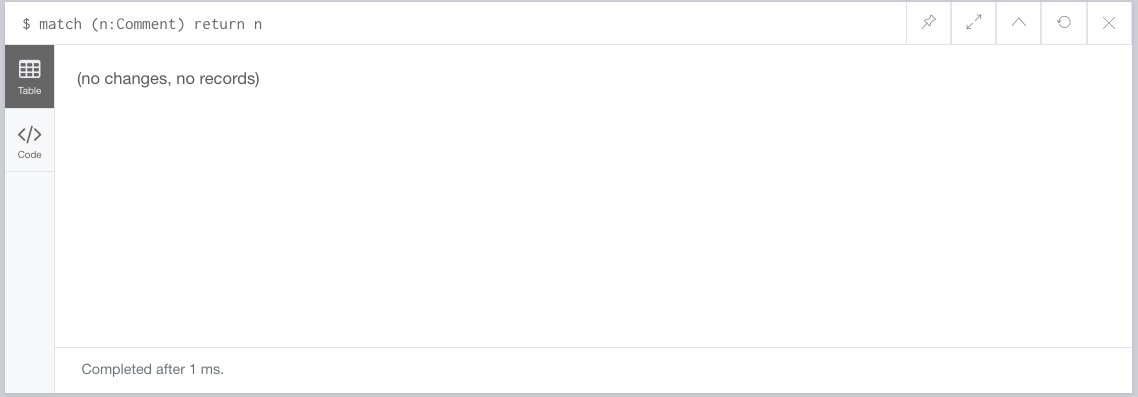 |
| :---: |
| __No Comments up my Sleeve__ |

In [75]:
def test_create_comment():
    # John Adams was from Boston. We would think that the Sox and Pedroia are awesome, if he were not dead.
    c = fg.create_comment("ja1", "Awesome", team_id="BOS", player_id="pedrodu01")
    print(c)

In [76]:
test_create_comment()

(_71733:Comment {comment: 'Awesome', comment_id: 'eca3f196-e9cc-46de-b7f5-4d9a77db5dd9'})


- Use the explore to see if it is there.

| 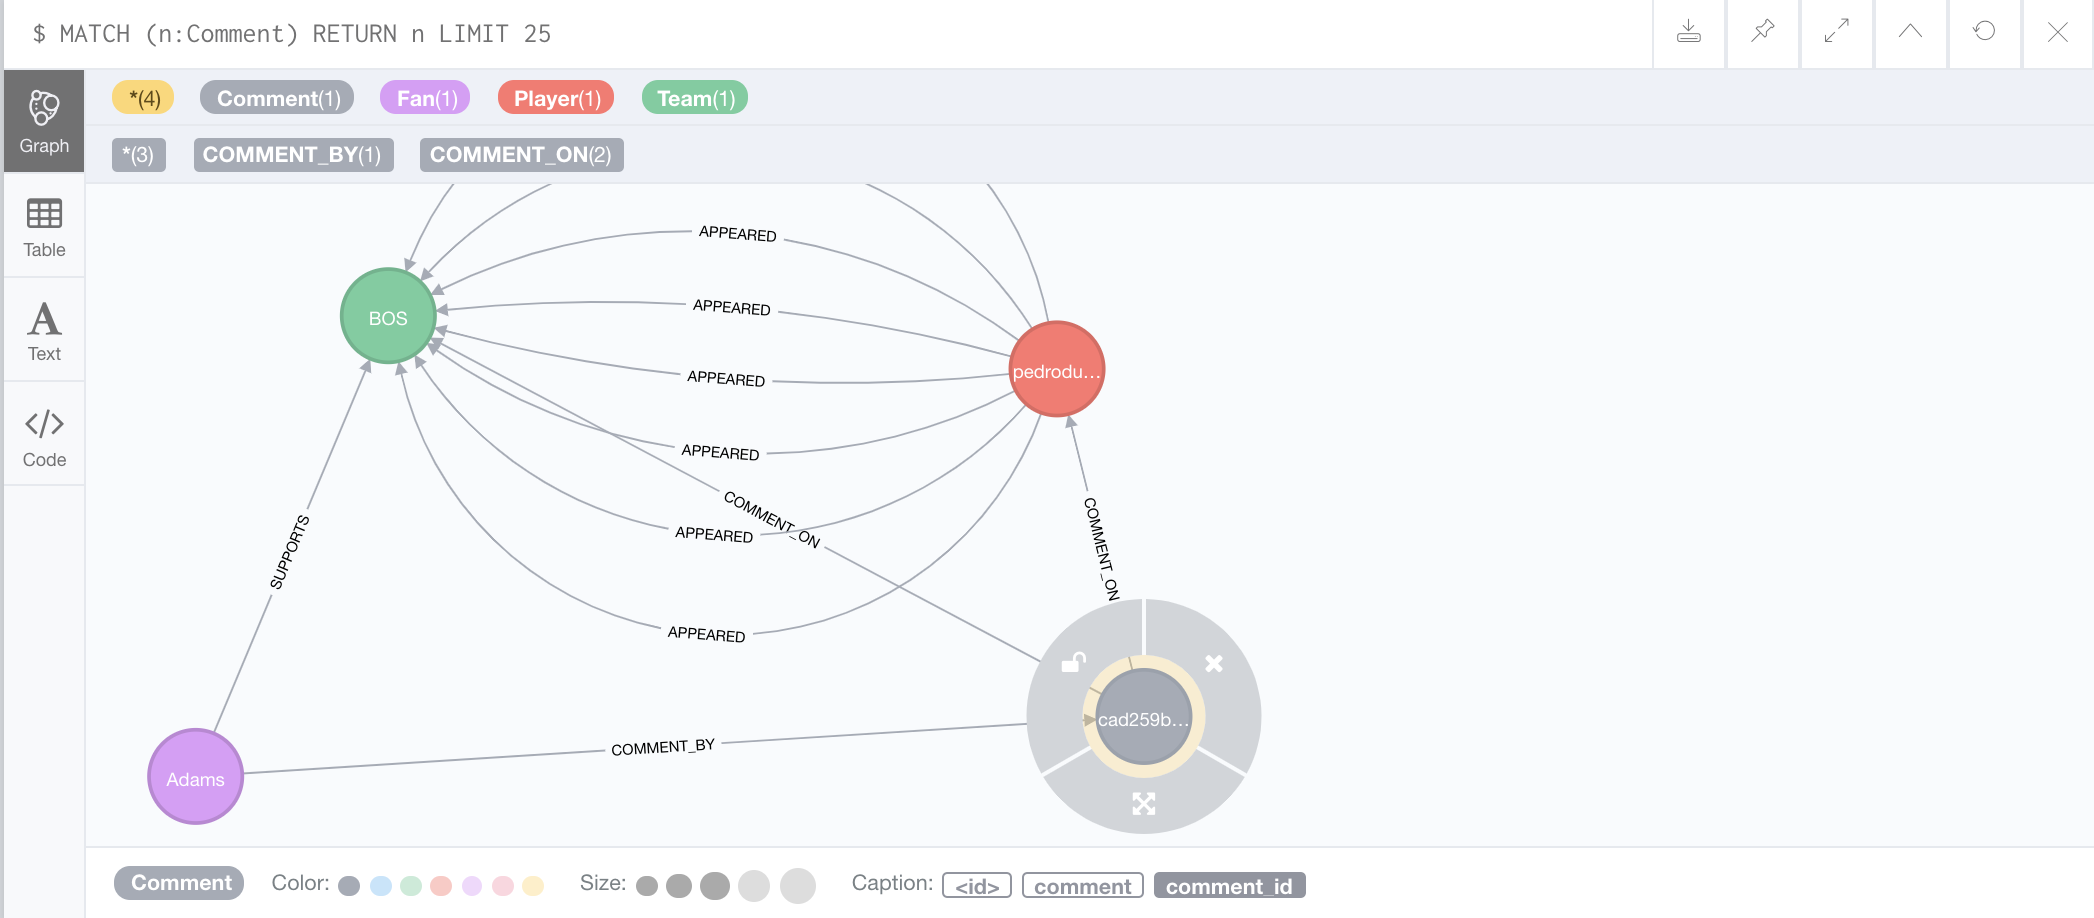 |
| :---: |
| __Comment Created__ |

In [77]:
def test_get_player_comments():
    g = fg.get_player_comments("pedrodu01")
    print(g)
    g = g.data()

    return g

In [78]:
c = test_get_player_comments()
c

[{'comment.comment': 'Awesome',
  'comment.comment_id': 'eca3f196-e9cc-46de-b7f5-4d9a77db5dd9',
  'fan.first_name': 'John',
  'fan.last_name': 'Adams',
  'fan.uni': 'ja1',
  'player.first_name': 'Dustin',
  'player.last_name': 'Pedroia',
  'player.player_id': 'pedrodu01'}]

In [79]:
# Make another comment from another person.
c = fg.create_comment("gw1", "Totally", "BOS", "pedrodu01")

- The graph now looks like ...


| 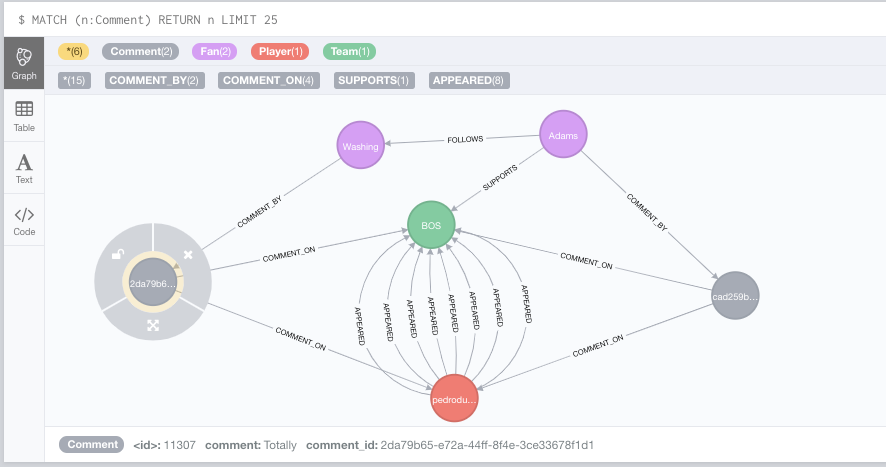 |
| :---: |
| __Created__ |

In [81]:
c = test_get_player_comments()
c

[{'comment.comment': 'Totally',
  'comment.comment_id': '212052c3-ce7c-453c-8c2f-07d942edebff',
  'fan.first_name': 'George',
  'fan.last_name': 'Washing',
  'fan.uni': 'gw1',
  'player.first_name': 'Dustin',
  'player.last_name': 'Pedroia',
  'player.player_id': 'pedrodu01'},
 {'comment.comment': 'Awesome',
  'comment.comment_id': 'eca3f196-e9cc-46de-b7f5-4d9a77db5dd9',
  'fan.first_name': 'John',
  'fan.last_name': 'Adams',
  'fan.uni': 'ja1',
  'player.first_name': 'Dustin',
  'player.last_name': 'Pedroia',
  'player.player_id': 'pedrodu01'}]

- Team comments

In [82]:
# My base function simple returns a RelationshipMatch
c = fg.get_team_comments('BOS')
print(c, "\n\n")

# This is kind of kooky. So, we need to unwind it.
# Let's see the whole structure. Start be seeing what is in the result set,
for r in c:
    print(r)

print("\n\nOK. A bunch of relationships")



(_71734)-[:COMMENT_ON {}]->(_24669)
(_71733)-[:COMMENT_ON {}]->(_24669)
(_71734)-[:COMMENT_ON {}]->(_71701)
(_71733)-[:COMMENT_ON {}]->(_71701)
(_71733)-[:COMMENT_ON {}]->(_71701)
(_71733)-[:COMMENT_ON {}]->(_24669)
(_71734)-[:COMMENT_ON {}]->(_24669)
(_71734)-[:COMMENT_ON {}]->(_71701)


OK. A bunch of relationships


In [83]:
# Relationships have start and end nodes. Let's take a look.
# This is kind of kooky. So, we need to unwind it.
# Let's see the whole structure. Start be seeing what is in the result set,
for r in c:
    print("Start = ", r.start_node)
    print("End = ", r.end_node)
    print("\n")



Start =  (_71734:Comment {comment: 'Totally', comment_id: '212052c3-ce7c-453c-8c2f-07d942edebff'})
End =  (_24669:Player {first_name: 'Dustin', last_name: 'Pedroia', player_id: 'pedrodu01'})


Start =  (_71733:Comment {comment: 'Awesome', comment_id: 'eca3f196-e9cc-46de-b7f5-4d9a77db5dd9'})
End =  (_24669:Player {first_name: 'Dustin', last_name: 'Pedroia', player_id: 'pedrodu01'})


Start =  (_71734:Comment {comment: 'Totally', comment_id: '212052c3-ce7c-453c-8c2f-07d942edebff'})
End =  (_71701:Team {team_id: 'BOS', team_name: 'Boston Red Sox'})


Start =  (_71733:Comment {comment: 'Awesome', comment_id: 'eca3f196-e9cc-46de-b7f5-4d9a77db5dd9'})
End =  (_71701:Team {team_id: 'BOS', team_name: 'Boston Red Sox'})


Start =  (_71733:Comment {comment: 'Awesome', comment_id: 'eca3f196-e9cc-46de-b7f5-4d9a77db5dd9'})
End =  (_71701:Team {team_id: 'BOS', team_name: 'Boston Red Sox'})


Start =  (_71733:Comment {comment: 'Awesome', comment_id: 'eca3f196-e9cc-46de-b7f5-4d9a77db5dd9'})
End =  (_24

In [87]:
# OK. We can massage this into something a little cleaner.   
result = {}
for r in c:
    s = r.start_node
    e = r.end_node
    cid = s['comment_id']
    this_c = result.get(cid, None)
    if this_c is None:
        this_c = {}
        this_c['comment'] = s['comment']
       
    if "Team" in e.labels:
        this_c['team']=e['team_name']
    elif "Player" in e.labels:
        this_c['player'] = e['last_name'] + "," + e['first_name']
  
    result[cid] = this_c

final_result = []
for k,v in result.items():
    new_r = {}
    new_r["id"] = k
    new_r = {**new_r, **v}
    final_result.append(new_r)

df2 = pd.DataFrame(final_result)
print("\n\nAnd a data frame holding the result is ...\n")
print(df2)

    



And a data frame holding the result is ...

   comment                                    id          player            team
0  Totally  212052c3-ce7c-453c-8c2f-07d942edebff  Pedroia,Dustin  Boston Red Sox
1  Awesome  eca3f196-e9cc-46de-b7f5-4d9a77db5dd9  Pedroia,Dustin  Boston Red Sox


## Redis $-$ HW4 Part 2

### Concept

- One of the most common uses of Redis is as a web response or API cache.

| 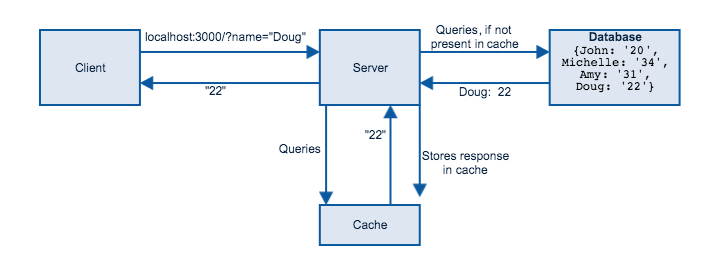 |
| :---: |
| SQL Result Cache |

|  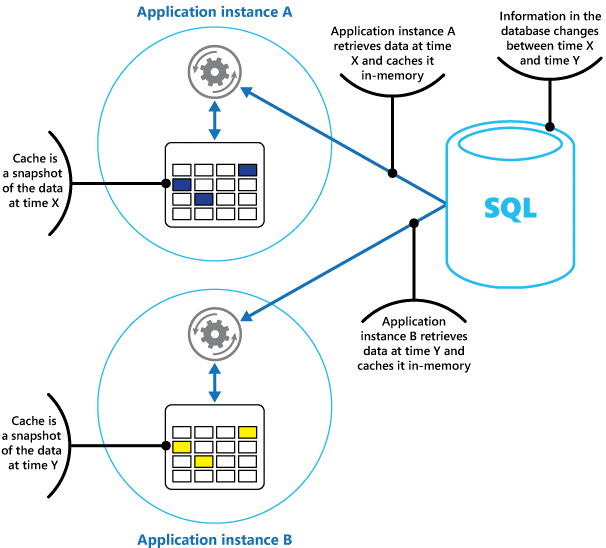|
| :---: |
| DB Cache in Web Application Flow |

- HW4 will use Redis to implement a simple result cache in front of $retrieve\_by\_template().$

### Starting Code

In [21]:
import redis
from operator import itemgetter
import json

"""
Connect to local Redis server. StrictRedis complies more closely with standard than
simple Redis client in this package. decode_responses specifies whether or not to convert
bytes to UTF8 character string or treat as raw bytes, e.g. an image, audio stream, etc.
"""
r = redis.StrictRedis(
    host='localhost',
    port=6379,
    charset="utf-8", decode_responses=True)


def add_to_cache(key, value):
    """

    :param key: A valid Redis key string.
    :param value: A Python dictionary to add to cache.
    :return: None
    """
    k = key
    #ut.debug_message("Adding key = ", k)
    #ut.debug_message("Adding data", value)
    r.set(k, value)


def get_from_cache(key):
    """

    :param key: A valid Redis key.
    :return: The "map object" associated with the key.
    """
    result = r.get(key)
    return result

def get_keys():
    result = r.keys()
    return result

def save_dict(k, d):
    result = r.hmset(k, d)
    return result

def get_dict(k):
    result = r.hgetall(k)
    return result


- Tests

In [22]:
get_keys()

['responses:545228be-bbdb-464c-acf8-c92681b0b17f',
 'some.dude@ansys.com:canary:1ac4d6ae-b0a1-48dd-a391-440f5b956b42',
 'Batting:teamID=BOS,yearID=2004,playerID=ortizda01,f=AB,H,HR,RBI,playerID',
 'blob:a145e5b3-9212-47d8-a823-888ba9edd669',
 'donald.ferguson@ansys.com:banana:8350c932-a9dd-45fe-9b48-714a19fff271',
 'People:nameLast=Williams,birthCity=San Diego,f=nameFirst,nameLast,playerID,throws',
 'cool',
 'responses:7d14c3df-9ff1-4d19-867b-cbeff04effe1',
 'Person:Student:poma2',
 'some.dude@ansys.com:mouse:1de5fa66-fbad-416a-b3b7-cce64ca4652e',
 'actor:tom_hanks',
 'donald.ferguson@ansys.com:mouse:e6ecf59e-a1ca-489b-ace0-52536b694699',
 'Person:Student:poma1',
 'blob:f6d9b168-6895-4e54-80b6-49f03d596350',
 'responses:1a7adddd-e9b4-4100-bf6a-2ab4079ac80d',
 'blob:a9501657-466e-4e6d-823b-7a0e75fe51b3',
 'Person:Faculty:fedo1',
 'Advises:fedo1',
 'some.dude@ansys.com:elk:dd41f5c6-49e5-4fb4-8274-7ffc3ed3b98c',
 'actor:tom_hanks:movies']

In [23]:
d = {"playerID": "cool", "title": "Imaginary"}

In [24]:
save_dict("2cool", d)

True

### Homework



- HW4 will add checking the Redis cache to a simple, standalone $retrieve\_by\_template()$ function.
    1. Write a function $add\_to\_cache()$ that adds a retrieve result to the cache.
    2. Write a function $retrieve\_from\_cache()$ that checks the cache and returns the value if present.
    3. Modify $retrieve\_by\_template()$ to use the cache.
        1. Check and return if cached.
        2. Call DB and add to cache if not cached.
        

### Some Helper Code


- Some helper code

In [ ]:
raise NotImplementedError("Just to get you started. Do not run.")

import pymysql.cursors
import json
import copy
import redis_cache.data_cache as dc


db_schema = None                                # Schema containing accessed data
cnx = None                                      # DB connection to use for accessing the data.
key_delimiter = '_'                             # This should probably be a config option.


def set_config():
    """
    Creates the DB connection and sets the global variables.

    :param cfg: Application configuration data.
    :return: None
    """
    global db_schema
    global cnx

    db_params = {
        "dbhost": "localhost",
        "port": 3306,
        "dbname": "lahman2017",
        "dbuser": "dbuser",
        "dbpw": "dbuserdbuser",
        "cursorClass": pymysql.cursors.DictCursor,
        "charset": 'utf8mb4'
    }

    db_schema = "lahman2017"

    cnx = db.get_new_connection(db_params)


# Given one of our magic templates, forms a WHERE clause.
# { a: b, c: d } --> WHERE a=b and c=d. Currently treats everything as a string.
# We can fix this by using PyMySQL connector query templates.
def templateToWhereClause(t):
    s = ""
    for k,v in t.items():
        if s != "":
            s += " AND "
        s += k + "='" + v + "'"

    if s != "":
        s = "WHERE " + s;

    return s

In [ ]:
raise NotImplementedError("Just to get you started. Do not run.")

def run_q(cnx, q, args, fetch=False, commit=True):
    """
    :param cnx: The database connection to use.
    :param q: The query string to run.
    :param args: Parameters to insert into query template if q is a template.
    :param fetch: True if this query produces a result and the function should perform and return fetchall()
    :return:
    """
    #debug_message("run_q: q = " + q)
    #ut.debug_message("Q = " + q)
    #ut.debug_message("Args = ", args)

    result = None

    try:
        cursor = cnx.cursor()
        result = cursor.execute(q, args)
        if fetch:
            result = cursor.fetchall()
        if commit:
            cnx.commit()
    except pymysql_exceptions as original_e:
        #print("dffutils.run_q got exception = ", original_e)
        raise(original_e)

    return result

In [ ]:
raise NotImplementedError("Just to get you started. Do not run.")

def retrieve_by_template(table, t, fields=None, limit=None, offset=None, orderBy=None, use_cache=False):


    original_fields = fields

    if t is not None:
        w = templateToWhereClause(t)
    else:
        w = ""

    if orderBy is not None:
        o = "order by " + ",".join(orderBy['fields']) + " " + orderBy['direction'] + " "
    else:
        o = ""

    if limit is not None:
        w += " LIMIT " + str(limit)
    if offset is not None:
        w += " OFFSET " + str(offset)

    if fields is None:
        fields = " * "
    else:
        fields = " " + ",".join(fields) + " "

    cursor=cnx.cursor()
    q = "SELECT " + fields + " FROM " + table + " " + w + ";"

    r = run_q(cnx, q, None, fetch=True, commit=True)

    return r

In [ ]:
raise NotImplementedError("Just to get you started. Do not run.")

def check_cache(table, tmp, fields, limit, offset, orderBy):
    pass


def add_to_cache(table, tmp, fields, limit, offset, orderBy, q_result):
    pass


#### Some Test Code

- Switching to my super secret implementation.

In [1]:
import sys
sys.path.append(
    '/Users/donaldferguson/Dropbox/ColumbiaCourse/Courses/W4111New/w4111-Databases/HW_Solutions/HW4')

In [3]:
from redis_cache import data_cache
from utils import utils as ut
from dbservice import dataservice as ds
import json

ut.set_debug_mode(True)
ds.set_config()

In [4]:
tmp = { "nameLast": "Williams", "birthState": "CA"}
fields = ["playerID", "nameLast", "nameFirst", "throws"]
resource = "People"


result = ds.retrieve_by_template(resource, tmp, fields, use_cache=True)
    


Check cache returned  None 

CACHE MISS


In [5]:
result = ds.retrieve_by_template(resource, tmp, fields, use_cache=True)


Check cache returned  [{'playerID': 'willibe01', 'nameLast': 'Williams', 'nameFirst': 'Bernie', 'throws': 'R'}, {'playerID': 'willido02', 'nameLast': 'Williams', 'nameFirst': 'Don', 'throws': 'R'}, {'playerID': 'williji03', 'nameLast': 'Williams', 'nameFirst': 'Jimy', 'throws': 'R'}, {'playerID': 'willike02', 'nameLast': 'Williams', 'nameFirst': 'Ken', 'throws': 'R'}, {'playerID': 'willima04', 'nameLast': 'Williams', 'nameFirst': 'Matt', 'throws': 'R'}, {'playerID': 'willimi02', 'nameLast': 'Williams', 'nameFirst': 'Mitch', 'throws': 'L'}, {'playerID': 'williri02', 'nameLast': 'Williams', 'nameFirst': 'Rinaldo', 'throws': 'R'}, {'playerID': 'williri03', 'nameLast': 'Williams', 'nameFirst': 'Rick', 'throws': 'R'}, {'playerID': 'willish01', 'nameLast': 'Williams', 'nameFirst': 'Shad', 'throws': 'R'}, {'playerID': 'willite01', 'nameLast': 'Williams', 'nameFirst': 'Ted', 'throws': 'R'}, {'playerID': 'willitr01', 'nameLast': 'Williams', 'nameFirst': 'Trevor', 'throws': 'R'}] 

CACHE HIT


## DynamoDB Code

### DynamoDB Python API

#### Functions

|                 |                     |
|----------------------------------|----------------------------------|
| batch_get_item()                 | get_waiter()                     |
| batch_write_item()               | list_backups()                   |
| can_paginate()                   | list_global_tables()             |
| create_backup()                  | list_tables()                    |
| create_global_table()            | list_tags_of_resource()          |
| create_table()                   | put_item()                       |
| delete_backup()                  | query()                          |
| delete_item()                    | restore_table_from_backup()      |
| delete_table()                   | restore_table_to_point_in_time() |
| describe_backup()                | scan()                           |
| describe_continuous_backups()    | tag_resource()                   |
| describe_endpoints()             | untag_resource()                 |
| describe_global_table()          | update_continuous_backups()      |
| describe_global_table_settings() | update_global_table()            |
| describe_limits()                | update_global_table_settings()   |
| describe_table()                 | update_item()                    |
| describe_time_to_live()          | update_table()                   |
| generate_presigned_url()         | update_time_to_live()            |
| get_item()                       |   get_paginator()                |
| | [DynamoDB Python API](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/dynamodb.html) |

- Lot's of obvious operations for reading, writing, getting metadata, etc.


- Unlike a DB, you must use pagination. There are no cursors or fetchall().


- No functions like JOIN. 


- The primary functions are:
    - ```get_item(), delete_item()``` and ```put_item(),``` which are link select, delete and insert using a primary key for an RDB.
    - ```scan(),``` which is like a ```select ... where ... ``` but using a different format for project and select clauses.
    - There is also support for batch operations, because the primary focus is web scale performance.

### Examples

#### Overview

- I downloaded and am using the "local" DynamoDB for these tests. See https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/DynamoDBLocal.html.


- I used the AWS Command Line (CLI) to create the local tables.

```
aws dynamodb create-table --table-name
CustomerProfileTypes --attribute-definitions AttributeName=profile_label,AttributeType=S
--key-schema AttributeName=profile_label,KeyType=HASH
--provisioned-throughput ReadCapacityUnits=5,WriteCapacityUnits=5 --endpoint-url http://localhost:8000
```

- The tests below actually use a cloud DynamoDB

#### Setup the Client

In [9]:
import boto3

client = boto3.client('dynamodb')
from boto3.dynamodb.conditions import Key, Attr

# There is some weird stuff in DynamoDB JSON responses. These utils work better.
from dynamodb_json import json_util as jsond

#dynamodb = boto3.resource('dynamodb'), endpoint_url='http://localhost:8000')

dynamodb = boto3.resource('dynamodb')

#### Get and Item from a Table

In [10]:
def do_a_get(table_name, key):
    table = dynamodb.Table(table_name)

    response = table.get_item(
        Key=key
    )

    print("GetItem succeeded:")
    return response
    #print(json.dumps(response, indent=4))

In [13]:
response = do_a_get('orders', key = {
        "order_number" : "O123"
    })
print(json.dumps(response, indent=4, default=str))

GetItem succeeded:
{
    "Item": {
        "orderDate": "2003-01-06",
        "orderdetails": [
            {
                "quantityOrdered": "49",
                "productCode": "S24_3969",
                "orderLineNumber": "1",
                "priceEach": "35.29"
            },
            {
                "quantityOrdered": "50",
                "productCode": "S18_2248",
                "orderLineNumber": "2",
                "priceEach": "55.09"
            },
            {
                "quantityOrdered": "30",
                "productCode": "S18_1749",
                "orderLineNumber": "3",
                "priceEach": "136.00"
            },
            {
                "quantityOrdered": "22",
                "productCode": "S18_4409",
                "orderLineNumber": "4",
                "priceEach": "75.46"
            }
        ],
        "status": "Shipped",
        "comments": null,
        "requiredDate": "2003-01-13",
        "order_number": "O123",
        

#### Get Table Metadata

In [14]:
def describe_table(table_name):
    result = client.describe_table(TableName='CustomerProfileTypes')
    print(jsond.dumps(result, indent=3))

In [15]:
describe_table('CustomerProfileTypes')

{
   "Table": {
      "M": {
         "AttributeDefinitions": {
            "L": [
               {
                  "M": {
                     "AttributeName": {
                        "S": "profile_label"
                     },
                     "AttributeType": {
                        "S": "S"
                     }
                  }
               }
            ]
         },
         "TableName": {
            "S": "CustomerProfileTypes"
         },
         "KeySchema": {
            "L": [
               {
                  "M": {
                     "AttributeName": {
                        "S": "profile_label"
                     },
                     "KeyType": {
                        "S": "HASH"
                     }
                  }
               }
            ]
         },
         "TableStatus": {
            "S": "ACTIVE"
         },
         "CreationDateTime": {
            "S": "2018-10-11T09:39:31.455000"
         },
         "ProvisionedThrough

#### Put an Item

In [17]:
def do_a_put(table_name, item):
    table = dynamodb.Table(table_name)
    response = table.put_item(
        Item=item
    )
    return response

In [18]:
o_all_1 = {
            "order_number": "O124",
            "orderDate": "2003-01-31",
            "requiredDate": "2003-04-13",
            "shippedDate": "2003-04-10",
            "status": "Shipped",
            "comments": None,
            "customerNumber": 101, 
    "orderdetails":
        [
        {
            "productCode": "S24_3969",
            "quantityOrdered": 49,
            "priceEach": "35.29",
            "orderLineNumber": 2
        },
        {
            "productCode": "S12_1001",
            "quantityOrdered": 100,
            "priceEach": "35.29",
            "orderLineNumber": 11
        }
        ]
}

result = do_a_put('orders',
            o_all_1)
print(json.dumps(result, indent=4))

{
    "ResponseMetadata": {
        "RequestId": "BON3JD85II8GCDUFI5SPOJP9KNVV4KQNSO5AEMVJF66Q9ASUAAJG",
        "HTTPStatusCode": 200,
        "HTTPHeaders": {
            "server": "Server",
            "date": "Thu, 18 Apr 2019 17:08:46 GMT",
            "content-type": "application/x-amz-json-1.0",
            "content-length": "2",
            "connection": "keep-alive",
            "x-amzn-requestid": "BON3JD85II8GCDUFI5SPOJP9KNVV4KQNSO5AEMVJF66Q9ASUAAJG",
            "x-amz-crc32": "2745614147"
        },
        "RetryAttempts": 0
    }
}


#### Scan a Table

In [22]:
def do_a_scan(table_name, filterexpression):
    table = dynamodb.Table(table_name)

    if filterexpression is not None:
        response = table.scan(
            filterexpression
        )
    else:
        response = table.scan(
        )

    print("Scan succeeded")
    #print(json.dumps(response, indent=4))
    return response

In [23]:
response = do_a_scan('orders', filterexpression=None)
print("Scan = ", json.dumps(response, indent=2, default=str))

Scan succeeded
Scan =  {
  "Items": [
    {
      "orderDate": "2003-01-31",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "2",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "100",
          "productCode": "S12_1001",
          "orderLineNumber": "11",
          "priceEach": "35.29"
        }
      ],
      "status": "Shipped",
      "comments": null,
      "requiredDate": "2003-04-13",
      "order_number": "O124",
      "customerNumber": "101",
      "shippedDate": "2003-04-10"
    },
    {
      "orderDate": "2003-01-06",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "1",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "50",
          "productCode": "S18_2248",
          "orderLineNumber": "2",
          "priceEach": "55.09"
        },
     

In [25]:
FilterExpression = Attr('customerNumber').eq(363)
response = do_a_scan('orders', FilterExpression)
print("Scan = ", json.dumps(response, indent=2, default=str))

Scan succeeded
Scan =  {
  "Items": [
    {
      "orderDate": "2003-01-31",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "2",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "100",
          "productCode": "S12_1001",
          "orderLineNumber": "11",
          "priceEach": "35.29"
        }
      ],
      "status": "Shipped",
      "comments": null,
      "requiredDate": "2003-04-13",
      "order_number": "O124",
      "customerNumber": "101",
      "shippedDate": "2003-04-10"
    },
    {
      "orderDate": "2003-01-06",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "1",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "50",
          "productCode": "S18_2248",
          "orderLineNumber": "2",
          "priceEach": "55.09"
        },
     